# Projet 7: Implémentez un modèle de scoring

# Notebook de modélisation - sauvegarde sur GitHub

### <font color="#0000FF">Sommaire</font>

1. [Analyse des datasets et pré-processing](#section_1)<br>
    1.1. [Visualisation databases](#section_1_1)<br>
    1.2. [Pré-processing "application_train"](#section_1_2)<br>
    1.3. [Pré-processing "bureau.csv" & "bureau_balance.csv" + fusion](#section_1_3)<br>
    1.4. [Pré-processing "previous_applications.csv" + fusion](#section_1_4)<br>
    1.5. [Pré-processing "POS_CASH_balance.csv" + fusion](#section_1_5)<br>
    1.6. [Pré-processing "installments_payments.csv" + fusion](#section_1_6)<br>
    1.7. [Pré-processing "credit_card_balance.csv" + fusion](#section_1_7)<br>
    1.8. [Création du Data frame final](#section_1_8)<br>    
    
  
2. [Features importance et création dataframes](#section_2)<br>
    2.1. [Features importance globale selection pour modélisation](#section_2_1)    
    2.2. [Constitution de dataframes pour entrainement et prediction](#section_2_2)<br>   
    
    
3. [Simulation modélisation et progression](#section_3)<br>
    3.1. [Simulation des algorithmes d'apprentissage](#section_3_1)    
    3.2. [Optimisation des hyperparamètres - meilleur modèle](#section_3_2)    
    3.3. [Seuil optimal avec G-mean pour données déséquilibrées](#section_3_3)<br>
    3.4. [Seuil optimal avec F1-score pour données déséquilibrées](#section_3_4)    
    3.5. [Sélection features globales et locales](#section_3_5)<br>
    
    
4. [Préparation du Dashboard](#section_4)<br>
    4.1. [Constitution dataframes et prediction pour 500 clients](#section_4_1)<br>
    4.2. [Constitution informations et prêt clients](#section_4_2)    
    4.3. [Constitution datasets pour les graphiques](#section_4_3) 

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display, display_html, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pickle

In [2]:
# utilities
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, classification_report, fbeta_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
xgb.set_config(verbosity=0)
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample

In [8]:
import shap
shap.initjs() 

In [3]:
import os
os.chdir('C:\\Users\\Gabriela\\Documents\\OCR\\P7_rev_vf\\Soutenance\\')

## <font color="#0000FF" id="section_1">1. Analyse des datasets et pré-processing</font>

### <font color="#0000FF" id="section_1_1">1.1. Visualisation databases</font>

In [3]:
homecredit = pd.read_csv("HomeCredit_columns_description.csv", delimiter = ",", encoding='cp1252')
pos_cash_balance = pd.read_csv("POS_CASH_balance.csv", delimiter = ",")
bureau = pd.read_csv("bureau.csv", delimiter = ",")
bureau_balance = pd.read_csv("bureau_balance.csv", delimiter = ",")
credit_card_balance = pd.read_csv("credit_card_balance.csv", delimiter = ",")
installm_paym = pd.read_csv("installments_payments.csv", delimiter = ",")
previous_appl = pd.read_csv("previous_application.csv", delimiter = ",")
sample_subm = pd.read_csv("sample_submission.csv", delimiter = ",")
appl_test = pd.read_csv("application_test.csv", delimiter = ",")
appl_train = pd.read_csv("application_train.csv", delimiter = ",")

In [6]:
display(HTML('<h3>homecredit: visualisation données</h3>'))
display("Ce fichier contient les descriptions des colonnes des différents fichiers de données")
display(homecredit.head(5))
display(homecredit.shape)
display()
display(HTML('<h3>bureau: visualisation données</h3>'))
display("Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau ")
display("Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande")
display(bureau.head(5))
display(bureau.shape)
display()
display(HTML('<h3>bureau_balance: visualisation données</h3>'))
display("Soldes mensuels des crédits précédents dans le Credit Bureau")
display("Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau ")
display(bureau_balance.head(5))
display(bureau_balance.shape)
display()
display(HTML('<h3>previous_appl: visualisation données</h3>'))
display("Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon")
display("Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données")
display(previous_appl.head(5))
display(previous_appl.shape)
display()
display(HTML('<h3>pos_cash_balance: visualisation données</h3>'))
display("Des instantanés mensuels des soldes des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit")
display("Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon ")
display(pos_cash_balance.head(5))
display(pos_cash_balance.shape)
display()
display(HTML('<h3>installm_paym: visualisation données</h3>'))
display("L'historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon")
display("Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué")
display("Une ligne est équivalente à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit de Home Credit précédent lié aux prêts de notre échantillon")
display(installm_paym.head(5))
display(installm_paym.shape)
display()
display(HTML('<h3>credit_card_balance: visualisation données</h3>'))
display("Instantanés des soldes mensuels des cartes de crédit antérieures que le demandeur possède chez Home Credit")
display("Ce tableau a une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon")
display(credit_card_balance.head(5))
display(credit_card_balance.shape)
display()
display(HTML('<h3>appl_train: visualisation données</h3>'))
display("Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)")
display("Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données")
display(appl_train.head(5))
display(appl_train.shape)
display()
display(HTML('<h3>appl_test: visualisation données</h3>'))
display("Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)")
display("Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données")
display(appl_test.head(5))
display(appl_test.shape)
display()
display(HTML('<h3>sample_subm: visualisation données</h3>'))
display(sample_subm.head(5))
display(sample_subm.shape)

'Ce fichier contient les descriptions des colonnes des différents fichiers de données'

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

(219, 5)

"Tous les crédits précédents du client fournis par d'autres institutions financières qui ont été rapportés au Credit Bureau "

'Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit Bureau avant la date de la demande'

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

(1716428, 17)

'Soldes mensuels des crédits précédents dans le Credit Bureau'

"Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent rapporté au Credit Bureau "

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

(27299925, 3)

'Toutes les demandes précédentes de prêts pour le crédit immobilier des clients qui ont des prêts dans notre échantillon'

'Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données'

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

(1670214, 37)

'Des instantanés mensuels des soldes des prêts POS (point of sales) et cash précédents que le demandeur a eu avec Home Credit'

"Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts au comptant) lié aux prêts de notre échantillon "

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

(10001358, 8)

"L'historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon"

'Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué'

"Une ligne est équivalente à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit de Home Credit précédent lié aux prêts de notre échantillon"

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

(13605401, 8)

'Instantanés des soldes mensuels des cartes de crédit antérieures que le demandeur possède chez Home Credit'

"Ce tableau a une ligne pour chaque mois de l'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon"

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

(3840312, 23)

"Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)"

'Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données'

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

(307511, 122)

"Il s'agit du tableau principal, divisé en deux fichiers pour Train (avec TARGET) et Test (sans TARGET)"

'Données statiques pour toutes les demandes. Une ligne représente un prêt dans notre échantillon de données'

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

(48744, 121)

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

(48744, 2)

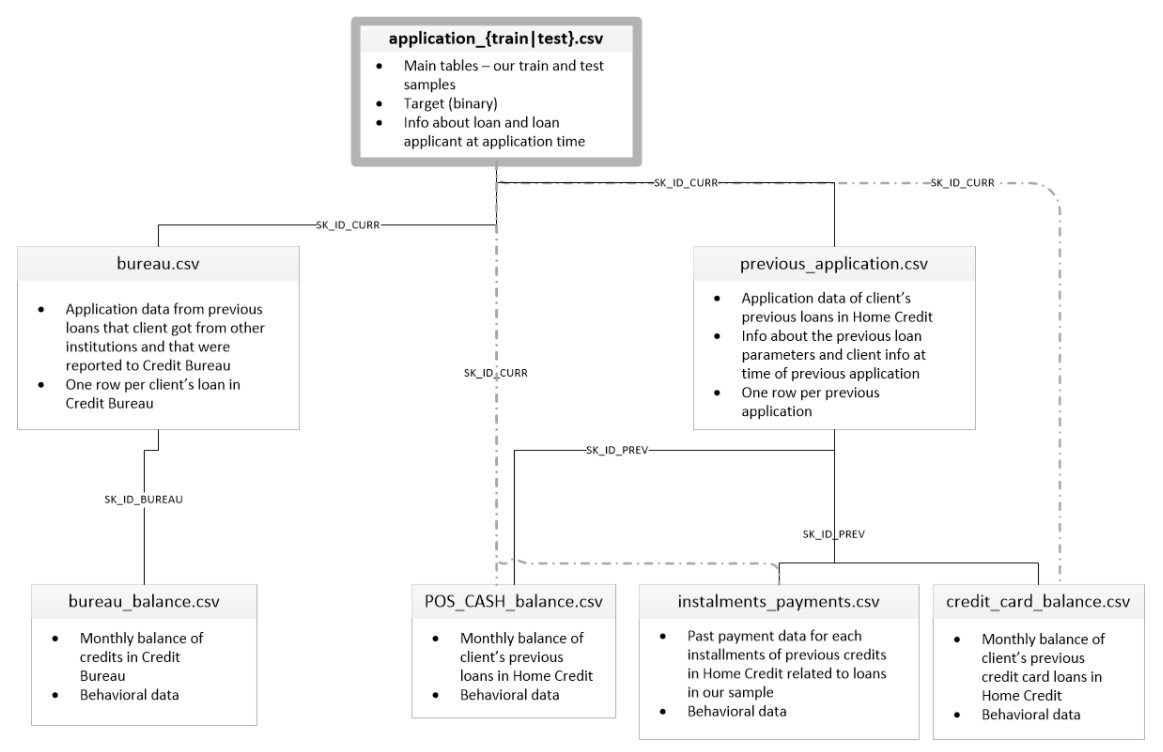

In [15]:
from IPython.display import Image
Image(filename='Application_explained.jpg', width=1800, height=400)

## Définition fonctions

In [9]:
def get_types_variables(df_work, types, type_par_var, graph):
    """ Permet un aperçu du type des variables
    Parameters
    ----------
    @param IN : df_work : dataframe, obligatoire
                types : Si True lance dtypes, obligatoire
                type_par_var : Si True affiche tableau des types de
                               chaque variable, obligatoire
                graph : Si True affiche pieplot de répartition des types
    @param OUT :None.
    """

    if types:
        # 1. Type des variables
        print("-------------------------------------------------------------")
        print("Type de variable pour chacune des variables\n")
        display(df_work.dtypes)

    if type_par_var:
        # 2. Compter les types de variables
        #print("Répartition des types de variable\n")
        values = df_work.dtypes.value_counts()
        nb_tot = values.sum()
        percentage = round((100 * values / nb_tot), 2)
        table = pd.concat([values, percentage], axis=1)
        table.columns = [
            'Nombre par type de variable',
            '% des types de variable']
        display(table[table['Nombre par type de variable'] != 0]
                .sort_values('% des types de variable', ascending=False)
                .style.background_gradient('seismic'))

    if graph:
        # 3. Schéma des types de variable
        # print("\n----------------------------------------------------------")
        #print("Répartition schématique des types de variable \n")
        # Répartition des types de variables
        df_work.dtypes.value_counts().plot.pie(autopct='%1.1f%%')
        plt.ylabel('')
        plt.show()

In [10]:
def description_variables(dataframe, type_var='all'):
    """
    Retourne la description des variables qualitatives/quantitatives
    ou toutes les variables du dataframe transmis :
    type, nombre de nan, % de nan et desc
    Parameters
    ----------
    @param IN : dataframe : DataFrame, obligatoire
                type_var = 'all' ==> tous les types de variables (défaut)
                           'cat' ==> variables catégorielles
                           'num' ==> variables quantitative
                           facultatif
    @param OUT : dataframe de description des variables
    """
    df_taille = dataframe.shape[0]

    if type_var == 'num':
        desc_var = dataframe.describe(datetime_is_numeric=True)
    elif type_var == 'cat':
        desc_var = dataframe.describe(
            exclude=[np.number], datetime_is_numeric=True)
    else:
        desc_var = dataframe.describe(include='all', datetime_is_numeric=True)

    desc_type = pd.DataFrame(
        dataframe[desc_var.columns].dtypes, columns=['type']).T
    nb_nan = df_taille - desc_var.loc['count'].T
    pourcentage_nan = nb_nan * 100 / np.product(dataframe.shape)
    desc_nan = pd.DataFrame([nb_nan, pourcentage_nan],
                            index=['nb_nan', '%_nan'])
    desc_var = pd.concat([desc_type, desc_nan, desc_var])

    return desc_var

In [11]:
# Afficher des informations sur les valeurs manquantes

def get_missing_values(df_work, pourcentage, affiche_heatmap, retour=False):
    """Indicateurs sur les variables manquantes
       @param in : df_work dataframe obligatoire
                   pourcentage : boolean si True affiche le nombre heatmap
                   affiche_heatmap : boolean si True affiche la heatmap
       @param out : none
    """

    # 1. Nombre de valeurs manquantes totales
    nb_nan_tot = df_work.isna().sum().sum()
    nb_donnees_tot = np.product(df_work.shape)
    pourc_nan_tot = round((nb_nan_tot / nb_donnees_tot) * 100, 2)
    print(
        f'Valeurs manquantes : {nb_nan_tot} NaN pour {nb_donnees_tot} données ({pourc_nan_tot} %)')

    if pourcentage:
        print("-------------------------------------------------------------")
        print("Nombre et pourcentage de valeurs manquantes par variable\n")
        # 2. Visualisation du nombre et du pourcentage de valeurs manquantes par variable
        values = df_work.isnull().sum()
        percentage = 100 * values / len(df_work)
        table = pd.concat([values, percentage.round(2)], axis=1)
        table.columns = [
            'Nombres de valeurs manquantes',
            '% de valeurs manquantes']
        display(table[table['Nombres de valeurs manquantes'] != 0]
                .sort_values('% de valeurs manquantes', ascending=False)
                .style.background_gradient('seismic'))

    if affiche_heatmap:
        print("-------------------------------------------------------------")
        print("Heatmap de visualisation des valeurs manquantes")
        # 3. Heatmap de visualisation des valeurs manquantes
        plt.figure(figsize=(20, 10))
        sns.heatmap(df_work.isna(), cbar=False)
        plt.show()

    if retour:
        return table

### Variables catégorielles

In [12]:
# OneHotEncoder pour les variables catégorielles avec  get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Features engineering crées à partir du kernel qui a obtenue une bonne performance
#### https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [ ]:
# La plupart des caractéristiques sont créées en appliquant les fonctions min, max, mean, sum et var à des tableaux groupés. 
# Il y a peu de sélection de caractéristiques et l'ajustement excessif peut être un problème puisque de nombreuses caractéristiques sont liées.
# Les idées clés suivantes ont été utilisées :
# Diviser ou soustraire des caractéristiques importantes pour obtenir des taux (comme l'annuité et le revenu).
# - Dans les données du bureau : créer des caractéristiques spécifiques pour les crédits actifs et les crédits fermés.
# Dans les demandes précédentes : créer des caractéristiques spécifiques pour les demandes approuvées et refusées.
# Modularité : une fonction pour chaque table (sauf bureau_balance et application_test).
# - Encodage unique pour les caractéristiques catégorielles
# Toutes les tables sont jointes avec l'application DF en utilisant la clé SK_ID_CURR (sauf bureau_balance).

### <font color="#0000FF" id="section_1_2">1.2. Pré-processing "application_train"</font>

<span style='background:PaleGreen'>**Description**</span>

- Le fichier application_train.csv est constituée de données statiques relatives aux emprunteurs avec des étiquettes TARGET. 
- Chaque ligne représente une demande de prêt.

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

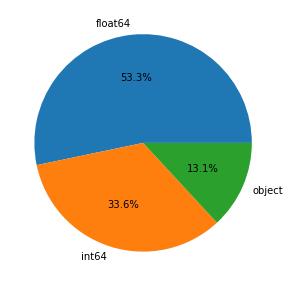

In [18]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(appl_train, True, False, True)

In [19]:
# Résumé des variables
desc_appl_train = description_variables(appl_train)
desc_appl_train

SK_ID_CURR    TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int64     int64             object      object       object   
nb_nan            0.0       0.0                0.0         0.0          0.0   
%_nan             0.0       0.0                0.0         0.0          0.0   
count        307511.0  307511.0             307511      307511       307511   
unique            NaN       NaN                  2           3            2   
top               NaN       NaN         Cash loans           F            N   
freq              NaN       NaN             278232      202448       202924   
mean    278180.518577  0.080729                NaN         NaN          NaN   
std     102790.175348  0.272419                NaN         NaN          NaN   
min          100002.0       0.0                NaN         NaN          NaN   
25%          189145.5       0.0                NaN         NaN          NaN   
50%          278202.0       0.0                NaN         NaN          NaN   
75%          367142.5       0.0                NaN         NaN          NaN   
max          456255.0       1.0                NaN         NaN          NaN   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL     AMT_CREDIT  \
type            object        int64          float64        float64   
nb_nan             0.0          0.0              0.0            0.0   
%_nan              0.0          0.0              0.0            0.0   
count           307511     307511.0         307511.0       307511.0   
unique               2          NaN              NaN            NaN   
top                  Y          NaN              NaN            NaN   
freq            213312          NaN              NaN            NaN   
mean               NaN     0.417052    168797.919297  599025.999706   
std                NaN     0.722121    237123.146279  402490.776996   
min                NaN          0.0          25650.0        45000.0   
25%                NaN          0.0         112500.0       270000.0   
50%                NaN          0.0         147150.0       513531.0   
75%                NaN          1.0         202500.0       808650.0   
max                NaN         19.0      117000000.0      4050000.0   

         AMT_ANNUITY  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
type         float64  ...            int64            int64            int64   
nb_nan          12.0  ...              0.0              0.0              0.0   
%_nan       0.000032  ...              0.0              0.0              0.0   
count       307499.0  ...         307511.0         307511.0         307511.0   
unique           NaN  ...              NaN              NaN              NaN   
top              NaN  ...              NaN              NaN              NaN   
freq             NaN  ...              NaN              NaN              NaN   
mean    27108.573909  ...          0.00813         0.000595         0.000507   
std     14493.737315  ...         0.089798         0.024387         0.022518   
min           1615.5  ...              0.0              0.0              0.0   
25%          16524.0  ...              0.0              0.0              0.0   
50%          24903.0  ...              0.0              0.0              0.0   
75%          34596.0  ...              0.0              0.0              0.0   
max         258025.5  ...              1.0              1.0              1.0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
type              int64                    float64                   float64   
nb_nan              0.0                    41519.0                   41519.0   
%_nan               0.0                   0.110669                  0.110669   
count          307511.0                   265992.0                  265992.0   
unique              NaN                        NaN                       NaN   
top                 NaN                        NaN                       NaN  

In [20]:
len(appl_train['SK_ID_CURR'].unique())

307511

**Bilan** :
***
- Le fichier application_train.csv contient environ **307511 enregistrements** et **122 variables**. 
- Ces variables contiennent les **statistiques personnelles d'un demandeur particulier**, telles que son âge, ses revenus, le type de prêt, les statistiques de son appartement, etc.
- Il y a **307511 SK_ID_CURR uniques** qui représentent des demandes de prêt uniques.
- Le champ **TARGET** représente le **statut de défaut de paiement du prêt** :
    - 0 pour solvable,
    - et 1 pour défaillant.

### Variable TARGET

In [21]:
appl_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [25]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

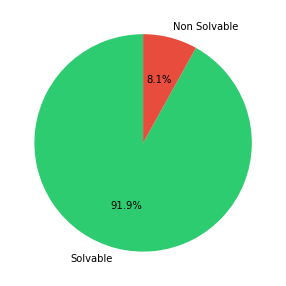

In [194]:
# Pieplot solvabilité clients du jeu d'entrainement
rcParams['figure.figsize'] = 5, 5
solvability_clients(appl_train)

In [196]:
# Valeurs manquantes du dataframe appl_train
get_missing_values(appl_train, True, False, True)

Valeurs manquantes : 9152465 NaN pour 37516342 données (24.4 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
SK_ID_CURR                                              0   
TARGET                                                  0   
NAME_CONTRACT_TYPE                                      0   
CODE_GENDER                                             0   
FLAG_OWN_CAR                                            0   
...                                                   ...   
AMT_REQ_CREDIT_BUREAU_DAY                           41519   
AMT_REQ_CREDIT_BUREAU_WEEK                          41519   
AMT_REQ_CREDIT_BUREAU_MON                           41519   
AMT_REQ_CREDIT_BUREAU_QRT                           41519   
AMT_REQ_CREDIT_BUREAU_YEAR                          41519   

                            % de valeurs manquantes  
SK_ID_CURR                                      0.0  
TARGET                                          0.0  
NAME_CONTRACT_TYPE                              0.0  
CODE_GENDER                                     0.0  
FLAG_OWN_CAR                                    0.0  
...                                             ...  
AMT_REQ_CREDIT_BUREAU_DAY                      13.5  
AMT_REQ_CREDIT_BUREAU_WEEK                     13.5  
AMT_REQ_CREDIT_BUREAU_MON                      13.5  
AMT_REQ_CREDIT_BUREAU_QRT                      13.5  
AMT_REQ_CREDIT_BUREAU_YEAR                     13.5  

[122 rows x 2 columns]

### Conclusion: top 20 des variables explicatives pour la variable cible 'TARGET'

In [197]:
corr_matr = appl_train.corr()
abs(corr_matr['TARGET']).sort_values(ascending=False)[:21]

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE     0.037227
Name: TARGET, dtype: float64

**Bilan** :
- Parmi toutes les variables, nous constatons une corrélation élevée pour les variables EXT_SOURCE par rapport à la variable cible. Celles-ci peuvent être importantes pour la tâche de classification.

## Preprocess application_train.csv et introduction des variables métier/features engineering

In [199]:
def application_train_cleaned(num_rows = None, nan_as_category = False):
    # Lecture data 
    application_train = pd.read_csv('application_train.csv', nrows= num_rows)
    print("Train samples: {}".format(len(application_train)))
    # Suppression de 4 clients avec sexe non renseigné, XNA CODE_GENDER (train set)
    application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
    # Suppression de 5 clients  'NAME_INCOME_TYPE' prend la valeur 'Maternity leave' uniquement pour 5 emprunters
    application_train = application_train[application_train['NAME_INCOME_TYPE'] != 'Maternity leave']
    # Suppression de 2 clients ayant  la colonne NAME_FAMILY_STATUS la valeur Unknown 
    application_train = application_train[application_train['NAME_FAMILY_STATUS'] != 'Unknown']
    
    
    # Variables catégorielles avec codage binaire (0 ou 1 ; deux catégories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        application_train[bin_feature], uniques = pd.factorize(application_train[bin_feature])
    # Variables catégorielles avec OneHotEncoder
    application_train, cat_cols = one_hot_encoder(application_train, nan_as_category)
    
    # Correction valeurs aberantes: Nan pour DAYS_EMPLOYED: (18% lignes) 365243 (=1000 ans)-> nan
    application_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # Nouvelles Features Engineering (percentages), variables métier, pour aider le modéle:
    # Le ratio temps travaillé/âge
    # Le ratio crédit/revenu
    # le ratio crédit/annuité/âge
    # le ratio revenu/annuité
    # le ratio crédit/annuité
    application_train['DAYS_EMPLOYED_PERC'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']
    application_train['INCOME_CREDIT_PERC'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
    application_train['INCOME_PER_PERSON'] = application_train['AMT_INCOME_TOTAL'] / application_train['CNT_FAM_MEMBERS']
    application_train['ANNUITY_INCOME_PERC'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
    application_train['PAYMENT_RATE'] = application_train['AMT_ANNUITY'] / application_train['AMT_CREDIT']
    # del test_df
    gc.collect()
    return application_train

In [200]:
appl_train_new = application_train_cleaned(num_rows = None, nan_as_category = False)
appl_train_new

Train samples: 307511


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307506      456251       0            0             0                1   
307507      456252       0            1             0                0   
307508      456253       0            1             0                0   
307509      456254       1            1             0                0   
307510      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  ...  WALLSMATERIAL_MODE_Panel  \
0              351000.0  ...                         0   
1             1129500.0  ...                         0   
2              135000.0  ...                         0   
3              297000.0  ...                         0   
4              513000.0  ...                         0   
...                 ...  ...                       ...   
307506         225000.0  ...                         0   
307507         225000.0  ...                         0   
307508         585000.0  ...                         1   
307509         319500.0  ...                         0   
307510         675000.0  ...                         1   

        WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
0                                     1                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   
...                                 ...                        ...   
307506                                1                          0   
307507                                1                          0   
307508                                0                          0   
307509                                1                          0   
307510                                0                          0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
0                            1                        0            0.067329   
1                            1                        0            0.070862   
2                            0                        0            0.011814   
3                            0                        0            0.159905   
4                            0                        0            0.152418   
...                        ...                      ...                 ...   
307506                       1                        0            0.025303   
307507                       1                        0                 NaN   
307508                       1                        0          

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR               int64
TARGET                   int64
CODE_GENDER              int64
FLAG_OWN_CAR             int64
FLAG_OWN_REALTY          int64
                        ...   
DAYS_EMPLOYED_PERC     float64
INCOME_CREDIT_PERC     float64
INCOME_PER_PERSON      float64
ANNUITY_INCOME_PERC    float64
PAYMENT_RATE           float64
Length: 245, dtype: object

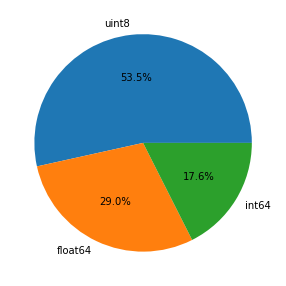

In [201]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(appl_train_new, True, False, True)

### Données manquantes

#### Proportions des données manquantes

In [28]:
# Valeurs manquantes du dataframe appl_train_new
df_nan_appl_train = get_missing_values(appl_train_new, True, False, True)

Valeurs manquantes : 8498545 NaN pour 75337500 données (11.28 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



* Parmi les variables importantes repérées lors de l'analyse exploratoire pour départager les non-défaillants des défaillants, la variable FLOORSMIN_AVG est celle qui a le plus de valeurs manquantes (67.85%).
* On fixera le seuil de suppression des variables ayant de nombreuses valeurs manquantes à 68%.

In [203]:
# Liste des variables ayant plus de 68% de valeurs manquantes
cols_nan_a_suppr = \
    df_nan_appl_train[df_nan_appl_train['% de valeurs manquantes'] > 68] \
    .index.to_list()
print(f'Nombre de variables à supprimer : {len(cols_nan_a_suppr)}')
cols_nan_a_suppr

Nombre de variables à supprimer : 9


['COMMONAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMONAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI']

In [204]:
# Suppression des variables avec un seuil de nan > 68%
appl_train_new.drop(columns=cols_nan_a_suppr, inplace=True)
# Taille : nombre de lignes/colonnes
nRow, nVar = appl_train_new.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307500 lignes et 236 variables.


**Variables quantitatives /Imputation par median**

In [206]:
# Variables quantitatives
cols_num = appl_train_new.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num

['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_B

In [207]:
# Variables quantitatives - imputation par médiane
# Nous imputerons donc les valeurs manquantes des variables quantitatives par la valeur médiane 
# de chacune de ces variables puisque nous avons découvert lors de l'analyse exploratoire qu'il y avait de nombreux outliers
nb_nan_appl_train_median = appl_train_new[cols_num].isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_appl_train_median}')
appl_train_new.fillna(appl_train_new[cols_num].median(), inplace=True)
# Vérification
nb_nan_appl_train_median = appl_train_new[cols_num].isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_appl_train_median}')

Nombre de nan avant imputation par median : 6582886
Nombre de nan après imputation par median : 0


In [208]:
corr_matr_train_new = appl_train_new.corr()
abs(corr_matr_train_new['TARGET']).sort_values(ascending=False)[:21]

TARGET                                               1.000000
EXT_SOURCE_2                                         0.160274
EXT_SOURCE_3                                         0.155906
EXT_SOURCE_1                                         0.098896
DAYS_BIRTH                                           0.078236
DAYS_EMPLOYED                                        0.063381
REGION_RATING_CLIENT_W_CITY                          0.060875
REGION_RATING_CLIENT                                 0.058882
DAYS_EMPLOYED_PERC                                   0.057553
NAME_INCOME_TYPE_Working                             0.057504
NAME_EDUCATION_TYPE_Higher education                 0.056578
DAYS_LAST_PHONE_CHANGE                               0.055228
CODE_GENDER                                          0.054729
DAYS_ID_PUBLISH                                      0.051455
REG_CITY_NOT_WORK_CITY                               0.050981
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049804
NAME_INC

In [209]:
# Préparation de la matrice de corrélation
# ---------------------------------------------------------------------
# Variables fortement corrélées : si le coef de Pearson est :
# > 0.8 ou < -0.8
# et inférieur à 1 ou > -1 (corrélée avec elle-même)
seuil = 0.8
# Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
# les corrélations positives et négatives séparément
corr = appl_train_new.corr().abs()
# On ne conserve que la partie supérieur à la diagonale pour n'avoir
# qu'une seule fois les corrélations prisent en compte (symétrie axiale)
corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                           .astype(np.bool))

<ipython-input-209-5768d785931d>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [210]:
# Variables avec un coef de Pearson > 0.8
cols_corr_a_supp = [var for var in corr_triangle.columns
                    if any(corr_triangle[var] > seuil)]
print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
for var in cols_corr_a_supp:
    print(var)

39 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT_W_CITY
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAREA_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAREA_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
NAME_CONTRACT_TYPE_Revolving loans
NAME_INCOME_TYPE_Pensioner
NAME_EDUCATION_TYPE_Secondary / secondary special
ORGANIZATION_TYPE_XNA
EMERGENCYSTATE_MODE_No
DAYS_EMPLOYED_PERC
INCOME_PER_PERSON


In [211]:
# Suppression des variables fortement corrélées
print(f'application_train_all : {appl_train_new.shape}')
appl_train_new.drop(columns=cols_corr_a_supp,  inplace=True)
print(f'application_train_cleaned : {appl_train_new.shape}')

application_train_all : (307500, 236)
application_train_cleaned : (307500, 197)


In [212]:
# Sauvegarde de application_train nettoyée, encodée, prête pour ML
appl_train_new.to_csv("appl_train_cleaned.csv", index=False)

In [213]:
appl_train_cleaned = pd.read_csv("appl_train_cleaned.csv")

In [214]:
appl_train_cleaned

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307495      456251       0            0             0                1   
307496      456252       0            1             0                0   
307497      456253       0            1             0                0   
307498      456254       1            1             0                0   
307499      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307495             0          157500.0    254700.0      27558.0   
307496             0           72000.0    269550.0      12001.5   
307497             0          153000.0    677664.0      29979.0   
307498             0          171000.0    370107.0      20205.0   
307499             0          157500.0    675000.0      49117.5   

        REGION_POPULATION_RELATIVE  ...  WALLSMATERIAL_MODE_Mixed  \
0                         0.018801  ...                         0   
1                         0.003541  ...                         0   
2                         0.010032  ...                         0   
3                         0.008019  ...                         0   
4                         0.028663  ...                         0   
...                            ...  ...                       ...   
307495                    0.032561  ...                         0   
307496                    0.025164  ...                         0   
307497                    0.005002  ...                         0   
307498                    0.005313  ...                         0   
307499                    0.046220  ...                         0   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                                   0                          0   
1                                   0                          0   
2                                   0                          0   
3                                   0                          0   
4                                   0                          0   
...                               ...                        ...   
307495                              0                          0   
307496                              0                          0   
307497                              0                          0   
307498                              0                          0   
307499                              0                          0   

        WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                              0                                1   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   
...                          ...                              ...   
307495                         0                                1   
307496                         0                                1   
307497                         1               

### <font color="#0000FF" id="section_1_3">1.3. Pré-processing "bureau.csv" & "bureau_balance.csv" + fusion</font>

<span style='background:PaleGreen'>**Description**</span>

- Le fichier **bureau.csv** comprend tous les **antécédents de crédit antérieurs du demandeur auprès d'institutions financières autres que le Home Credit Group**, qui ont été signalés par le bureau de crédit.
- Le fichier **bureau_balance.csv** est constitué du solde mensuel de chaque crédit pour chacun des crédits précédents que le demandeur a eu avec des institutions financières autres que Home Credit.

In [41]:
# Valeurs manquantes du dataframe bureau 
df_nan_bureau = get_missing_values(bureau, True, False, True)

Valeurs manquantes : 3939947 NaN pour 29179276 données (13.5 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                  int64
SK_ID_BUREAU                int64
CREDIT_ACTIVE              object
CREDIT_CURRENCY            object
DAYS_CREDIT                 int64
CREDIT_DAY_OVERDUE          int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG          int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE                object
DAYS_CREDIT_UPDATE          int64
AMT_ANNUITY               float64
dtype: object

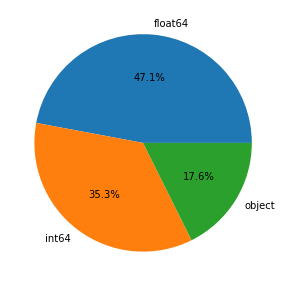

In [42]:
# Types des variables
get_types_variables(bureau, True, True, True)

In [43]:
# Valeurs manquantes du dataframe bureau_balance
df_nan_bureau_balance = get_missing_values(bureau_balance, True, False, True)

Valeurs manquantes : 0 NaN pour 81899775 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_BUREAU       int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

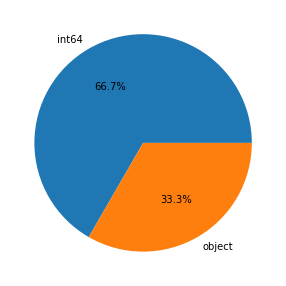

In [44]:
# Types des variables
get_types_variables(bureau_balance, True, True, True)

### Création variables métier / features engineering

In [216]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bureau_balance = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bureau_balance, bureau_balance_cat = one_hot_encoder(bureau_balance, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: réalisation des aggregations et jointure avec bureau.csv
    bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bureau_balance_cat:
        bureau_balance_aggregations[col] = ['mean']
    bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
    bureau_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bureau_balance_agg.columns.tolist()])
    bureau = bureau.join(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bureau_balance_agg
    gc.collect()
    
    # Bureau et bureau_balance features numériques = Variables METIERS
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau et bureau_balance features catégorielles
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bureau_balance_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Crédits actifs - utilisant uniquement des agrégations numériques
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Crédits fermés - utilisant uniquement des agrégations numériques
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [217]:
bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)
bureau_agg = bureau_agg.reset_index()
bureau_agg

SK_ID_CURR  BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  \
0           100001                 -1572                   -49   
1           100002                 -1437                  -103   
2           100003                 -2586                  -606   
3           100004                 -1326                  -408   
4           100005                  -373                   -62   
...            ...                   ...                   ...   
305806      456249                 -2713                  -483   
305807      456250                 -1002                  -760   
305808      456253                  -919                  -713   
305809      456254                 -1104                 -1104   
305810      456255                 -2337                  -363   

        BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  \
0                 -735.000000         240043.666667   
1                 -874.000000         186150.000000   
2                -1400.750000         827783.583333   
3                 -867.000000         421362.000000   
4                 -190.666667          26340.333333   
...                       ...                   ...   
305806           -1667.076923         407302.243590   
305807            -862.000000          15724.000000   
305808            -867.500000          10609.000000   
305809           -1104.000000                   NaN   
305810           -1089.454545         502786.672727   

        BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  \
0                            -1329.0                        1778.0   
1                            -1072.0                         780.0   
2                            -2434.0                        1216.0   
3                             -595.0                        -382.0   
4                             -128.0                        1324.0   
...                              ...                           ...   
305806                       -2499.0                        1363.0   
305807                        -272.0                        2340.0   
305808                        -189.0                        1113.0   
305809                        -859.0                        -859.0   
305810                       -1243.0                       27320.0   

        BURO_DAYS_CREDIT_ENDDATE_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  \
0                           82.428571                    -93.142857   
1                         -349.000000                   -499.875000   
2                         -544.500000                   -816.000000   
3                         -488.500000                   -532.000000   
4                          439.333333                    -54.333333   
...                               ...                           ...   
305806                   -1232.333333                  -1064.538462   
305807                    1288.333333                    -60.333333   
305808                     280.500000                   -253.250000   
305809                    -859.000000                   -401.000000   
305810                    3231.272727                   -531.090909   

        BURO_CREDIT_DAY_OVERDUE_MAX  ...  CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN  \
0                                 0  ...                                 0.0   
1                                 0  ...                                 0.0   
2                                 0  ...                                 0.0   
3                                 0  ...                                 0.0   
4                                 0  ...                                 0.0   
...                             ...  ...                                 ...   
305806                            0  ...                                 0.0   
305807                            0  ...                                 0.0   
305808                            0  ...                                 0.0   
305809                            0  ...                    

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                           int64
BURO_DAYS_CREDIT_MIN                 int64
BURO_DAYS_CREDIT_MAX                 int64
BURO_DAYS_CREDIT_MEAN              float64
BURO_DAYS_CREDIT_VAR               float64
                                    ...   
CLOSED_CNT_CREDIT_PROLONG_SUM      float64
CLOSED_MONTHS_BALANCE_MIN_MIN      float64
CLOSED_MONTHS_BALANCE_MAX_MAX      float64
CLOSED_MONTHS_BALANCE_SIZE_MEAN    float64
CLOSED_MONTHS_BALANCE_SIZE_SUM     float64
Length: 117, dtype: object

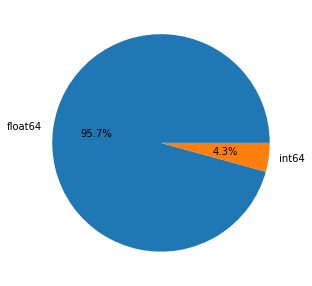

In [48]:
# Types des variables
get_types_variables(bureau_agg, True, True, True)

In [49]:
# Valeurs manquantes du dataframe appl_train
df_nan_bureau_agg = get_missing_values(bureau_agg, True, False, True)

Valeurs manquantes : 7152780 NaN pour 35779887 données (19.99 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



## Fusion avec train_cleaned et nettoyage variables fortement correlées

In [219]:
# jointure appl_train (application_train_cleaned) et bureau_agg (bureau_and_balance)
joint_1 = pd.merge(appl_train_cleaned, bureau_agg, how='left', on='SK_ID_CURR')
joint_1.shape

(307500, 313)

In [220]:
# -- GESTION DES VARIABLES FORTEMENT COLINEAIRES

def suppr_var_colineaire(dataframe, seuil=0.8):
    '''
    Récupération de la liste des variables fortement corrélées supérieur
    au seuil transmis.
    Parameters
    ----------
    dataframe : dataframe à analyser, obligatoire.
    seuil : le seuil de colinéarité entre les variables (0.8 par défaut).
    Returns
    -------
    cols_corr_a_supp : liste des variables à supprimer.
    '''
    
    # Matrice de corrélation avec valeur absolue pour ne pas avoir à gérer
    # les corrélations positives et négatives séparément
    corr = dataframe.corr().abs()
    # On ne conserve que la partie supérieur à la diagonale pour n'avoir
    # qu'une seule fois les corrélations prisent en compte (symétrie axiale)
    corr_triangle = corr.where(np.triu(np.ones(corr.shape), k=1)
                               .astype(np.bool))
    
    # Variables avec un coef de Pearson > 0.8
    cols_corr_a_supp = [var for var in corr_triangle.columns
                        if any(corr_triangle[var] > seuil)]
    print(f'{len(cols_corr_a_supp)} variables fortement corrélées à supprimer :\n')
    for var in cols_corr_a_supp:
        print(var)
        
    return cols_corr_a_supp

In [221]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_1 = suppr_var_colineaire(joint_1)

40 variables fortement corrélées à supprimer :

BURO_DAYS_CREDIT_MEAN
BURO_AMT_CREDIT_SUM_MEAN
BURO_AMT_CREDIT_SUM_SUM
BURO_AMT_CREDIT_SUM_DEBT_SUM
BURO_MONTHS_BALANCE_MIN_MIN
BURO_MONTHS_BALANCE_SIZE_MEAN
BURO_CREDIT_ACTIVE_Closed_MEAN
BURO_CREDIT_CURRENCY_currency 2_MEAN
BURO_CREDIT_TYPE_Credit card_MEAN
ACTIVE_DAYS_CREDIT_MAX
ACTIVE_DAYS_CREDIT_MEAN
ACTIVE_DAYS_CREDIT_ENDDATE_MAX
ACTIVE_DAYS_CREDIT_ENDDATE_MEAN
ACTIVE_CREDIT_DAY_OVERDUE_MAX
ACTIVE_CREDIT_DAY_OVERDUE_MEAN
ACTIVE_AMT_CREDIT_SUM_MAX
ACTIVE_AMT_CREDIT_SUM_MEAN
ACTIVE_AMT_CREDIT_SUM_SUM
ACTIVE_AMT_CREDIT_SUM_DEBT_MAX
ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM
ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN
ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM
ACTIVE_AMT_ANNUITY_MEAN
ACTIVE_CNT_CREDIT_PROLONG_SUM
ACTIVE_MONTHS_BALANCE_MIN_MIN
ACTIVE_MONTHS_BALANCE_SIZE_MEAN
CLOSED_DAYS_CREDIT_MIN
CLOSED_DAYS_CREDIT_MEAN
CLOSED_DAYS_CREDIT_ENDDATE_MIN
CLOSED_DAYS_CREDIT_UPDATE_MEAN
CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN
CLOSED_AMT_CREDIT_SUM_M

<ipython-input-220-ce77af89c50c>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [222]:
# Suppression des variables fortement corrélées du joint_1
joint_1 = joint_1.drop(columns=var_corr_joint_1)
print(f'joint_1 : {joint_1.shape}')

joint_1 : (307500, 273)


In [54]:
# Valeurs manquantes du dataframe joint_1
df_nan_joint_1 = get_missing_values(joint_1, True, False, True)

Valeurs manquantes : 7207861 NaN pour 83947500 données (8.59 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



### Imputation par médiane des valeurs Nan

In [224]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_1_median}')
joint_1.fillna(joint_1.median(), inplace=True)
# Vérification
nb_nan_joint_1_median = joint_1.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_1_median}')

Nombre de nan avant imputation par median : 0
Nombre de nan après imputation par median : 0


In [225]:
joint_1.shape

(307500, 273)

In [226]:
# Sauvegarde de joint_1 nettoyée, encodée, prête pour ML
joint_1.to_csv("joint_1_cleaned.csv", index=False)

In [227]:
joint_1=pd.read_csv("joint_1_cleaned.csv")

### <font color="#0000FF" id="section_1_4">1.4. Pré-processing "previous_applications.csv" + fusion</font>

# Preprocess previous_applications.csv

<span style='background:PaleGreen'>**Description**</span>

- Le fichier **previous_application.csv** contient les données statiques du précédent prêt que le demmdeur a eu avec Home Credit. 

In [59]:
# Valeurs manquantes du dataframe bureau 
df_nan_previous_appl = get_missing_values(previous_appl, True, False, True)

Valeurs manquantes : 11109336 NaN pour 61797918 données (17.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                       int64
SK_ID_CURR                       int64
NAME_CONTRACT_TYPE              object
AMT_ANNUITY                    float64
AMT_APPLICATION                float64
AMT_CREDIT                     float64
AMT_DOWN_PAYMENT               float64
AMT_GOODS_PRICE                float64
WEEKDAY_APPR_PROCESS_START      object
HOUR_APPR_PROCESS_START          int64
FLAG_LAST_APPL_PER_CONTRACT     object
NFLAG_LAST_APPL_IN_DAY           int64
RATE_DOWN_PAYMENT              float64
RATE_INTEREST_PRIMARY          float64
RATE_INTEREST_PRIVILEGED       float64
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
DAYS_DECISION                    int64
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE                 object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  object
NAME_PRODUCT_TYPE               object
CHANNEL_TYPE             

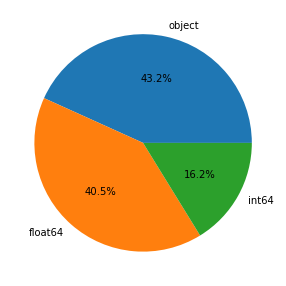

In [60]:
# Types des variables
get_types_variables(previous_appl, True, True, True)

### Variables métier

In [229]:
def previous_applications(num_rows = None, nan_as_category = True):
    previous_appl = pd.read_csv('previous_application.csv', nrows = num_rows)
    previous_appl, cat_cols = one_hot_encoder(previous_appl, nan_as_category= True)
    # Suppression valeurs aberantes Days 365.243 values (1000 ans) -> nan     
    previous_appl['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    previous_appl['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Creation variable métier = feature: montant de crédit demandé lors de la demande précédente \
    # Montant final du crédit sur la demande précédente
    previous_appl['APP_CREDIT_PERC'] = previous_appl['AMT_APPLICATION'] / previous_appl['AMT_CREDIT']
    
    # Ajout des variables de statistiques
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications variables catégorielles
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = previous_appl.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = previous_appl[previous_appl['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = previous_appl[previous_appl['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, previous_appl
    gc.collect()
    return prev_agg

In [230]:
prev_agg = previous_applications(num_rows = None, nan_as_category = True)
prev_agg = prev_agg.reset_index()
prev_agg

SK_ID_CURR  PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  \
0           100001              3951.000              3951.000   
1           100002              9251.775              9251.775   
2           100003              6737.310             98356.995   
3           100004              5357.250              5357.250   
4           100005              4813.200              4813.200   
...            ...                   ...                   ...   
338852      456251              6605.910              6605.910   
338853      456252             10074.465             10074.465   
338854      456253              3973.095              5567.715   
338855      456254              2296.440             19065.825   
338856      456255              2250.000             54022.140   

        PREV_AMT_ANNUITY_MEAN  PREV_AMT_APPLICATION_MIN  \
0                 3951.000000                   24835.5   
1                 9251.775000                  179055.0   
2                56553.990000                   68809.5   
3                 5357.250000                   24282.0   
4                 4813.200000                       0.0   
...                       ...                       ...   
338852            6605.910000                   40455.0   
338853           10074.465000                   57595.5   
338854            4770.405000                   19413.0   
338855           10681.132500                   18846.0   
338856           20775.391875                   45000.0   

        PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_MEAN  \
0                        24835.5                  24835.500   
1                       179055.0                 179055.000   
2                       900000.0                 435436.500   
3                        24282.0                  24282.000   
4                        44617.5                  22308.750   
...                          ...                        ...   
338852                   40455.0                  40455.000   
338853                   57595.5                  57595.500   
338854                   28912.5                  24162.750   
338855                  223789.5                 121317.750   
338856                 1170000.0                 362770.875   

        PREV_AMT_CREDIT_MIN  PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  ...  \
0                   23787.0              23787.0              23787.00  ...   
1                  179055.0             179055.0             179055.00  ...   
2                   68053.5            1035882.0             484191.00  ...   
3                   20106.0              20106.0              20106.00  ...   
4                       0.0              40153.5              20076.75  ...   
...                     ...                  ...                   ...  ...   
338852              40455.0              40455.0              40455.00  ...   
338853              56821.5              56821.5              56821.50  ...   
338854              13945.5              27306.0              20625.75  ...   
338855              21456.0             247423.5             134439.75  ...   
338856              45000.0            1271929.5             424431.00  ...   

        REFUSED_HOUR_APPR_PROCESS_START_MAX  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
338852                                  NaN   
338853                                  NaN   
338854                                  NaN   
338855                                  NaN   
338856                                 14.0   

        REFUSED_HOUR_APPR_PROCESS_START_MEAN  REFUSED_RATE_DOWN_PAYMENT_MIN  \
0                                        NaN                            NaN   
1                                        NaN                            NaN  

In [64]:
# Valeurs manquantes du dataframe prev_agg 
df_nan_prev_agg = get_missing_values(prev_agg, True, False, True)

Valeurs manquantes : 7608407 NaN pour 84714250 données (8.98 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



## Fusion avec train_cleaned et nettoyage variables fortement correlées

In [231]:
# Fusion joint_1 (application_train_cleaned) et prev_agg 
joint_2 = pd.merge(joint_1, prev_agg, how='left', on='SK_ID_CURR')
joint_2.shape

(307500, 522)

In [232]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_2 = suppr_var_colineaire(joint_2)

81 variables fortement corrélées à supprimer :

PREV_AMT_ANNUITY_MEAN
PREV_AMT_APPLICATION_MAX
PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_CREDIT_MEAN
PREV_AMT_DOWN_PAYMENT_MEAN
PREV_AMT_GOODS_PRICE_MAX
PREV_AMT_GOODS_PRICE_MEAN
PREV_HOUR_APPR_PROCESS_START_MEAN
PREV_RATE_DOWN_PAYMENT_MEAN
PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN
PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN
PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN
PREV_NAME_PAYMENT_TYPE_XNA_MEAN
PREV_CODE_REJECT_REASON_CLIENT_MEAN
PREV_CODE_REJECT_REASON_XAP_MEAN
PREV_NAME_CLIENT_TYPE_Repeater_MEAN
PREV_NAME_GOODS_CATEGORY_XNA_MEAN
PREV_NAME_PORTFOLIO_Cards_MEAN
PREV_NAME_PORTFOLIO_Cash_MEAN
PREV_NAME_PORTFOLIO_POS_MEAN
PREV_NAME_PORTFOLIO_XNA_MEAN
PREV_NAME_PRODUCT_TYPE_XNA_MEAN
PREV_CHANNEL_TYPE_Car dealer_MEAN
PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN
PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN
PREV_NAME_SELLER_INDUSTRY_XNA_MEAN
PREV_NAME_YIELD_GROUP_XNA_MEAN

<ipython-input-220-ce77af89c50c>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [233]:
# Suppression des variables fortement corrélées du joint_2
joint_2 = joint_2.drop(columns=var_corr_joint_2)
print(f'joint_2 : {joint_2.shape}')

joint_2 : (307500, 441)


In [68]:
# Valeurs manquantes du dataframe joint_2
df_nan_joint_2 = get_missing_values(joint_2, True, False, True)

Valeurs manquantes : 5376562 NaN pour 135607500 données (3.96 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [234]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_2_median}')
joint_2.fillna(joint_2.median(), inplace=True)
# Vérification
nb_nan_joint_2_median = joint_2.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_2_median}')

Nombre de nan avant imputation par median : 5376562
Nombre de nan après imputation par median : 0


In [235]:
joint_2.shape

(307500, 441)

In [71]:
# Sauvegarde de joint_2 nettoyée, encodée, prête pour ML
joint_2.to_csv("joint_2_cleaned.csv", index=False)

In [72]:
joint_2=pd.read_csv("joint_2_cleaned.csv")

### <font color="#0000FF" id="section_1_5">1.5. Pré-processing "POS_CASH_balance.csv" + fusion</font>

In [74]:
# Valeurs manquantes du dataframe pos_cash_balance 
df_nan_pos_cash_balance = get_missing_values(pos_cash_balance, True, False, True)

Valeurs manquantes : 52158 NaN pour 80010864 données (0.07 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                 int64
SK_ID_CURR                 int64
MONTHS_BALANCE             int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS      object
SK_DPD                     int64
SK_DPD_DEF                 int64
dtype: object

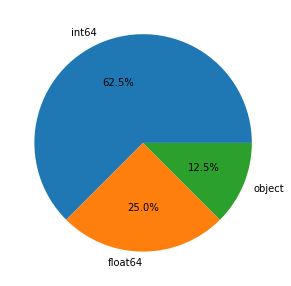

In [75]:
# Types des variables
get_types_variables(pos_cash_balance, True, True, True)

In [76]:
def pos_cash(num_rows = None, nan_as_category = True):
    pos_cash_balance = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos_cash_balance, cat_cols = one_hot_encoder(pos_cash_balance, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos_cash_balance.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos_cash_balance.groupby('SK_ID_CURR').size()
    del pos_cash_balance
    gc.collect()
    return pos_agg

In [77]:
pos_agg = pos_cash(num_rows = None, nan_as_category = True)
pos_agg = pos_agg.reset_index()
pos_agg

SK_ID_CURR  POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
0           100001                     -53               -72.555556   
1           100002                      -1               -10.000000   
2           100003                     -18               -43.785714   
3           100004                     -24               -25.500000   
4           100005                     -15               -20.000000   
...            ...                     ...                      ...   
337247      456251                      -1                -5.000000   
337248      456252                     -76               -79.000000   
337249      456253                     -57               -79.235294   
337250      456254                      -1                -5.550000   
337251      456255                      -2               -16.408451   

        POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
0                             9               7         0.777778   
1                            19               0         0.000000   
2                            28               0         0.000000   
3                             4               0         0.000000   
4                            11               0         0.000000   
...                         ...             ...              ...   
337247                        9               0         0.000000   
337248                        7               0         0.000000   
337249                       17               5         0.294118   
337250                       20               0         0.000000   
337251                       71               5         0.070423   

        POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
0                        7             0.777778   
1                        0             0.000000   
2                        0             0.000000   
3                        0             0.000000   
4                        0             0.000000   
...                    ...                  ...   
337247                   0             0.000000   
337248                   0             0.000000   
337249                   5             0.294118   
337250                   0             0.000000   
337251                   5             0.070423   

        POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                                   0.777778   
1                                   1.000000   
2                                   0.928571   
3                                   0.750000   
4                                   0.818182   
...                                      ...   
337247                              0.777778   
337248                              0.857143   
337249                              0.882353   
337250                              1.000000   
337251                              0.915493   

        POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
337247                                           0.0   
337248                                           0.0   
337249                                           0.0   
337250                                           0.0   
337251                                           0.0   

        POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
337247                                     0.0   
337248                                     0.0   
337249                   

In [78]:
# Valeurs manquantes du dataframe appl_train
df_nan_pos_agg = get_missing_values(pos_agg, True, False, True)

Valeurs manquantes : 0 NaN pour 6407788 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



#### Fusion avec train_cleaned et nettoyage variables fortement correlées

In [79]:
# Fusion joint_2 (application_train_cleaned) et pos_agg
joint_3 = pd.merge(joint_2, pos_agg, how='left', on='SK_ID_CURR')
joint_3.shape

(307500, 459)

In [80]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_3 = suppr_var_colineaire(joint_3)

6 variables fortement corrélées à supprimer :

REFUSED_RATE_DOWN_PAYMENT_MAX
POS_MONTHS_BALANCE_MEAN
POS_SK_DPD_MEAN
POS_SK_DPD_DEF_MEAN
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_COUNT


<ipython-input-51-ce77af89c50c>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [81]:
# Suppression des variables fortement corrélées du joint_3
joint_3 = joint_3.drop(columns=var_corr_joint_3)
print(f'joint_3 : {joint_3.shape}')

joint_3 : (307500, 453)


In [82]:
# Valeurs manquantes du dataframe joint_3
df_nan_joint_3 = get_missing_values(joint_3, True, False, True)

Valeurs manquantes : 234806 NaN pour 139297500 données (0.17 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [83]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_3_median}')
joint_3.fillna(joint_3.median(), inplace=True)
# Vérification
nb_nan_joint_3_median = joint_3.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_3_median}')

Nombre de nan avant imputation par median : 234806
Nombre de nan après imputation par median : 0


In [84]:
joint_3.shape

(307500, 453)

In [85]:
# Sauvegarde de joint_3 nettoyée, encodée, prête pour ML
joint_3.to_csv("joint_3_cleaned.csv", index=False)

In [86]:
joint_3=pd.read_csv("joint_3_cleaned.csv")

### <font color="#0000FF" id="section_1_6">1.6. Pré-processing "installments_payments.csv" + fusion</font>

**Présentation**

**installments_payments.csv** 
<ul style='text-align: justify;'><li>Historique des remboursements pour les crédits précédemment déboursés dans Home Credit liés aux prêts de notre échantillon. </li> <li>  Il y a a) une ligne pour chaque paiement qui a été effectué plus b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'un versement OU à un versement correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon.</li></ul> 

In [87]:
# Valeurs manquantes du dataframe installm_paym 
df_nan_installm_paym = get_missing_values(installm_paym, True, False, True)

Valeurs manquantes : 5810 NaN pour 108843208 données (0.01 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                  int64
SK_ID_CURR                  int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER       int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtype: object

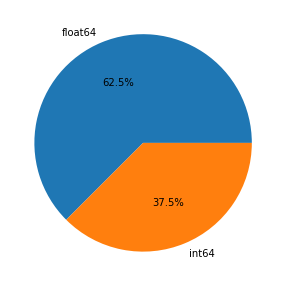

In [88]:
# Types des variables
get_types_variables(installm_paym, True, True, True)

### Variables métier

In [89]:
def installments_payments(num_rows = None, nan_as_category = True):
    installm_paym = pd.read_csv('installments_payments.csv', nrows = num_rows)
    installm_paym, cat_cols = one_hot_encoder(installm_paym, nan_as_category= True)
   
    # Variables METIERS :
    # Percentage and difference paid in each installment (amount paid and installment value)
    installm_paym['PAYMENT_PERC'] = installm_paym['AMT_PAYMENT'] / installm_paym['AMT_INSTALMENT']
    installm_paym['PAYMENT_DIFF'] = installm_paym['AMT_INSTALMENT'] - installm_paym['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    installm_paym['DPD'] = installm_paym['DAYS_ENTRY_PAYMENT'] - installm_paym['DAYS_INSTALMENT']
    installm_paym['DBD'] = installm_paym['DAYS_INSTALMENT'] - installm_paym['DAYS_ENTRY_PAYMENT']
    installm_paym['DPD'] = installm_paym['DPD'].apply(lambda x: x if x > 0 else 0)
    installm_paym['DBD'] = installm_paym['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = installm_paym.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = installm_paym.groupby('SK_ID_CURR').size()
    del installm_paym
    gc.collect()
    return ins_agg

In [90]:
ins_agg = installments_payments(num_rows = None, nan_as_category = True)
ins_agg = ins_agg.reset_index()
ins_agg

SK_ID_CURR  INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
0           100001                                      2            11.0   
1           100002                                      2             0.0   
2           100003                                      2             0.0   
3           100004                                      2             0.0   
4           100005                                      2             1.0   
...            ...                                    ...             ...   
339582      456251                                      2             0.0   
339583      456252                                      1             3.0   
339584      456253                                      1             9.0   
339585      456254                                      1             0.0   
339586      456255                                      4             7.0   

        INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
0              1.571429            11.0            36.0         8.857143   
1              0.000000             0.0            31.0        20.421053   
2              0.000000             0.0            14.0         7.160000   
3              0.000000             0.0            11.0         7.666667   
4              0.111111             1.0            37.0        23.666667   
...                 ...             ...             ...              ...   
339582         0.000000             0.0            46.0        36.285714   
339583         0.500000             3.0            11.0         3.333333   
339584         0.642857             9.0            51.0        15.142857   
339585         0.000000             0.0            31.0        19.000000   
339586         0.702703            52.0            35.0         8.770270   

        INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
0                 62.0                  1.00000                  1.000000   
1                388.0                  1.00000                  1.000000   
2                179.0                  1.00000                  1.000000   
3                 23.0                  1.00000                  1.000000   
4                213.0                  1.00000                  1.000000   
...                ...                      ...                       ...   
339582           254.0                  1.00000                  1.000000   
339583            20.0                  1.00000                  1.000000   
339584           212.0                  1.00000                  0.928571   
339585           361.0                  1.00000                  1.000000   
339586           649.0                 12.38847                  1.033463   

        ...  INSTAL_AMT_INSTALMENT_MEAN  INSTAL_AMT_INSTALMENT_SUM  \
0       ...                 5885.132143                  41195.925   
1       ...                11559.247105                 219625.695   
2       ...                64754.586000                1618864.650   
3       ...                 7096.155000                  21288.465   
4       ...                 6240.205000                  56161.845   
...     ...                         ...                        ...   
339582  ...                 7492.924286                  52450.470   
339583  ...                10069.867500                  60419.205   
339584  ...                 4399.707857                  61595.910   
339585  ...                10239.832895                 194556.825   
339586  ...                41464.713649                3068388.810   

        INSTAL_AMT_PAYMENT_MIN  INSTAL_AMT_PAYMENT_MAX  \
0                     3951.000               17397.900   
1                     9251.775               53093.745   
2                     6662.970              560835.360   
3                     5357.250               10573.965   
4                     4813.200               17656.245   
...                        ...                     ...  

In [91]:
# Valeurs manquantes du dataframe appl_train
df_nan_ins_agg = get_missing_values(ins_agg, True, False, True)

Valeurs manquantes : 2092 NaN pour 9168849 données (0.02 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



### Fusion avec train_cleaned et nettoyage variables fortement correlées

In [92]:
# jointure joint_3 (application_train_cleaned) et ins_agg
joint_4 = pd.merge(joint_3, ins_agg, how='left', on='SK_ID_CURR')
joint_4.shape

(307500, 479)

In [93]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_4 = suppr_var_colineaire(joint_4)

7 variables fortement corrélées à supprimer :

INSTAL_PAYMENT_PERC_SUM
INSTAL_PAYMENT_PERC_VAR
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_COUNT


<ipython-input-51-ce77af89c50c>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [94]:
# Suppression des variables fortement corrélées du joint_4
joint_4 = joint_4.drop(columns=var_corr_joint_4)
print(f'joint_4 : {joint_4.shape}')

joint_4 : (307500, 472)


In [95]:
# Valeurs manquantes du dataframe joint_4
df_nan_joint_4 = get_missing_values(joint_4, True, False, True)

Valeurs manquantes : 302159 NaN pour 145140000 données (0.21 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [96]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_4_median}')
joint_4.fillna(joint_4.median(), inplace=True)
# Vérification
nb_nan_joint_4_median = joint_4.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_4_median}')

Nombre de nan avant imputation par median : 302159
Nombre de nan après imputation par median : 0


In [97]:
joint_4.shape

(307500, 472)

In [98]:
# Sauvegarde de joint_4 nettoyée, encodée, prête pour ML
joint_4.to_csv("joint_4_cleaned.csv", index=False)

In [99]:
joint_4=pd.read_csv("joint_4_cleaned.csv")

### <font color="#0000FF" id="section_1_7">1.7. Pré-processing "credit_card_balance.csv" + fusion</font>

**Présentation**

**credit_card_balance.csv** 
<ul style='text-align: justify;'><li>Instantanés des soldes mensuels des cartes de crédit précédentes que le demandeur possède chez Home Credit. </li> <li>  Ce tableau comporte une ligne pour chaque mois de l'historique de chaque crédit précédent dans le Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau comporte (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.</li></ul>

In [100]:
# Valeurs manquantes du dataframe credit_card_balance 
df_nan_credit_card_balance = get_missing_values(credit_card_balance, True, False, True)

Valeurs manquantes : 5877356 NaN pour 88327176 données (6.65 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_PREV                      int64
SK_ID_CURR                      int64
MONTHS_BALANCE                  int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL         int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT            int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS           object
SK_DPD                          int64
SK_DPD_DEF                      int64
dtype: object

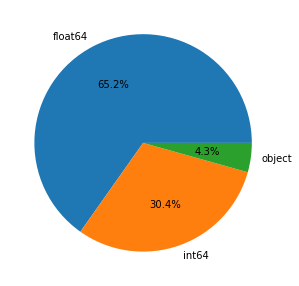

In [101]:
# Types des variables
get_types_variables(credit_card_balance, True, True, True)

### Variables métiers

In [102]:
def credit_card_balance(num_rows = None, nan_as_category = True):
    credit_card_balance = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    credit_card_balance, cat_cols = one_hot_encoder(credit_card_balance, nan_as_category= True)
    # General aggregations
    credit_card_balance.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()
    del credit_card_balance
    gc.collect()
    return cc_agg

In [103]:
cc_agg = credit_card_balance(num_rows = None, nan_as_category = True)
cc_agg = cc_agg.reset_index()
cc_agg

SK_ID_CURR  CC_MONTHS_BALANCE_MIN  CC_MONTHS_BALANCE_MAX  \
0           100006                     -6                     -1   
1           100011                    -75                     -2   
2           100013                    -96                     -1   
3           100021                    -18                     -2   
4           100023                    -11                     -4   
...            ...                    ...                    ...   
103553      456244                    -41                     -1   
103554      456246                     -9                     -2   
103555      456247                    -96                     -2   
103556      456248                    -24                     -2   
103557      456250                    -12                     -1   

        CC_MONTHS_BALANCE_MEAN  CC_MONTHS_BALANCE_SUM  CC_MONTHS_BALANCE_VAR  \
0                         -3.5                    -21                    3.5   
1                        -38.5                  -2849                  462.5   
2                        -48.5                  -4656                  776.0   
3                        -10.0                   -170                   25.5   
4                         -7.5                    -60                    6.0   
...                        ...                    ...                    ...   
103553                   -21.0                   -861                  143.5   
103554                    -5.5                    -44                    6.0   
103555                   -49.0                  -4655                  760.0   
103556                   -13.0                   -299                   46.0   
103557                    -6.5                    -78                   13.0   

        CC_AMT_BALANCE_MIN  CC_AMT_BALANCE_MAX  CC_AMT_BALANCE_MEAN  \
0                    0.000               0.000             0.000000   
1                    0.000          189000.000         54482.111149   
2                    0.000          161420.220         18159.919219   
3                    0.000               0.000             0.000000   
4                    0.000               0.000             0.000000   
...                    ...                 ...                  ...   
103553               0.000          453627.675        131834.730732   
103554               0.000           43490.115         13136.731875   
103555               0.000          190202.130         23216.396211   
103556               0.000               0.000             0.000000   
103557          153832.725          200208.915        173589.326250   

        CC_AMT_BALANCE_SUM  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                    0.000  ...                                   0   
1              4031676.225  ...                                   0   
2              1743352.245  ...                                   0   
3                    0.000  ...                                   0   
4                    0.000  ...                                   0   
...                    ...  ...                                 ...   
103553         5405223.960  ...                                   0   
103554          105093.855  ...                                   0   
103555         2205557.640  ...                                   0   
103556               0.000  ...                                   0   
103557         2083071.915  ...                                   0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
103553                                  0.0   
103554                                  0.0   
103555                                  0.0   
103556                                  0.0   
103557 

In [104]:
# Valeurs manquantes du dataframe credit_card_balance.csv
df_nan_cc_agg = get_missing_values(cc_agg, True, False, True)

Valeurs manquantes : 896550 NaN pour 14705236 données (6.1 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



#### Fusion avec train_cleaned et nettoyage variables fortement correlées

In [105]:
# jointure joint_4 (application_train_cleaned) et cc_agg
joint_5 = pd.merge(joint_4, cc_agg, how='left', on='SK_ID_CURR')
joint_5.shape

(307500, 613)

In [106]:
# Gestion des variables fortement corrélées (seuil=0.8) à supprimer suite au fusion 
var_corr_joint_5 = suppr_var_colineaire(joint_5)

72 variables fortement corrélées à supprimer :

CC_MONTHS_BALANCE_MIN
CC_MONTHS_BALANCE_MEAN
CC_MONTHS_BALANCE_SUM
CC_MONTHS_BALANCE_VAR
CC_AMT_BALANCE_MEAN
CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN
CC_AMT_DRAWINGS_CURRENT_MAX
CC_AMT_DRAWINGS_OTHER_CURRENT_SUM
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR
CC_AMT_DRAWINGS_POS_CURRENT_SUM
CC_AMT_INST_MIN_REGULARITY_MAX
CC_AMT_INST_MIN_REGULARITY_MEAN
CC_AMT_INST_MIN_REGULARITY_SUM
CC_AMT_INST_MIN_REGULARITY_VAR
CC_AMT_PAYMENT_CURRENT_MEAN
CC_AMT_PAYMENT_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_MAX
CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM
CC_AMT_PAYMENT_TOTAL_CURRENT_VAR
CC_AMT_RECEIVABLE_PRINCIPAL_MIN
CC_AMT_RECEIVABLE_PRINCIPAL_MAX
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN
CC_AMT_RECEIVABLE_PRINCIPAL_SUM
CC_AMT_RECEIVABLE_PRINCIPAL_VAR
CC_AMT_RECIVABLE_MIN
CC_AMT_RECIVABLE_MAX
CC_AMT_RECIVABLE_MEAN
CC_AMT_RECIVABLE_SUM
CC_AMT_RECIVABLE_VAR
CC_AMT_TOTAL_RECEIVABLE_MIN
CC_AMT_TOTAL_RECEIVABLE_MAX
CC_AMT_TOTAL_RECEIVABLE_MEAN
CC_AMT_TOTAL_RECEI

<ipython-input-51-ce77af89c50c>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.bool))


In [107]:
# Suppression des variables fortement corrélées du joint_5
joint_5 = joint_5.drop(columns=var_corr_joint_5)
print(f'joint_5 : {joint_5.shape}')

joint_5 : (307500, 541)


In [108]:
# Valeurs manquantes du dataframe joint_5
df_nan_joint_5 = get_missing_values(joint_5, True, False, True)

Valeurs manquantes : 15767797 NaN pour 166357500 données (9.48 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



In [109]:
# Variables quantitatives - imputation par médiane
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_joint_5_median}')
joint_5.fillna(joint_5.median(), inplace=True)
# Vérification
nb_nan_joint_5_median = joint_5.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_joint_5_median}')

Nombre de nan avant imputation par median : 15767797
Nombre de nan après imputation par median : 0


In [110]:
# TRES IMPORTANT : il y a un CARACTER SPECIAL dans le nom de colonne (importé par JSON) que le modele n'aime pas
# La CORRECTION est appliquée
import re
joint_5 = joint_5.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [111]:
joint_5.shape

(307500, 541)

In [112]:
# Sauvegarde de joint_5 nettoyée, encodée, prête pour ML
joint_5.to_csv("df_train_final.csv", index=False)

### <font color="#0000FF" id="section_1_8">1.8. Création du Data frame final</font>

#### Saved for work: "df_train_final.csv" ==> dataframe: df_train

In [164]:
df_train = pd.read_csv("df_train_final.csv")

#### Attention, retour sur le nettoyage car valeurs infinis !

In [165]:
# Pour nettoyer les valeurs infini
df_train = df_train.replace([np.inf, -np.inf], np.nan)
df_train = df_train.dropna()
df_train = df_train.reset_index()

In [166]:
df_train = df_train.drop(columns=['index'])

In [167]:
df_train

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           100002       1            0             0                0   
1           100003       0            1             0                1   
2           100004       0            0             1                0   
3           100006       0            1             0                0   
4           100007       0            0             0                0   
...            ...     ...          ...           ...              ...   
307476      456251       0            0             0                1   
307477      456252       0            1             0                0   
307478      456253       0            1             0                0   
307479      456254       1            1             0                0   
307480      456255       0            1             0                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307476             0          157500.0    254700.0      27558.0   
307477             0           72000.0    269550.0      12001.5   
307478             0          153000.0    677664.0      29979.0   
307479             0          171000.0    370107.0      20205.0   
307480             0          157500.0    675000.0      49117.5   

        REGION_POPULATION_RELATIVE  ...  \
0                         0.018801  ...   
1                         0.003541  ...   
2                         0.010032  ...   
3                         0.008019  ...   
4                         0.028663  ...   
...                            ...  ...   
307476                    0.032561  ...   
307477                    0.025164  ...   
307478                    0.005002  ...   
307479                    0.005313  ...   
307480                    0.046220  ...   

        CC_NAME_CONTRACT_STATUS_Sentproposal_MAX  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
307476                                       0.0   
307477                                       0.0   
307478                                       0.0   
307479                                       0.0   
307480                                       0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MIN  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
307476                                 0.0   
307477                                 0.0   
307478                                 0.0   
307479                                 0.0   
307480                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
307476                                 0.0   
307477                                 0.0   
307478                                 0.0   
307479                                 0.0   
307480                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                  

-------------------------------------------------------------
Type de variable pour chacune des variables



SK_ID_CURR                            int64
TARGET                                int64
CODE_GENDER                           int64
FLAG_OWN_CAR                          int64
FLAG_OWN_REALTY                       int64
                                     ...   
CC_NAME_CONTRACT_STATUS_nan_MIN     float64
CC_NAME_CONTRACT_STATUS_nan_MAX     float64
CC_NAME_CONTRACT_STATUS_nan_MEAN    float64
CC_NAME_CONTRACT_STATUS_nan_SUM     float64
CC_NAME_CONTRACT_STATUS_nan_VAR     float64
Length: 541, dtype: object

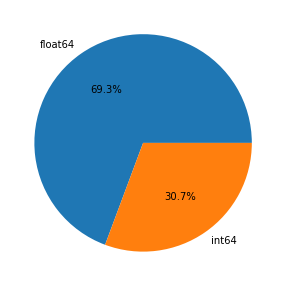

In [169]:
# Types des variables
rcParams['figure.figsize'] = 5, 5
get_types_variables(df_train, True, False, True)

#### Re-Savuvegarde du fichier nettoyer des valeurs infinis: "df_train_final.csv" ==> dataframe: df_train

## Dataframe final sauvegardé dans le fichier "df_train_final.csv" pour la suite du projet

In [170]:
df_train.to_csv("df_train_final.csv", index=False)

In [171]:
df_train = pd.read_csv("df_train_final.csv")

In [172]:
df_train.shape

(307481, 541)

In [173]:
df_train['TARGET'].value_counts()

0    282660
1     24821
Name: TARGET, dtype: int64

## <font color="#0000FF" id="section_2">2. Features importance selection</font>

### <font color="#0000FF" id="section_2_1">2.1. Features importance globale selection pour modélisation</font>

- Extrait du Kernel Kaggle : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
- Le but est de conserver uniquement les variables les plus pertinentes en utilisant les features importance globales déterminées par un modèle, 
- Utilisation de la fonction  « .feature_importances_ » de Lightgbm dans notre cas.

- **Feature selection** : l'étape de réduction du nombre de caractéristiques est nécessaire afin d'augmenter l'interprétabilité du modèle, de réduire le temps d'exécution du modèle et d'augmenter les performances de généralisation sur l'ensemble de test.
- Les techniques utilisés: suppression des caractéristiques ayant une importance nulle telle que déterminée par LightGBM et garder les caractéristiques pour représenter 90% de l'importance dans LightGBM.

In [6]:
df_train = pd.read_csv("df_train_final.csv")

In [5]:
df_train.shape

(307481, 541)

In [7]:
df_train['TARGET'].value_counts()

0    282660
1     24821
Name: TARGET, dtype: int64

In [11]:
# Preparation X pour modéle: suppression variable 'TARGET'=Y et 
# Suppression des identifiants (variable non utile pour les variables pertinentes)
X = df_train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X.shape

(307481, 539)

In [12]:
Y = df_train['TARGET']
Y.shape

(307481,)

### Identification variables de ZERO importance

In [13]:
import lightgbm as lgb
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.2, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [14]:
zero_features, df_train_featimp_lightgbm = identify_zero_importance_features(X, Y)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.781403	valid_0's binary_logloss: 0.509586


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.782074	valid_0's binary_logloss: 0.515458

There are 155 features with 0.0 importance


In [15]:
df_train_featimp_lightgbm.head()

feature  importance
194  PAYMENT_RATE       181.5
25   EXT_SOURCE_1       164.0
26   EXT_SOURCE_2       149.0
27   EXT_SOURCE_3       132.0
8      DAYS_BIRTH       119.5

In [16]:
print(f'{len(zero_features)} variables avec 0.0 importance :\n')
zero_features

155 variables avec 0.0 importance :



['REG_REGION_NOT_LIVE_REGION',
 'POS_NAME_CONTRACT_STATUS_XNA_MEAN',
 'CC_SK_DPD_DEF_MIN',
 'NAME_HOUSING_TYPE_Coopapartment',
 'OCCUPATION_TYPE_ITstaff',
 'NAME_HOUSING_TYPE_Municipalapartment',
 'CC_NAME_CONTRACT_STATUS_nan_MIN',
 'NAME_HOUSING_TYPE_Rentedapartment',
 'NAME_HOUSING_TYPE_Withparents',
 'POS_NAME_CONTRACT_STATUS_nan_MEAN',
 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM',
 'POS_NAME_CONTRACT_STATUS_Amortizeddebt_MEAN',
 'FLAG_DOCUMENT_4',
 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX',
 'FLAG_DOCUMENT_2',
 'CC_NAME_CONTRACT_STATUS_nan_SUM',
 'CC_CNT_DRAWINGS_CURRENT_MIN',
 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
 'OCCUPATION_TYPE_HRstaff',
 'CC_NAME_CONTRACT_STATUS_nan_MAX',
 'POS_NAME_CONTRACT_STATUS_Demand_MEAN',
 'FLAG_DOCUMENT_7',
 'CC_NAME_CONTRACT_STATUS_Signed_MAX',
 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BURE

In [17]:
# Suppression des variables avec zéro importance
X = X.drop(columns=zero_features)
print(f'X : {X.shape}')

X : (307481, 384)


***Second passage***

In [18]:
# Repasser une fois le modèle pour voir si lightgbm retrouve des 0 importance
zero_features_2, df_train_featimp_lightgbm_2 = identify_zero_importance_features(X, Y)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.781403	valid_0's binary_logloss: 0.509586


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.782775	valid_0's binary_logloss: 0.515146

There are 9 features with 0.0 importance


In [20]:
# Suppression des variables avec zéro importance
X = X.drop(columns=zero_features_2)
print(f'X : {X.shape}')

X : (307481, 375)


#### Au total: 375 Features importance globale avec librairie specialisé du modéle LightGBM 

In [21]:
X.shape

(307481, 375)

In [235]:
def my_colors(n=5):
    return [(sns.color_palette("turbo", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

In [39]:
def plot_feature_importances(df):
    """
    Plots 20 most important features 
       
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature 
            
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
            
    """
    
    plt.rcParams['font.size'] = 14
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 8))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:20]))), 
            df['importance_normalized'].head(20), 
            align = 'center', 
#            color=my_colors(20),
            edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:20]))))
    ax.set_yticklabels(df['feature'].head(20))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances (Top 20)')
    plt.show()
    
    return df

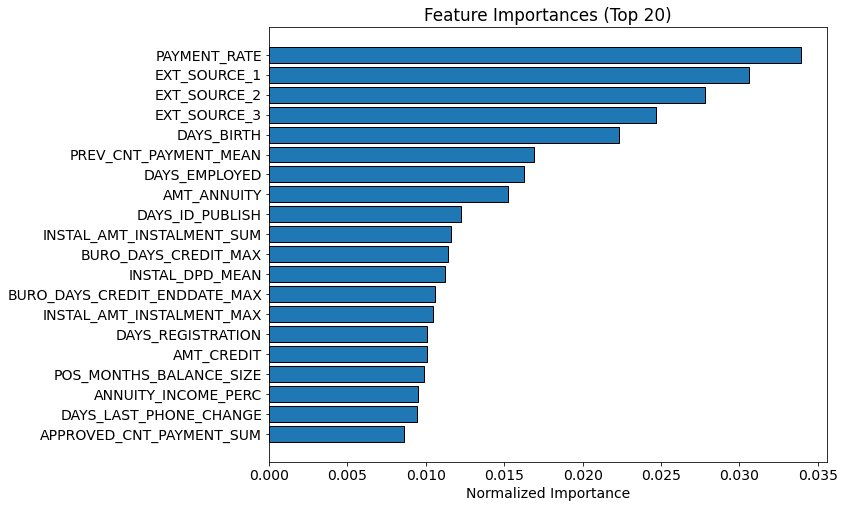

In [40]:
norm_feature_importances = plot_feature_importances(df_train_featimp_lightgbm)

In [30]:
def plot_cumulative_feature_importances(df, threshold = 0.9):
    """
    Prints the number of features needed to reach threshold cumulative importance.
    Source : 
    https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
   
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Nombre de variables'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cumulative importance' % (importance_index + 1, threshold))
    
    return df

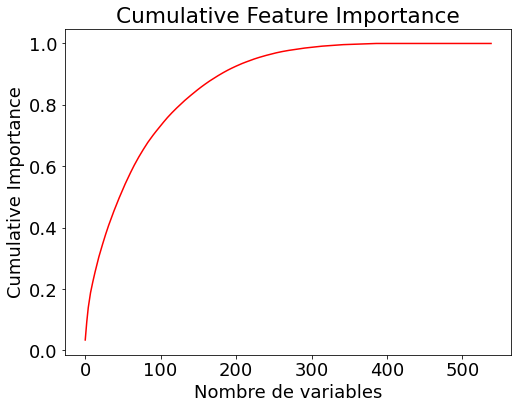

181 variables nécessaires pour 0.90 de cumulative importance


In [31]:
df_importance_features = plot_cumulative_feature_importances(df_train_featimp_lightgbm)

In [41]:
df_importance_features

index                                feature  importance  \
0      194                           PAYMENT_RATE       181.5   
1       25                           EXT_SOURCE_1       164.0   
2       26                           EXT_SOURCE_2       149.0   
3       27                           EXT_SOURCE_3       132.0   
4        8                             DAYS_BIRTH       119.5   
..     ...                                    ...         ...   
534     78            NAME_INCOME_TYPE_Unemployed         0.0   
535     47                        FLAG_DOCUMENT_9         0.0   
536    518     CC_NAME_CONTRACT_STATUS_Active_MAX         0.0   
537    522  CC_NAME_CONTRACT_STATUS_Completed_MIN         0.0   
538    538        CC_NAME_CONTRACT_STATUS_nan_VAR         0.0   

     importance_normalized  cumulative_importance  
0                 0.033894               0.033894  
1                 0.030626               0.064519  
2                 0.027824               0.092344  
3                 0.024650               0.116993  
4                 0.022316               0.139309  
..                     ...                    ...  
534               0.000000               1.000000  
535               0.000000               1.000000  
536               0.000000               1.000000  
537               0.000000               1.000000  
538               0.000000               1.000000  

[539 rows x 5 columns]

In [42]:
df_features_selection = df_importance_features[df_importance_features['cumulative_importance'] <0.9]
df_features_selection

index                                         feature  importance  \
0      194                                    PAYMENT_RATE       181.5   
1       25                                    EXT_SOURCE_1       164.0   
2       26                                    EXT_SOURCE_2       149.0   
3       27                                    EXT_SOURCE_3       132.0   
4        8                                      DAYS_BIRTH       119.5   
..     ...                                             ...         ...   
175    392  PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN         8.0   
176     23                          REG_CITY_NOT_LIVE_CITY         8.0   
177    211                            BURO_AMT_ANNUITY_MAX         8.0   
178    292     PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN         8.0   
179    458                         INSTAL_PAYMENT_PERC_MAX         8.0   

     importance_normalized  cumulative_importance  
0                 0.033894               0.033894  
1                 0.030626               0.064519  
2                 0.027824               0.092344  
3                 0.024650               0.116993  
4                 0.022316               0.139309  
..                     ...                    ...  
175               0.001494               0.893464  
176               0.001494               0.894958  
177               0.001494               0.896452  
178               0.001494               0.897946  
179               0.001494               0.899440  

[180 rows x 5 columns]

#### Selection liste de FEATURES_IMPORTANCE

In [90]:
features_selection_liste = list(df_features_selection['feature'])
len(features_selection_liste)

180

In [91]:
features_selection_liste.remove('INSTAL_PAYMENT_PERC_MEAN')
features_selection_liste.remove('CLOSED_AMT_CREDIT_SUM_MAX')
features_selection_liste.remove('PREV_CHANNEL_TYPE_Creditandcashoffices_MEAN')

#### Sauvegarde de features selection (180 variables pour corr < 0.9)

In [93]:
# Sauvegarde des variables conservées pour le train_set et test_set
fic_var_features_180 = 'features_180.pickle'
with open(fic_var_features_180, 'wb') as f:
    pickle.dump(features_selection_liste, f, pickle.HIGHEST_PROTOCOL)

In [94]:
# Chargement des variables conservées pour le train_set et test_set
fic_var_features_180 = 'features_180.pickle'
with open('features_180.pickle', 'rb') as fic_var_features_180:
    features_selection_liste_180 = pickle.load(fic_var_features_180)
len(features_selection_liste_180)

177

### Constitution du dataframe pour entrainement sur train_set

In [95]:
features_selection_liste_180.insert(0, 'TARGET')
features_selection_liste_180.insert(0, 'SK_ID_CURR')
print(len(features_selection_liste_180))
features_selection_liste_180

179


['SK_ID_CURR',
 'TARGET',
 'PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'INSTAL_AMT_INSTALMENT_SUM',
 'BURO_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_AMT_INSTALMENT_MAX',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'POS_MONTHS_BALANCE_SIZE',
 'ANNUITY_INCOME_PERC',
 'DAYS_LAST_PHONE_CHANGE',
 'APPROVED_CNT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'INSTAL_DBD_SUM',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'REGION_POPULATION_RELATIVE',
 'INCOME_CREDIT_PERC',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'INSTAL_AMT_INSTALMENT_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_DBD_MAX',
 'INSTAL_DBD_MEAN',
 'CODE_GENDER',
 'INSTAL_AMT_PAYMENT_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'PREV_APP_CREDIT_PERC_ME

In [96]:
df_appl_train = df_train[features_selection_liste_180]
print(df_appl_train.shape)
df_appl_train

(307481, 179)


SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0           100002       1      0.060749      0.083037      0.262949   
1           100003       0      0.027598      0.311267      0.622246   
2           100004       0      0.050000      0.505994      0.555912   
3           100006       0      0.094941      0.505994      0.650442   
4           100007       0      0.042623      0.505994      0.322738   
...            ...     ...           ...           ...           ...   
307476      456251       0      0.108198      0.145570      0.681632   
307477      456252       0      0.044524      0.505994      0.115992   
307478      456253       0      0.044239      0.744026      0.535722   
307479      456254       1      0.054592      0.505994      0.514163   
307480      456255       0      0.072767      0.734460      0.708569   

        EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0           0.139376       -9461              24.000000         -637.0   
1           0.535276      -16765              10.000000        -1188.0   
2           0.729567      -19046               4.000000         -225.0   
3           0.535276      -19005              23.000000        -3039.0   
4           0.535276      -19932              20.666667        -3038.0   
...              ...         ...                    ...            ...   
307476      0.535276       -9327               8.000000         -236.0   
307477      0.535276      -20775               6.000000        -1648.0   
307478      0.218859      -14966               5.000000        -7921.0   
307479      0.661024      -11961              15.000000        -4786.0   
307480      0.113922      -16856              21.750000        -1262.0   

        AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0           24700.5  ...                              0.000000   
1           35698.5  ...                              0.666667   
2            6750.0  ...                              0.000000   
3           29686.5  ...                              0.000000   
4           21865.5  ...                              0.000000   
...             ...  ...                                   ...   
307476      27558.0  ...                              0.000000   
307477      12001.5  ...                              0.000000   
307478      29979.0  ...                              0.500000   
307479      20205.0  ...                              0.000000   
307480      49117.5  ...                              0.125000   

        PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                       179055.0                             0.00   
1                        68809.5                             0.00   
2                        24282.0                             0.00   
3                            0.0                             0.00   
4                        17176.5                             0.00   
...                          ...                              ...   
307476                   40455.0                             0.00   
307477                   57595.5                             0.00   
307478                   19413.0                             0.00   
307479                   18846.0                             0.00   
307480                   45000.0                             0.25   

        NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                   0                               0   
1                                   1                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
...                               ...                             ...   
307476                              0                               0   
307477                              0           

####  Save final file with 180 important features (avec 0.9 cumulative importance) selection for work modeling
#### "df_appl_train_imp_features_180.csv" ==> dataframe: df_appl_train

In [97]:
# Sauvegarde de df_appl_train avec 180 important features pour ML modéling
df_appl_train.to_csv("df_appl_train_imp_features_180.csv", index=False)

### <font color="#0000FF" id="section_2_2">2.2. Constitution de dataframes pour entrainement et prediction</font>

**Traintement de données pour separation en** :
- df_train (entrainement modèles) et 
- df_test (seulement pour predictions API), contenant seulement 1% des données et non utilisé pour entrainement des modéles ML

In [41]:
# Dataframe issue de la jonction des fichiers
# read "df_appl_train_imp_features.csv" 
df = pd.read_csv("df_appl_train_imp_features_180.csv")
print("df.shape", df.shape)

df.shape (307481, 179)


In [42]:
print("df.shape", df.shape)
print(df['TARGET'].value_counts());
print("Solvabilité clients (%)",  round(df['TARGET'].value_counts()[1]/len(df)*100,2))

df.shape (307481, 179)
0    282660
1     24821
Name: TARGET, dtype: int64
Solvabilité clients (%) 8.07


In [44]:
df_test = df.sample(frac=0.01, random_state=60)

In [46]:
print("df_test.shape", df_test.shape)
print(df_test['TARGET'].value_counts());
print("Solvabilité clients (%)",  round(df_test['TARGET'].value_counts()[1]/len(df_test)*100,2))

df_test.shape (3075, 179)
0    2810
1     265
Name: TARGET, dtype: int64
Solvabilité clients (%) 8.62


### Sauvegarde du dataframe df_test pour la prediction et API !!

In [47]:
df_test.to_csv('df_test.csv', index=False)
# attention: presence de columns=['SK_ID_CURR', 'TARGET'] pour comparaison modelisation

In [48]:
df_test.set_index('SK_ID_CURR')

TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                   
313929           0      0.050000      0.505994      0.608078      0.670652   
105340           0      0.029372      0.740411      0.627234      0.474051   
156832           0      0.035589      0.339599      0.414564      0.313917   
182823           0      0.067267      0.505994      0.767440      0.743559   
192820           1      0.044184      0.214755      0.406225      0.357293   
...            ...           ...           ...           ...           ...   
178128           0      0.072329      0.505994      0.461248      0.220095   
184315           0      0.029240      0.505994      0.357282      0.728141   
400457           0      0.079466      0.505994      0.568211      0.759712   
369341           0      0.039660      0.505994      0.580479      0.535276   
210781           0      0.032361      0.505994      0.633592      0.526295   

            DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  AMT_ANNUITY  \
SK_ID_CURR                                                                  
313929          -11580               9.000000        -2532.0      15750.0   
105340          -20735              36.000000        -1648.0      28660.5   
156832          -17059               5.000000        -1153.0      28827.0   
182823          -16829               8.000000        -4200.0      51309.0   
192820          -12091              10.800000         -515.0      41881.5   
...                ...                    ...            ...          ...   
178128          -23635              17.666667        -1648.0       7798.5   
184315          -15917              52.000000        -5979.0      26316.0   
400457          -11689              12.800000        -4024.0      10710.0   
369341          -21798               6.000000        -1648.0      44617.5   
210781          -16772              12.000000         -279.0      41692.5   

            DAYS_ID_PUBLISH  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
SK_ID_CURR                   ...                                         
313929                -3244  ...                                   0.0   
105340                -4273  ...                                   0.0   
156832                 -604  ...                                   0.0   
182823                 -383  ...                                   0.5   
192820                -2938  ...                                   0.0   
...                     ...  ...                                   ...   
178128                -4065  ...                                   0.0   
184315                -4050  ...                                   0.0   
400457                -3185  ...                                   0.0   
369341                -5285  ...                                   0.0   
210781                 -325  ...                                   0.0   

            PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
SK_ID_CURR                                                              
313929                       45000.0                         0.000000   
105340                           0.0                         0.000000   
156832                           0.0                         0.000000   
182823                       50805.0                         0.000000   
192820                           0.0                         0.166667   
...                              ...                              ...   
178128                           0.0                         0.142857   
184315                      180000.0                         0.000000   
400457                       26392.5                         0.000000   
369341                      133384.5                         0.000000   
210781                           0.0                         0.000000   

            NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
SK_ID

In [50]:
liste1= df_test.set_index('SK_ID_CURR').index
liste1

Int64Index([313929, 105340, 156832, 182823, 192820, 385926, 189696, 188208,
            453222, 177326,
            ...
            265562, 284297, 188847, 356639, 150492, 178128, 184315, 400457,
            369341, 210781],
           dtype='int64', name='SK_ID_CURR', length=3075)

In [53]:
df_train= df.set_index('SK_ID_CURR')
df_train

TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                   
100002           1      0.060749      0.083037      0.262949      0.139376   
100003           0      0.027598      0.311267      0.622246      0.535276   
100004           0      0.050000      0.505994      0.555912      0.729567   
100006           0      0.094941      0.505994      0.650442      0.535276   
100007           0      0.042623      0.505994      0.322738      0.535276   
...            ...           ...           ...           ...           ...   
456251           0      0.108198      0.145570      0.681632      0.535276   
456252           0      0.044524      0.505994      0.115992      0.535276   
456253           0      0.044239      0.744026      0.535722      0.218859   
456254           1      0.054592      0.505994      0.514163      0.661024   
456255           0      0.072767      0.734460      0.708569      0.113922   

            DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  AMT_ANNUITY  \
SK_ID_CURR                                                                  
100002           -9461              24.000000         -637.0      24700.5   
100003          -16765              10.000000        -1188.0      35698.5   
100004          -19046               4.000000         -225.0       6750.0   
100006          -19005              23.000000        -3039.0      29686.5   
100007          -19932              20.666667        -3038.0      21865.5   
...                ...                    ...            ...          ...   
456251           -9327               8.000000         -236.0      27558.0   
456252          -20775               6.000000        -1648.0      12001.5   
456253          -14966               5.000000        -7921.0      29979.0   
456254          -11961              15.000000        -4786.0      20205.0   
456255          -16856              21.750000        -1262.0      49117.5   

            DAYS_ID_PUBLISH  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
SK_ID_CURR                   ...                                         
100002                -2120  ...                              0.000000   
100003                 -291  ...                              0.666667   
100004                -2531  ...                              0.000000   
100006                -2437  ...                              0.000000   
100007                -3458  ...                              0.000000   
...                     ...  ...                                   ...   
456251                -1982  ...                              0.000000   
456252                -4090  ...                              0.000000   
456253                -5150  ...                              0.500000   
456254                 -931  ...                              0.000000   
456255                 -410  ...                              0.125000   

            PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
SK_ID_CURR                                                              
100002                      179055.0                             0.00   
100003                       68809.5                             0.00   
100004                       24282.0                             0.00   
100006                           0.0                             0.00   
100007                       17176.5                             0.00   
...                              ...                              ...   
456251                       40455.0                             0.00   
456252                       57595.5                             0.00   
456253                       19413.0                             0.00   
456254                       18846.0                             0.00   
456255                       45000.0                             0.25   

            NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
SK_ID

In [56]:
df_train = df_train.drop(index=liste1)
df_train

TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
SK_ID_CURR                                                                   
100002           1      0.060749      0.083037      0.262949      0.139376   
100003           0      0.027598      0.311267      0.622246      0.535276   
100004           0      0.050000      0.505994      0.555912      0.729567   
100006           0      0.094941      0.505994      0.650442      0.535276   
100007           0      0.042623      0.505994      0.322738      0.535276   
...            ...           ...           ...           ...           ...   
456251           0      0.108198      0.145570      0.681632      0.535276   
456252           0      0.044524      0.505994      0.115992      0.535276   
456253           0      0.044239      0.744026      0.535722      0.218859   
456254           1      0.054592      0.505994      0.514163      0.661024   
456255           0      0.072767      0.734460      0.708569      0.113922   

            DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  AMT_ANNUITY  \
SK_ID_CURR                                                                  
100002           -9461              24.000000         -637.0      24700.5   
100003          -16765              10.000000        -1188.0      35698.5   
100004          -19046               4.000000         -225.0       6750.0   
100006          -19005              23.000000        -3039.0      29686.5   
100007          -19932              20.666667        -3038.0      21865.5   
...                ...                    ...            ...          ...   
456251           -9327               8.000000         -236.0      27558.0   
456252          -20775               6.000000        -1648.0      12001.5   
456253          -14966               5.000000        -7921.0      29979.0   
456254          -11961              15.000000        -4786.0      20205.0   
456255          -16856              21.750000        -1262.0      49117.5   

            DAYS_ID_PUBLISH  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
SK_ID_CURR                   ...                                         
100002                -2120  ...                              0.000000   
100003                 -291  ...                              0.666667   
100004                -2531  ...                              0.000000   
100006                -2437  ...                              0.000000   
100007                -3458  ...                              0.000000   
...                     ...  ...                                   ...   
456251                -1982  ...                              0.000000   
456252                -4090  ...                              0.000000   
456253                -5150  ...                              0.500000   
456254                 -931  ...                              0.000000   
456255                 -410  ...                              0.125000   

            PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
SK_ID_CURR                                                              
100002                      179055.0                             0.00   
100003                       68809.5                             0.00   
100004                       24282.0                             0.00   
100006                           0.0                             0.00   
100007                       17176.5                             0.00   
...                              ...                              ...   
456251                       40455.0                             0.00   
456252                       57595.5                             0.00   
456253                       19413.0                             0.00   
456254                       18846.0                             0.00   
456255                       45000.0                             0.25   

            NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
SK_ID

In [57]:
df_train = df_train.reset_index()
df_train

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0           100002       1      0.060749      0.083037      0.262949   
1           100003       0      0.027598      0.311267      0.622246   
2           100004       0      0.050000      0.505994      0.555912   
3           100006       0      0.094941      0.505994      0.650442   
4           100007       0      0.042623      0.505994      0.322738   
...            ...     ...           ...           ...           ...   
304401      456251       0      0.108198      0.145570      0.681632   
304402      456252       0      0.044524      0.505994      0.115992   
304403      456253       0      0.044239      0.744026      0.535722   
304404      456254       1      0.054592      0.505994      0.514163   
304405      456255       0      0.072767      0.734460      0.708569   

        EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0           0.139376       -9461              24.000000         -637.0   
1           0.535276      -16765              10.000000        -1188.0   
2           0.729567      -19046               4.000000         -225.0   
3           0.535276      -19005              23.000000        -3039.0   
4           0.535276      -19932              20.666667        -3038.0   
...              ...         ...                    ...            ...   
304401      0.535276       -9327               8.000000         -236.0   
304402      0.535276      -20775               6.000000        -1648.0   
304403      0.218859      -14966               5.000000        -7921.0   
304404      0.661024      -11961              15.000000        -4786.0   
304405      0.113922      -16856              21.750000        -1262.0   

        AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0           24700.5  ...                              0.000000   
1           35698.5  ...                              0.666667   
2            6750.0  ...                              0.000000   
3           29686.5  ...                              0.000000   
4           21865.5  ...                              0.000000   
...             ...  ...                                   ...   
304401      27558.0  ...                              0.000000   
304402      12001.5  ...                              0.000000   
304403      29979.0  ...                              0.500000   
304404      20205.0  ...                              0.000000   
304405      49117.5  ...                              0.125000   

        PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                       179055.0                             0.00   
1                        68809.5                             0.00   
2                        24282.0                             0.00   
3                            0.0                             0.00   
4                        17176.5                             0.00   
...                          ...                              ...   
304401                   40455.0                             0.00   
304402                   57595.5                             0.00   
304403                   19413.0                             0.00   
304404                   18846.0                             0.00   
304405                   45000.0                             0.25   

        NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                   0                               0   
1                                   1                               0   
2                                   0                               0   
3                                   0                               0   
4                                   0                               0   
...                               ...                             ...   
304401                              0                               0   
304402                              0           

In [58]:
df_train.to_csv('df_train.csv', index=False)
# attention: presence de columns=['SK_ID_CURR', 'TARGET'] pour comparaison modelisation

In [59]:
print("df_train.shape", df_train.shape)
print(df_train['TARGET'].value_counts());
print("Solvabilité clients (%)",  round(df_train['TARGET'].value_counts()[1]/len(df_train)*100,2))

df_train.shape (304406, 179)
0    279850
1     24556
Name: TARGET, dtype: int64
Solvabilité clients (%) 8.07


## <font color="#0000FF" id="section_3">3. Simulation modèlisation et progression</font>

### <font color="#0000FF" id="section_3_1">3.1. Simulation des algorithmes d'apprentissage</font>

### Validation croisés sur 5 folds 
### Traitement des données déséquilibrées par ajustement de poids de classe (class_weight='balanced')
- Ici: poids plus élevé à la classe1 (w1=6,2 ) et  poids plus faible à la classe0 (w0= 0.54 ), selon la formule: n_samples / (n_classes * np.bincount(y))

In [55]:
# Dataframe d'entrainement, issue de la jonction des fichiers 
df = pd.read_csv("df_train.csv")
print("df.shape", df.shape) # (304406, 179)

df.shape (304406, 179)


In [5]:
df_0_pay = df[df['TARGET']==0]
print(len(df_0_pay))
df_1_unpay = df[df['TARGET']==1]
print(len(df_1_unpay))
print(round(len(df_0_pay)/len(df_1_unpay),3))

279850
24556
11.396


In [56]:
X = df.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X.shape

(304406, 177)

In [57]:
Y = df['TARGET']
Y.shape # (304406,)

(304406,)

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state = 42)

In [15]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X_train.shape (243524, 177)
X_test.shape (60882, 177)


## a) Selection du metrique: 'roc_auc'

In [9]:
# Déclaration des algorithmes/modèles que je souhaite utiliser
# Choix des modèles avec les hyperparamètres de base pour choisir le meilleur modèle à optimiser

pipelines = {
                'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(class_weight='balanced'),
                'LGBM': LGBMClassifier(class_weight='balanced'),
                'Random Forest': RandomForestClassifier(class_weight='balanced'),
                'XGBoost' : XGBClassifier(class_weight='balanced'),
                }
n_splits = 5

In [10]:
print('\033[1m'+ "Score moyen d'entrainement sur les", n_splits, "folds et Temps de traitement, pour les modèles suivants: ") 

for name, mo in pipelines.items():
    model = make_pipeline(mo)
    kfold = KFold(n_splits=n_splits)
    cross_validation_results = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=5)
    scores = cross_validate(model, X_train, y_train, scoring='roc_auc', return_train_score=True)
    print('\033[0m', name, ": auc_score % 0.2f" % cross_validation_results.mean())
    print('\033[0m', mo, ": % 0.4f" % scores['fit_time'].mean(), "sec")  

Score moyen d'entrainement sur les 5 folds et Temps de traitement, pour les modèles suivants: 
 Dummy Classifier : auc_score  0.50
 DummyClassifier() :  0.0798 sec
 Logistic Regression : auc_score  0.77
 LogisticRegression(class_weight='balanced') :  4.0839 sec
 LGBM : auc_score  0.78
 LGBMClassifier(class_weight='balanced') :  5.3577 sec
 Random Forest : auc_score  0.74
 RandomForestClassifier(class_weight='balanced') :  106.5007 sec


C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: Th

 XGBoost : auc_score  0.77
 XGBClassifier(base_score=None, booster=None, class_weight='balanced',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, enable_categorical=False, gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) :  97.8219 sec


In [11]:
auc_score = [0.5, 0.77, 0.78, 0.74, 0.77]

In [12]:
Modele = ['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost']

In [13]:
Temps_traitm = [0.0798, 4.0839, 5.3577, 106.5007, 97.8219]

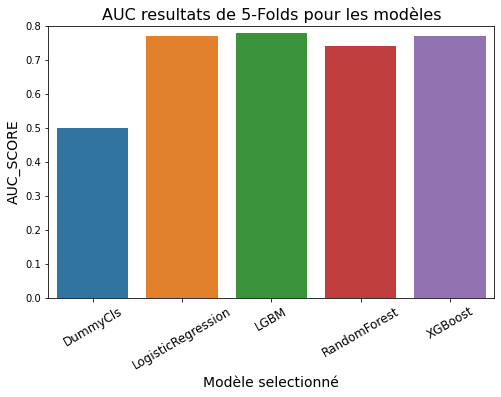

In [18]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=auc_score)
plt.title("AUC resultats de 5-Folds pour les modèles", fontsize=16)
plt.xlabel("Modèle selectionné", fontsize=14)
plt.xticks([0,1,2,3,4],['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost'], fontsize=12);
plt.xticks(rotation=30);
plt.ylim (0, 0.8)
plt.ylabel("AUC_SCORE", fontsize=14)
plt.show()

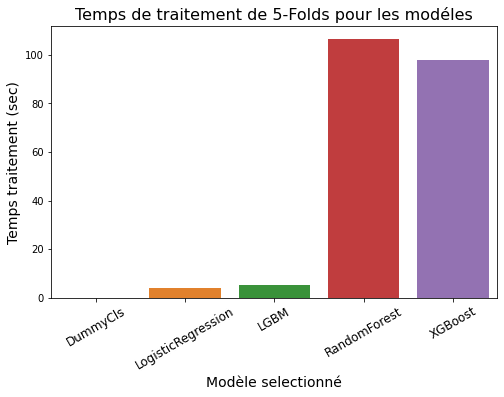

In [19]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=Temps_traitm)
plt.title("Temps de traitement de 5-Folds pour les modéles", fontsize=16)
plt.xlabel("Modèle selectionné", fontsize=14)
plt.xticks([0,1,2,3,4],['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost'], fontsize=12)
plt.xticks(rotation=30);
plt.ylabel("Temps traitement (sec)", fontsize=14)
plt.show()

In [20]:
model_lgbm = make_pipeline(LGBMClassifier())
model_lgbm.get_params().keys()
params_model_lgbm = model_lgbm.get_params()

In [21]:
# sauvegarde du model_lgbm
filename_params_model_lgbm = 'params_model_lgbm.pickle'
# Sauvegarde du modèle model_lgbm
pickle.dump(params_model_lgbm, open(filename_params_model_lgbm, 'wb'))

In [43]:
with open('params_model_lgbm.pickle',"rb") as filename_params_model_lgbm:
    params_model_lgbm =pickle.load(filename_params_model_lgbm) 

## b) Selection du metrique: 'f1-score'

In [45]:
pipelines_3 = {
                'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(class_weight='balanced'),
                'LGBM': LGBMClassifier(class_weight='balanced'),
                'Random Forest': RandomForestClassifier(class_weight='balanced'),
                'XGBoost' : XGBClassifier(class_weight='balanced'),
                }
n_splits = 5

In [46]:
print('\033[1m'+ "Score moyen d'entrainement sur les", n_splits, "folds et Temps de traitement, pour les modèles suivants: ") 

for name, mo in pipelines_3.items():
    model = make_pipeline(mo)
    kfold = KFold(n_splits=n_splits)
    cross_validation_results = cross_val_score(model, X_train, y_train, scoring='f1', cv=5)
    scores = cross_validate(model, X_train, y_train, scoring="f1", return_train_score=True)
    print('\033[0m', name, ": f1_score % 0.2f" % cross_validation_results.mean())
    print('\033[0m', mo, ": % 0.4f" % scores['fit_time'].mean(), "sec")

Score moyen d'entrainement sur les 5 folds et Temps de traitement, pour les modèles suivants: 
 Dummy Classifier : f1_score  0.00
 DummyClassifier() :  0.0854 sec
 Logistic Regression : f1_score  0.27
 LogisticRegression(class_weight='balanced') :  3.7689 sec
 LGBM : f1_score  0.29
 LGBMClassifier(class_weight='balanced') :  5.1851 sec
 Random Forest : f1_score  0.00
 RandomForestClassifier(class_weight='balanced') :  109.2298 sec


C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gabriela\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: Th

 XGBoost : f1_score  0.11
 XGBClassifier(base_score=None, booster=None, class_weight='balanced',
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, enable_categorical=False, gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) :  37.2158 sec


In [48]:
f1_score = [0.0, 0.27, 0.29, 0.00, 0.11]
Modele = ['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost']
Temps_traitm_f1 = [0.0854 , 3.7689 , 5.1851 , 109.2298, 37.2158 ]

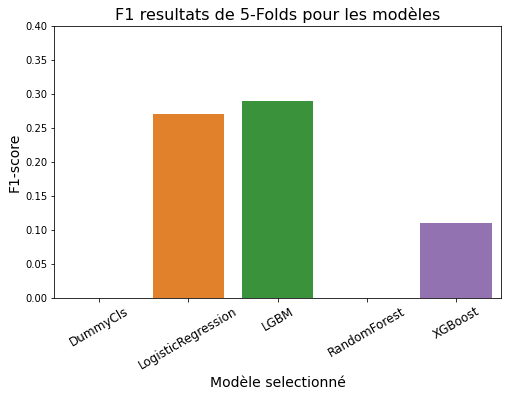

In [55]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=f1_score)
plt.title("F1 resultats de 5-Folds pour les modèles", fontsize=16)
plt.xlabel("Modèle selectionné", fontsize=14)
plt.xticks([0,1,2,3,4],['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost'], fontsize=12);
plt.xticks(rotation=30);
plt.ylim (0, 0.4)
plt.ylabel("F1-score", fontsize=14)
plt.show()

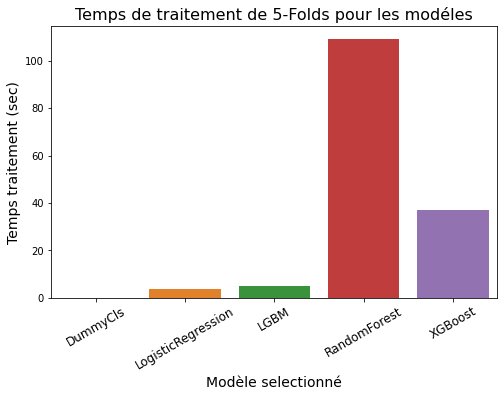

In [51]:
rcParams['figure.figsize'] = 8, 5
sns.barplot(x=Modele, y=Temps_traitm_f1)
plt.title("Temps de traitement de 5-Folds pour les modéles", fontsize=16)
plt.xlabel("Modèle selectionné", fontsize=14)
plt.xticks([0,1,2,3,4],['DummyCls', 'LogisticRegression','LGBM', 'RandomForest', 'XGBoost'], fontsize=12)
plt.xticks(rotation=30);
plt.ylabel("Temps traitement (sec)", fontsize=14)
plt.show()

### <font color="#0000FF" id="section_3_2">3.2. Optimisation des hyperparamètres - meilleur modèle</font>

## Tuning Hyperparameters pout LGBM

In [14]:
from sklearn.model_selection import RandomizedSearchCV

n=25

lgbm = LGBMClassifier(max_depth=-1,
                      objective = 'binary',
                      random_state=13,
                      n_jobs=-1,
                      n_estimators=100,                      
                      is_unbalance = True, 
                      metric = 'auc',        
                      )

lgbm_param = {'num_leaves': np.linspace(30, 80, 7, dtype='int'),
                'max_depth': [3, 5, 6, 7], 
                'min_data_in_leaf' : [100, 200],    
                'min_child_weight': [1e-3, 1e-2, 1, 1e2],
              'num_iterations' : [300, 500]
 }

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=4, 
                          return_train_score=True,  
                          random_state=13,
                          )

grid.fit(X_train, y_train)

print("Meilleur score", round(grid.best_score_, 5))
print(" Meilleurs parametres", grid.best_params_)
print ("Meilleure config: ", grid.best_estimator_)
optima = pd.DataFrame(grid.cv_results_).T
optima

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Meilleur score 0.78293
 Meilleurs parametres {'num_leaves': 80, 'num_iterations': 500, 'min_data_in_leaf': 200, 'min_child_weight': 0.001, 'max_depth': 3}
Meilleure config:  LGBMClassifier(is_unbalance=True, max_depth=3, metric='auc',
               min_data_in_leaf=200, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)


0   \
mean_fit_time                                                    75.31332   
std_fit_time                                                      3.12115   
mean_score_time                                                  2.214276   
std_score_time                                                   0.079026   
param_num_leaves                                                       80   
param_num_iterations                                                  500   
param_min_data_in_leaf                                                200   
param_min_child_weight                                              0.001   
param_max_depth                                                         3   
params                  {'num_leaves': 80, 'num_iterations': 500, 'min...   
split0_test_score                                                0.786269   
split1_test_score                                                0.780265   
split2_test_score                                                0.779826   
split3_test_score                                                  0.7828   
split4_test_score                                                0.785515   
mean_test_score                                                  0.782935   
std_test_score                                                    0.00263   
rank_test_score                                                         1   
split0_train_score                                               0.825442   
split1_train_score                                               0.826768   
split2_train_score                                               0.826698   
split3_train_score                                               0.826332   
split4_train_score                                               0.826013   
mean_train_score                                                 0.826251   
std_train_score                                                  0.000487   

                                                                       1   \
mean_fit_time                                                   75.456935   
std_fit_time                                                     2.643491   
mean_score_time                                                  2.629765   
std_score_time                                                   0.177899   
param_num_leaves                                                       46   
param_num_iterations                                                  300   
param_min_data_in_leaf                                                100   
param_min_child_weight                                               0.01   
param_max_depth                                                         7   
params                  {'num_leaves': 46, 'num_iterations': 300, 'min...   
split0_test_score                                                0.778963   
split1_test_score                                                0.775038   
split2_test_score                                                 0.77198   
split3_test_score                                                0.776965   
split4_test_score                                                0.779849   
mean_test_score                                                  0.776559   
std_test_score                                                    0.00283   
rank_test_score                                                        19   
split0_train_score                                               0.927727   
split1_train_score                                               0.928096   
split2_train_score                                               0.927396   
split3_train_score                                               0.926318   
split4_train_score                                                0.92705   
mean_train_score                                                 0.927317   
std_train_score                                                  0.000608   

                                                                 

In [ ]:
optima_cv_results = optima.T

In [17]:
optima_cv_results.to_csv('optima_cv_results.csv', index=False)

In [18]:
round(optima_cv_results['mean_train_score'].max(), 3)

0.977

### Le meilleur score pour le train_score  ==>: 0.95 + Save params+config

In [7]:
optima_cv_results= pd.read_csv('optima_cv_results.csv')

In [8]:
optima_cv_results['mean_train_score'].sort_values(ascending=False).index

Int64Index([21, 20,  6, 16, 18, 22, 15,  4,  1, 23, 12,  2,  9, 17, 24, 11,  5,
             3, 14,  8,  0, 10, 19,  7, 13],
           dtype='int64')

In [9]:
best_model_lgbm_train_params = optima_cv_results.loc[21]

In [10]:
best_model_lgbm_train_params['params']

"{'num_leaves': 71, 'num_iterations': 500, 'min_data_in_leaf': 100, 'min_child_weight': 0.01, 'max_depth': 7}"

### Selection du meilleur modèle lgbm sur le score du train_score == best_lgbm_model_train

In [24]:
best_lgbm_model_train = LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=71,
               objective='binary', random_state=13)

In [26]:
# sauvegarde des meilleurs modele lgbm_train sur le score du train
filename_best_lgbm_model_train = 'best_lgbm_model_train.pickle'
# Sauvegarde du best modèle lgbm train = score sur train
pickle.dump(best_lgbm_model_train, open(filename_best_lgbm_model_train, 'wb'))

In [18]:
with open('best_lgbm_model_train.pickle',"rb") as filename_best_lgbm_model_train:
    best_lgbm_model_train=pickle.load(filename_best_lgbm_model_train)

### <font color="#0000FF" id="section_3_3">3.3. Seuil optimal avec G-mean pour données desequilibrées</font>

In [10]:
def my_colors(n=5):
    return [(sns.color_palette("pastel", 100)[i]) for i in np.linspace(0, 99, n, dtype=int)]

In [ ]:
### Utilisation du G-mean is the geometric mean of recall and specificity
# https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293

In [30]:
def plot_metrics_threshold_gmean(model, X_train, X_test, y_train, y_test):    
     
    model = model.fit(X_train, y_train)
    # probabilité pour target(0, resp 1)
    y_prob = model.predict_proba(X_test)
    # probabilité d'obtenir en sortie 1
    y_prob = y_prob[:, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)
    
    # Définition du seuil de décision à partir de g_mean : 
    # G-mean is the geometric mean of recall and specificity    
    g_means = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean= optimal threshold
    ix = np.argmax(g_means)

    y_prob = (y_prob >= thresholds[ix]).astype(bool)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_prob, labels=[1,0]).ravel()
    conf_mat = [[tp,fn],[fp,tn]]
        
    auc = metrics.roc_auc_score(y_test, y_prob) # Compute Area Under ROC Characteristic Curve (ROC AUC) from prediction scores
    recall = metrics.recall_score(y_test, y_prob)
    precision = metrics.precision_score(y_test, y_prob)
    f1 = metrics.f1_score(y_test, y_prob)
        
    ######################################
    print("Modéle: ", model)
    print()
    print("Confusion_matrix")
    print(pd.DataFrame(confusion_matrix(y_test, y_prob)))
    print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
    print()
    print(f'Testset: \
    Threshold = {thresholds[ix]:.0%}, \
    G-Mean= {g_means[ix]:.0%}, \
    AUC = {auc:.0%}, \
    Recall= {recall:.0%}, \
    f1_score = {f1:.0%}')
    print()
    print("classification_report")
    print(classification_report(y_test, y_prob))
    print()
    print("Confusion matrix'", conf_mat)
    ######################################

    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, 'k')
    plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
    plt.fill_between(fpr, tpr, facecolor='lightsteelblue', alpha=0.7)
    plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
    plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right', fontsize=16, weight='bold', color='white')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

    plt.subplot(222)
    plt.plot(thresholds, g_means, 'r');
    plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Proba threshold')
    plt.ylim(0,1)
    plt.ylabel('G-Means')
    plt.title('G-Means vs. Threshold')

    plt.subplot(223)
    plt.plot(recall_, precision_, 'teal');
    plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Recall')
    plt.ylim(0,1)
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')

    plt.subplot(224)
    sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
    plt.xticks([0.5,1.5], [0,1])
    plt.yticks([0.5,1.5], [0,1])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    plt.tight_layout(pad=1.1)
    plt.show()

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Modéle:  LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=71,
               objective='binary', random_state=13)

Confusion_matrix
       0      1
0  37992  17814
1   1375   3701
TN = 3701, FP = 1375, FN = 17814, TP = 37992

Testset:     Threshold = 33%,     G-Mean= 70%,     AUC = 70%,     Recall= 73%,     f1_score = 28%

classification_report
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     55806
           1       0.17      0.73      0.28      5076

    accuracy                           0.68     60882
   macro avg       0.57      0.70      0.54     60882
weighted avg       0.90      0.68      0.76     60882


Confusion matrix' [[37992, 17814], [1375, 3701]]


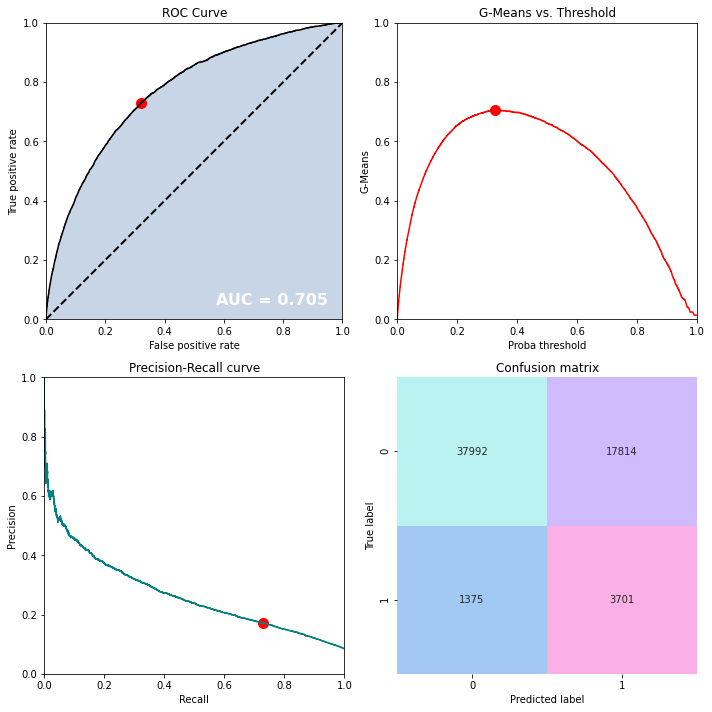

In [31]:
plot_metrics_threshold_gmean(best_lgbm_model_train, X_train, X_test, y_train, y_test)

In [32]:
TN = 3701
FP = 1375
FN = 17814
TP = 37992

# Définition de la Perte pour la banque:
fn_value = -10
fp_value = -100
tp_value = 10
tn_value = 0

# Perte total =P
P = FN*fn_value + FP*fp_value
# Gain total =G
G = TP*tp_value + TN*tn_value + FN*fn_value + FP*fp_value 

print("Perte banque avec G-mean:", P)
print("Gain banque avec G-mean:", G)

Perte banque avec G-mean: -315640
Gain banque avec G-mean: 64280


### <font color="#0000FF" id="section_3_4">3.4. Seuil optimal avec F1-score pour données desequilibrées</font>

In [16]:
def plot_metrics_threshold_f1score(model, X_train, X_test, y_train, y_test):    
     
    model = model.fit(X_train, y_train)
    # probabilité pour target(0, resp 1)
    y_prob = model.predict_proba(X_test)
    # probabilité d'obtenir en sortie 1
    y_prob = y_prob[:, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)
    
    # Calculate the f1-score
    f1score = (2 * precision_ * recall_) / (precision_ + recall_)
    
    # Find the optimal threshold
    ix = np.argmax(f1score)
    
    y_prob = (y_prob >= thresh_[ix]).astype(bool)
    print("y_prob[ix]", y_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_prob, labels=[1,0]).ravel()
    conf_mat = [[tp,fn],[fp,tn]]
        
    auc = metrics.roc_auc_score(y_test, y_prob) # Compute Area Under ROC Characteristic Curve (ROC AUC) from prediction scores

   
    ######################################
    print("Modéle: ", model)
    print()
    print("Confusion_matrix")
    print(pd.DataFrame(confusion_matrix(y_test, y_prob)))
    print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
    print()
    print(f'Testset: \
    Threshold_optimal = {thresh_[ix]:.0%}, \
    AUC = {auc:.0%}, \
    Recall_optimal= {recall_[ix]:.0%}, \
    f1_score_optimal = {f1score[ix]:.0%}')
    print()
    print("classification_report")
    print(classification_report(y_test, y_prob))
    print()
    print("Confusion matrix'", conf_mat)
    ######################################


    plt.figure(figsize=(10, 10))

    plt.subplot(221)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, 'k')
    plt.plot([0, 1], [0, 1], '--', lw=2, color='k')
    plt.fill_between(fpr, tpr, facecolor='lightsteelblue', alpha=0.7)
#    plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
    plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right', fontsize=16, weight='bold', color='white')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

    plt.subplot(222)
    plt.plot(thresh_, f1score[:-1], 'r');
    plt.scatter(thresh_[ix], f1score[ix], marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Proba threshold')
    plt.ylim(0,1)
    plt.ylabel('F1-score')
    plt.title('F1-score vs. Threshold')

    plt.subplot(223)
    plt.plot(recall_, precision_, 'teal');
    plt.scatter(recall_[ix], precision_[ix], marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Recall')
    plt.ylim(0,1)
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')

    plt.subplot(224)
    sns.heatmap(conf_mat, cmap=my_colors(100), annot=True, fmt='.0f', cbar=False)
    plt.xticks([0.5,1.5], [0,1])
    plt.yticks([0.5,1.5], [0,1])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    plt.tight_layout(pad=1.1)
    plt.show()   
 

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
y_prob[ix] [False False  True ... False False False]
Modéle:  LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=71,
               objective='binary', random_state=13)

Confusion_matrix
       0     1
0  49559  6247
1   2856  2220
TN = 2220, FP = 2856, FN = 6247, TP = 49559

Testset:     Threshold_optimal = 57%,     AUC = 66%,     Recall_optimal= 44%,     f1_score_optimal = 33%

classification_report
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     55806
           1       0.26      0.44      0.33      5076

    accuracy                           0.85     60882
   macro avg       0.60      0.66      0.62     60882
weighted avg       0.89      0.85      0.87     60882


Confusion matrix' [[49559, 6247], [2856, 2220]]


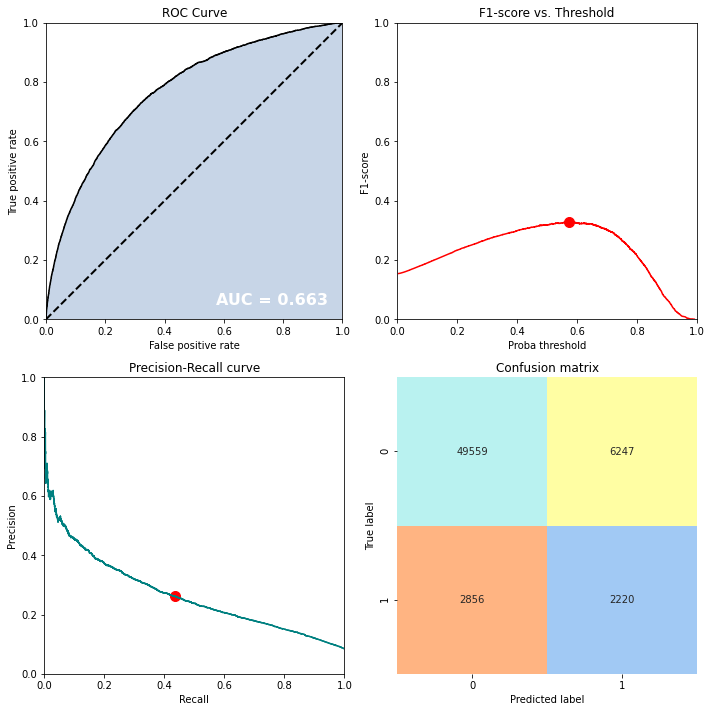

In [19]:
plot_metrics_threshold_f1score(best_lgbm_model_train, X_train, X_test, y_train, y_test)

In [35]:
TN = 2220
FP = 2856
FN = 6247
TP = 49559

# Définition de la Perte pour la banque:
fn_value = -10
fp_value = -100
tp_value = 10
tn_value = 0

# Perte total =P
P = FN*fn_value + FP*fp_value
# Gain total =G
G = TP*tp_value + TN*tn_value + FN*fn_value + FP*fp_value 

print("Perte banque avec F1-score:", P)
print("Gain banque avec F1-score:", G)

Perte banque avec F1-score: -348070
Gain banque avec F1-score: 147520


### Definition de Matrice des coûts : Une matrice qui attribue un coût à chaque cellule de la matrice de confusion afin d'obtenir le gain total pour la banque
### https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/

In [20]:
def matrice_cout(y_test, y_prob): 
    
    fn_value=-10
    fp_value=-100
    tp_value=10
    tn_value=0
    
    # Matrice de Confusion
    mat_conf = confusion_matrix(y_test, y_prob)
    
    # Nombre de True Positifs
    tp = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[0, 1]
    # Nombre de True Negatifs
    tn = mat_conf[1, 1]    
    # Nombre de Faux Positifs
    fp = mat_conf[1, 0]
    
    
    # Gain total
    G = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value

    return G

In [21]:
def gain_seuil(model, X_test, y_test):
    
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 30)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_prob = (y_prob > threshold)
        
        y_prob = np.array(y_prob > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(matrice_cout(y_test, y_prob))
        
    # Affichage du gain en fonction du seuil de solvabilité
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Matrice de cout")
    plt.xticks(np.linspace(0.1, 1, 10))

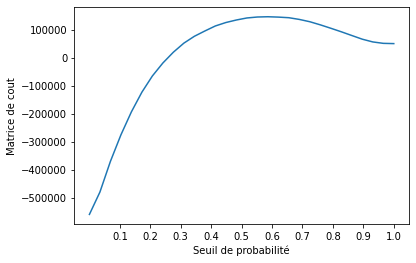

In [22]:
gain_seuil(best_lgbm_model_train, X_test, y_test)

In [243]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [48]:
best_lgbm_model_train

LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=71,
               objective='binary', random_state=13)

In [49]:
n=20

lgbm = LGBMClassifier(max_depth=-1,
                      objective = 'binary',
                      random_state=13,
                      n_jobs=-1,
                      num_iterations=500,                      
                      is_unbalance = True, 
                      metric = 'auc',         
                      )

lgbm_param = {'num_leaves': np.linspace(30, 80, 7, dtype='int'),
                'max_depth': [3, 5, 6, 7], 
                'min_data_in_leaf' : [100, 200],    
                'min_child_weight': [1e-3, 1e-2, 1, 1e2],
 }


scorer = {'main': 'roc_auc',
          'custom': make_scorer(matrice_cout, greater_is_better=True)}

grid_cout = RandomizedSearchCV(lgbm,
                               lgbm_param,
                               n_iter=n,
                               scoring=scorer,
                               cv=5,
                               refit='custom',
                               return_train_score=True, 
                               )

grid_cout.fit(X_train, y_train)

print(round(grid_cout.best_score_, 5))
print(grid_cout.best_params_)
optima_cout = pd.DataFrame(grid_cout.cv_results_).T
optima_cout

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
121980.0
{'num_leaves': 80, 'min_data_in_leaf': 100, 'min_child_weight': 0.001, 'max_depth': 7}


0   \
mean_fit_time                                                    6.951398   
std_fit_time                                                     0.032648   
mean_score_time                                                  0.305981   
std_score_time                                                   0.026079   
param_num_leaves                                                       38   
param_min_data_in_leaf                                                200   
param_min_child_weight                                                  1   
param_max_depth                                                         3   
params                  {'num_leaves': 38, 'min_data_in_leaf': 200, 'm...   
split0_test_main                                                 0.786269   
split1_test_main                                                 0.780265   
split2_test_main                                                 0.779826   
split3_test_main                                                   0.7828   
split4_test_main                                                 0.785515   
mean_test_main                                                   0.782935   
std_test_main                                                     0.00263   
rank_test_main                                                          3   
split0_train_main                                                0.825442   
split1_train_main                                                0.826768   
split2_train_main                                                0.826698   
split3_train_main                                                0.826332   
split4_train_main                                                0.826013   
mean_train_main                                                  0.826251   
std_train_main                                                   0.000487   
split0_test_custom                                                91630.0   
split1_test_custom                                                87150.0   
split2_test_custom                                                86550.0   
split3_test_custom                                                88170.0   
split4_test_custom                                                92160.0   
mean_test_custom                                                  89132.0   
std_test_custom                                               2320.744708   
rank_test_custom                                                       17   
split0_train_custom                                              470710.0   
split1_train_custom                                              482910.0   
split2_train_custom                                              476410.0   
split3_train_custom                                              478650.0   
split4_train_custom                                              480140.0   
mean_train_custom                                                477764.0   
std_train_custom                                              4111.056312   

                                                                       1   \
mean_fit_time                                                    12.78659   
std_fit_time                                                     0.197007   
mean_score_time                                                  0.527788   
std_score_time                                                   0.008063   
param_num_leaves                                                       38   
param_min_data_in_leaf                                                200   
param_min_child_weight                                              100.0   
param_max_depth                                                         7   
params                  {'num_leaves': 38, 'min_data_in_leaf': 200, 'm...   
split0_test_main                                                 0.781477   
split1_test_main                                                 0.777369   
split2_test_main                                                 0

In [53]:
optima_cout_results = optima_cout.T

In [56]:
optima_cout_results.to_csv('optima_cout_results.csv', index=False)

In [58]:
round(optima_cout_results['mean_train_custom'].max(), 3)

1347696.0

In [59]:
optima_cout_results['mean_train_custom'].sort_values(ascending=False).index

Int64Index([7, 6, 4, 15, 13, 9, 1, 3, 17, 10, 19, 5, 16, 12, 14, 8, 2, 0, 18,
            11],
           dtype='int64')

In [33]:
best_model_lgbm_train_cout_params = optima_cout_results.loc[7]

In [34]:
best_model_lgbm_train_cout_params['params']

"{'num_leaves': 80, 'min_data_in_leaf': 100, 'min_child_weight': 0.001, 'max_depth': 7}"

In [35]:
best_lgbm_model_cout_train = LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80, min_child_weight=0.001,
               objective='binary', random_state=13)

In [36]:
# sauvegarde des meilleurs modele lgbm_cout_train sur le score du train
filename_best_lgbm_model_cout_train = 'best_lgbm_model_cout_train.pickle'
# Sauvegarde du best modèle lgbm train = score sur train
pickle.dump(best_lgbm_model_cout_train, open(filename_best_lgbm_model_cout_train, 'wb'))

In [23]:
with open('best_lgbm_model_cout_train.pickle',"rb") as filename_best_lgbm_model_cout_train:
    best_lgbm_model_cout_train=pickle.load(filename_best_lgbm_model_cout_train)

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
y_prob[ix] [False False  True ... False False False]
Modéle:  LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)

Confusion_matrix
       0     1
0  49610  6196
1   2861  2215
TN = 2215, FP = 2861, FN = 6196, TP = 49610

Testset:     Threshold_optimal = 57%,     AUC = 66%,     Recall_optimal= 44%,     f1_score_optimal = 33%

classification_report
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     55806
           1       0.26      0.44      0.33      5076

    accuracy                           0.85     60882
   macro avg       0.60      0.66      0.62     60882
weighted avg       0.89      0.85      0.87     60882


Confusion matrix' [[49610, 6196], [2861, 2215]]


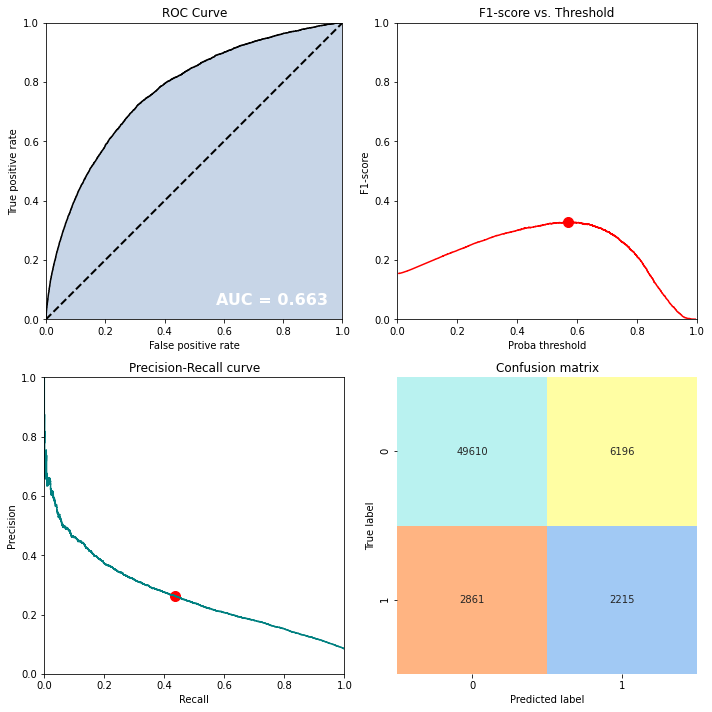

In [24]:
plot_metrics_threshold_f1score(best_lgbm_model_cout_train, X_train, X_test, y_train, y_test)

In [39]:
TN = 2215
FP = 2861
FN = 6196
TP = 49610

# Définition de la Perte pour la banque:
fn_value = -10
fp_value = -100
tp_value = 10
tn_value = 0

# Perte total =P
P = FN*fn_value + FP*fp_value
# Gain total =G
G = TP*tp_value + TN*tn_value + FN*fn_value + FP*fp_value 

print("Perte banque avec F1-score & Fonction_cout:", P)
print("Gain banque avec F1-score & Fonction_cout:", G)

Perte banque avec F1-score & Fonction_cout: -348060
Gain banque avec F1-score & Fonction_cout: 148040


### <font color="#0000FF" id="section_3_5">3.5. Selection features globales et locales</font>

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
y_prob[ix] [False False  True ... False False False]
Modéle:  LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)

Confusion_matrix
       0     1
0  49610  6196
1   2861  2215
TN = 2215, FP = 2861, FN = 6196, TP = 49610

Testset:     Threshold_optimal = 57%,     AUC = 66%,     Recall_optimal= 44%,     f1_score_optimal = 33%

classification_report
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     55806
           1       0.26      0.44      0.33      5076

    accuracy                           0.85     60882
   macro avg       0.60      0.66      0.62     60882
weighted avg       0.89      0.85      0.87     60882


Confusion matrix' [[49610, 6196], [2861, 2215]]


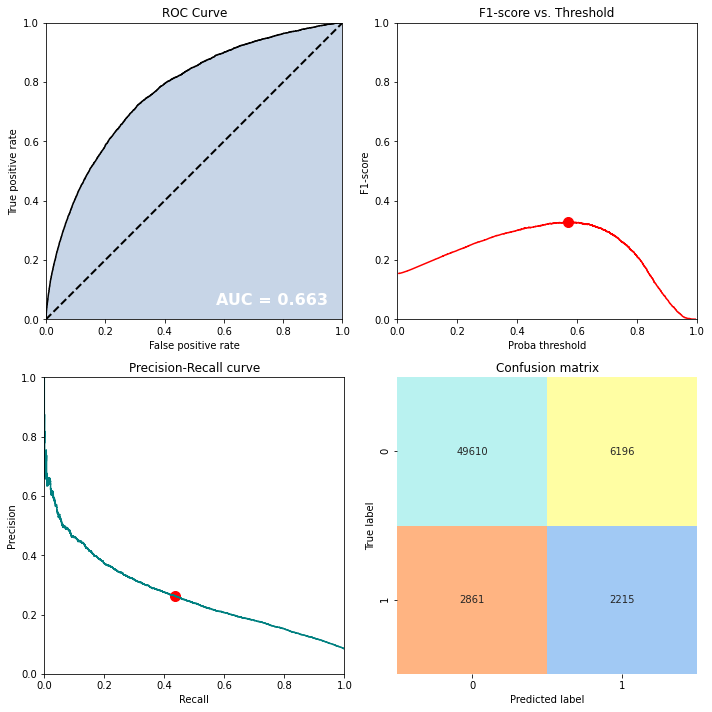

In [15]:
plot_metrics_threshold_f1score(best_lgbm_model_cout_train, X_train, X_test, y_train, y_test)

In [16]:
# Record the feature importances
feature_importances = best_lgbm_model_cout_train.feature_importances_

In [18]:
# création variable "importance"
df_train_lightgbm = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}) \
    .sort_values('importance', ascending=False)

# Features selection avec "feature_importances_" du modèle Lightgbm

In [43]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:15].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (top 15)')
    plt.xlabel('Importance', size=16)
    plt.ylabel('Feature', size=16)
    plt.tight_layout()
    plt.savefig('lgbm_feature_importances.png')

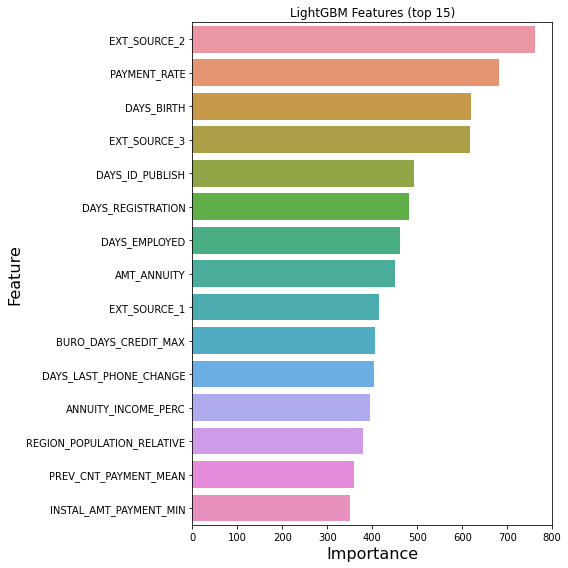

In [44]:
display_importances(df_train_lightgbm)

# Features selection avec SHAP 

Cette procédure rompt la relation entre la caractéristique et la cible. La baisse du score du modèle indique donc à quel point le modèle dépend de la caractéristique. Cette technique a l'avantage d'être agnostique vis-à-vis du modèle et peut être calculée de nombreuses fois avec différentes permutations de la caractéristique.   L'importance de la permutation ne reflète pas la valeur prédictive intrinsèque d'une caractéristique en soi, mais l'importance de cette caractéristique pour un modèle particulier.

In [15]:
# read "df_train.csv" 
df = pd.read_csv("df_train.csv")
df.shape

(304406, 179)

In [16]:
# exemple pour entrainer et preparer pour SHAP
X_shap = df.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X_shap.shape

(304406, 177)

In [17]:
Y_shap = df['TARGET']
Y_shap.shape

(304406,)

In [18]:
# Split into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X_shap, Y_shap, test_size=0.2, random_state=42)

In [19]:
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)

X_train.shape (243524, 177)
X_test.shape (60882, 177)


In [190]:
best_lgbm_model_cout_train

LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)

In [20]:
# Train using early stopping
model = best_lgbm_model_cout_train.fit(X_train, y_train, 
                                            eval_set=[(X_test, y_test)], eval_metric = 'auc', verbose = 200)

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[200]	valid_0's auc: 0.776606
[400]	valid_0's auc: 0.771408


In [21]:
import shap
shap.initjs()  # nécessaire pour tracer les force plots
explainer = shap.TreeExplainer(model)

In [22]:
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Importance globale avec SHAP

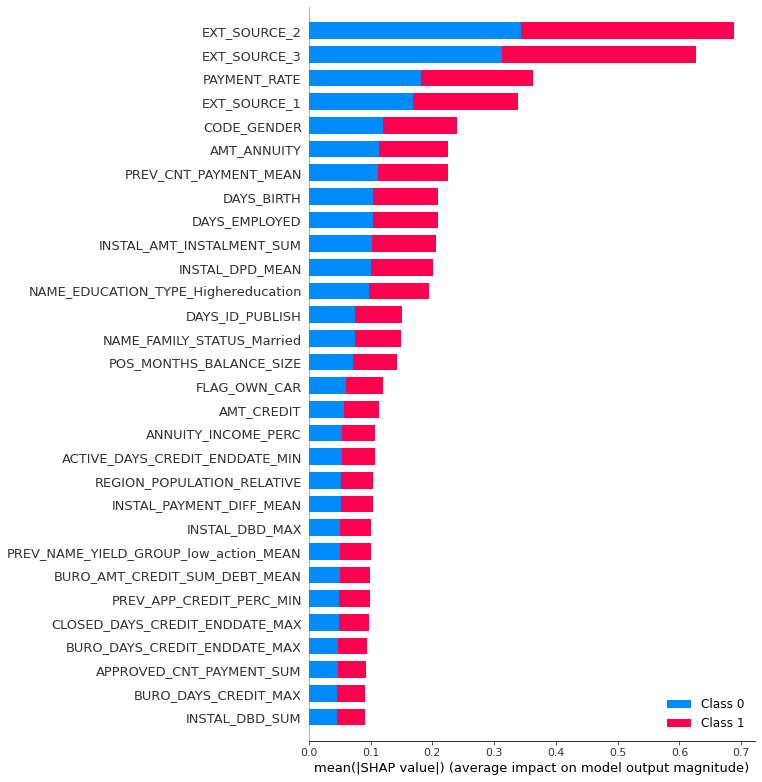

In [25]:
shap.summary_plot(shap_values, X_test, max_display=30,)

In [172]:
df_sample = X_test.sample(10000)
shap_values = explainer.shap_values(df_sample)

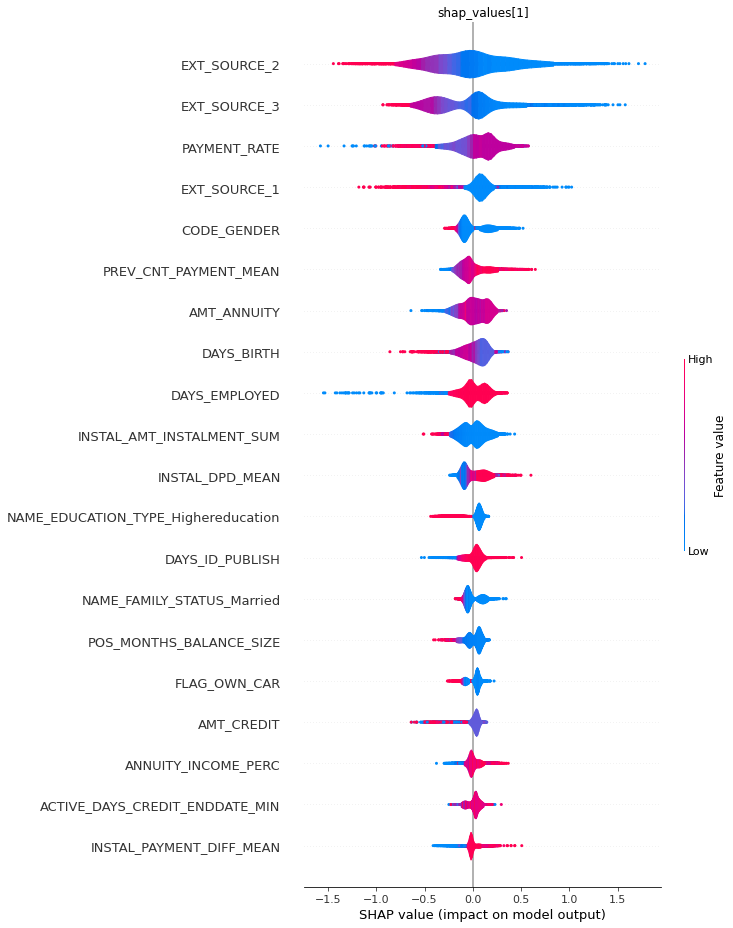

In [176]:
plt.title("shap_values[1]")
shap.summary_plot(shap_values[1], features=df_sample, feature_names=X_test.columns, max_display=20,
                  plot_type='violin', plot_size=0.72)
plt.show()

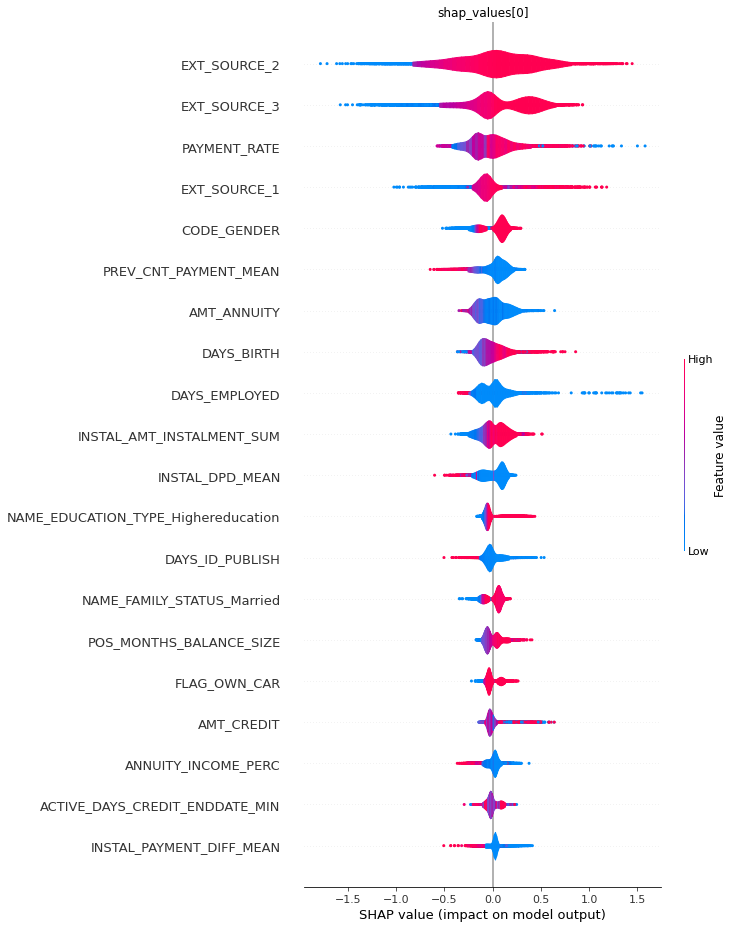

In [177]:
plt.title("shap_values[0]")
shap.summary_plot(shap_values[0], features=df_sample, feature_names=X_test.columns, max_display=20,
                  plot_type='violin', plot_size=0.72)
plt.show()

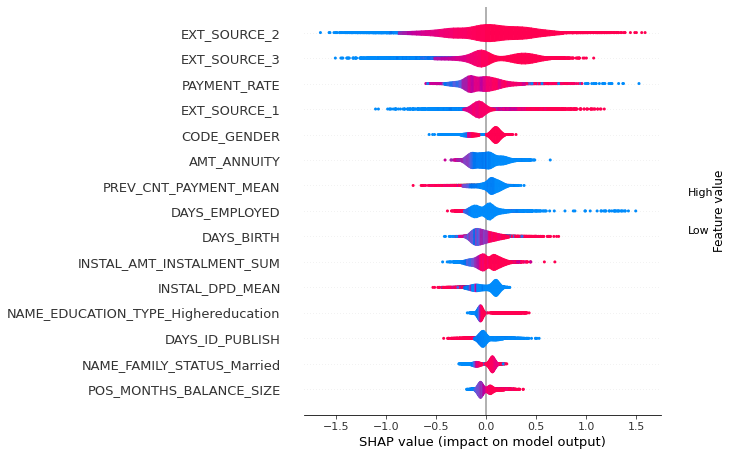

In [46]:
# shap.summary_plot(shap_values[1], features=df_sample, feature_names=X_test.columns, max_display=15, plot_type='violin')

## Importance locale avec SHAP

### Local bar plot
### Ce graphique nous montre quelles sont les principales caractéristiques affectant la prédiction d'une seule observation, et l'ampleur de la valeur SHAP pour chaque caractéristique

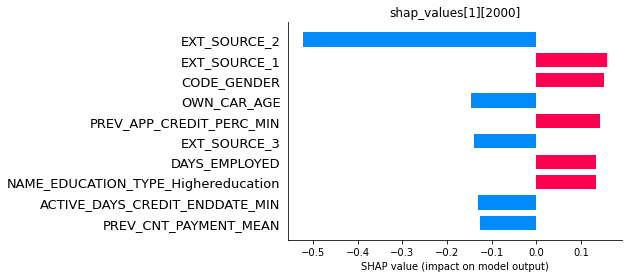

In [178]:
idx = 2000
plt.title(f"shap_values[1]{[idx]}")
shap.bar_plot(shap_values[1][idx], feature_names=X_test.columns, max_display=10)

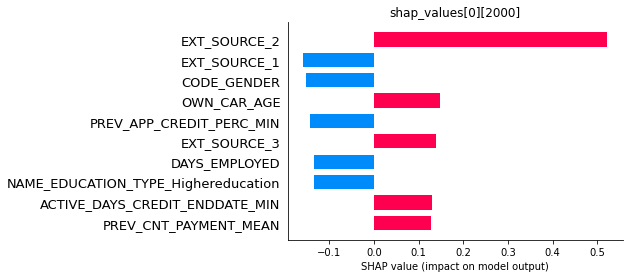

In [179]:
idx = 2000
plt.title(f"shap_values[0]{[idx]}")
shap.bar_plot(shap_values[0][idx], feature_names=X_test.columns, max_display=10)

### Force plot
Le diagramme de force est une autre façon de voir l'effet de chaque caractéristique sur la prédiction, pour une observation donnée. Dans ce graphique, les valeurs SHAP positives sont affichées sur le côté gauche et les valeurs négatives sur le côté droit, comme si elles se faisaient concurrence. La valeur en surbrillance est la prédiction pour cette observation.

Les graphiques de force (Force plot) conviennent à l'analyse SHAP par rangée. Il prend en une seule ligne et montre dans un ordre de classement comment chacune des caractéristiques a contribué à la prédiction. Plus le bloc d'une fonctionnalité est large, plus la contribution est importante.

Pour UNE donnée :
On peut voir les influences de chaque variable sur la prédiction.

In [181]:
idx = 2000
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], X_test.iloc[idx,:], out_names="Score")

### Pour visualiser plusiers predictions: selection de seulement 100 individus

In [184]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100, :], X_test.iloc[:100,:], out_names="Score")

## <font color="#0000FF" id="section_4">4. Préparation du Dashboard</font>

### <font color="#0000FF" id="section_4_1">4.1. Constitution dataframes et prediction pour 500 clients</font>

### SCORING: Predictions/Probabilités sur df_test

Comment: meilleur modèle entraîné sur le jeu d'entraînement est maintenant opérationnel pour effectuer des prédictions et calculer les probabiltés du score de chacun des clients du jeu de test fourni pour Home Crédit.

In [4]:
df_test = pd.read_csv("df_test.csv")
print(df_test.shape)

(3075, 179)


In [5]:
df_test

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0         313929       0      0.050000      0.505994      0.608078   
1         105340       0      0.029372      0.740411      0.627234   
2         156832       0      0.035589      0.339599      0.414564   
3         182823       0      0.067267      0.505994      0.767440   
4         192820       1      0.044184      0.214755      0.406225   
...          ...     ...           ...           ...           ...   
3070      178128       0      0.072329      0.505994      0.461248   
3071      184315       0      0.029240      0.505994      0.357282   
3072      400457       0      0.079466      0.505994      0.568211   
3073      369341       0      0.039660      0.505994      0.580479   
3074      210781       0      0.032361      0.505994      0.633592   

      EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0         0.670652      -11580               9.000000        -2532.0   
1         0.474051      -20735              36.000000        -1648.0   
2         0.313917      -17059               5.000000        -1153.0   
3         0.743559      -16829               8.000000        -4200.0   
4         0.357293      -12091              10.800000         -515.0   
...            ...         ...                    ...            ...   
3070      0.220095      -23635              17.666667        -1648.0   
3071      0.728141      -15917              52.000000        -5979.0   
3072      0.759712      -11689              12.800000        -4024.0   
3073      0.535276      -21798               6.000000        -1648.0   
3074      0.526295      -16772              12.000000         -279.0   

      AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0         15750.0  ...                                   0.0   
1         28660.5  ...                                   0.0   
2         28827.0  ...                                   0.0   
3         51309.0  ...                                   0.5   
4         41881.5  ...                                   0.0   
...           ...  ...                                   ...   
3070       7798.5  ...                                   0.0   
3071      26316.0  ...                                   0.0   
3072      10710.0  ...                                   0.0   
3073      44617.5  ...                                   0.0   
3074      41692.5  ...                                   0.0   

      PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                      45000.0                         0.000000   
1                          0.0                         0.000000   
2                          0.0                         0.000000   
3                      50805.0                         0.000000   
4                          0.0                         0.166667   
...                        ...                              ...   
3070                       0.0                         0.142857   
3071                  180000.0                         0.000000   
3072                   26392.5                         0.000000   
3073                  133384.5                         0.000000   
3074                       0.0                         0.000000   

      NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
4                                 0                               0   
...                             ...                             ...   
3070                              0                               0   
3071                              0                               1   
3072                              0                               0   
3073            

###  selection 500 clients pour prediction

In [35]:
df_test_500_1 = df_test[df_test['TARGET'] == 1]
print(df_test_500_1.shape)
df_test_500_1

(265, 179)


SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
4         192820       1      0.044184      0.214755      0.406225   
5         385926       1      0.048921      0.107903      0.655017   
17        216979       1      0.073215      0.378548      0.672607   
18        178551       1      0.079333      0.505994      0.348086   
25        207076       1      0.051205      0.358595      0.158839   
...          ...     ...           ...           ...           ...   
3003      184041       1      0.032397      0.505994      0.181073   
3024      127598       1      0.049569      0.505994      0.457214   
3025      378370       1      0.032453      0.082245      0.588064   
3031      110403       1      0.035634      0.505994      0.546223   
3037      371047       1      0.050000      0.260732      0.453070   

      EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
4         0.357293      -12091              10.800000         -515.0   
5         0.260856      -13128              25.090909        -1178.0   
17        0.493863      -10719              20.000000        -3651.0   
18        0.466864      -13995              35.500000        -3694.0   
25        0.235311      -15315              20.000000        -3051.0   
...            ...         ...                    ...            ...   
3003      0.672243      -16047              24.000000        -2571.0   
3024      0.535276      -21843              42.000000        -1648.0   
3025      0.535276       -8673               3.000000        -1198.0   
3031      0.535276      -22484              33.666667        -1445.0   
3037      0.535276      -12296               6.000000        -1044.0   

      AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
4         41881.5  ...                                   0.0   
5         21919.5  ...                                   0.0   
17        21415.5  ...                                   0.0   
18        31059.0  ...                                   0.0   
25        46084.5  ...                                   0.0   
...           ...  ...                                   ...   
3003      30528.0  ...                                   0.0   
3024      45504.0  ...                                   0.0   
3025      21906.0  ...                                   0.0   
3031     105511.5  ...                                   0.0   
3037       9000.0  ...                                   0.0   

      PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
4                          0.0                         0.166667   
5                          0.0                         0.000000   
17                         0.0                         0.307692   
18                         0.0                         0.125000   
25                         0.0                         0.000000   
...                        ...                              ...   
3003                  135000.0                         0.000000   
3024                       0.0                         0.166667   
3025                   82881.0                         0.000000   
3031                  159043.5                         0.000000   
3037                   31495.5                         0.000000   

      NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
4                                 0                               0   
5                                 0                               0   
17                                0                               0   
18                                0                               0   
25                                0                               0   
...                             ...                             ...   
3003                              0                               0   
3024                              0                               0   
3025                              0                               0   
3031            

In [36]:
df_test_500_0 = df_test[df_test['TARGET'] == 0]
print(df_test_500_0.shape)
df_test_500_0

(2810, 179)


SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0         313929       0      0.050000      0.505994      0.608078   
1         105340       0      0.029372      0.740411      0.627234   
2         156832       0      0.035589      0.339599      0.414564   
3         182823       0      0.067267      0.505994      0.767440   
6         189696       0      0.118668      0.505994      0.722792   
...          ...     ...           ...           ...           ...   
3070      178128       0      0.072329      0.505994      0.461248   
3071      184315       0      0.029240      0.505994      0.357282   
3072      400457       0      0.079466      0.505994      0.568211   
3073      369341       0      0.039660      0.505994      0.580479   
3074      210781       0      0.032361      0.505994      0.633592   

      EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0         0.670652      -11580               9.000000        -2532.0   
1         0.474051      -20735              36.000000        -1648.0   
2         0.313917      -17059               5.000000        -1153.0   
3         0.743559      -16829               8.000000        -4200.0   
6         0.060035      -11288              18.000000         -173.0   
...            ...         ...                    ...            ...   
3070      0.220095      -23635              17.666667        -1648.0   
3071      0.728141      -15917              52.000000        -5979.0   
3072      0.759712      -11689              12.800000        -4024.0   
3073      0.535276      -21798               6.000000        -1648.0   
3074      0.526295      -16772              12.000000         -279.0   

      AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0         15750.0  ...                                   0.0   
1         28660.5  ...                                   0.0   
2         28827.0  ...                                   0.0   
3         51309.0  ...                                   0.5   
6         28462.5  ...                                   0.0   
...           ...  ...                                   ...   
3070       7798.5  ...                                   0.0   
3071      26316.0  ...                                   0.0   
3072      10710.0  ...                                   0.0   
3073      44617.5  ...                                   0.0   
3074      41692.5  ...                                   0.0   

      PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                      45000.0                         0.000000   
1                          0.0                         0.000000   
2                          0.0                         0.000000   
3                      50805.0                         0.000000   
6                     270000.0                         0.000000   
...                        ...                              ...   
3070                       0.0                         0.142857   
3071                  180000.0                         0.000000   
3072                   26392.5                         0.000000   
3073                  133384.5                         0.000000   
3074                       0.0                         0.000000   

      NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 0                               0   
6                                 0                               0   
...                             ...                             ...   
3070                              0                               0   
3071                              0                               1   
3072                              0                               0   
3073            

In [37]:
df_test_500_00=df_test_500_0.sample(235)

In [38]:
df_test_500_00

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
2873      320753       0      0.048877      0.505994      0.749590   
967       222057       0      0.039824      0.484395      0.295224   
2552      435974       0      0.051053      0.505994      0.063655   
427       439107       0      0.092146      0.505994      0.574332   
1389      129242       0      0.070105      0.505994      0.567830   
...          ...     ...           ...           ...           ...   
99        338305       0      0.032496      0.421437      0.558119   
2766      108538       0      0.063900      0.351583      0.637932   
3018      163149       0      0.050000      0.330728      0.129668   
3059      188141       0      0.051465      0.457705      0.740267   
781       254832       0      0.030319      0.777013      0.266310   

      EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
2873      0.417100      -20222              14.000000         -218.0   
967       0.363945      -14077               5.333333         -405.0   
2552      0.389339      -11469              19.272727        -3167.0   
427       0.560284      -18886              10.000000        -2247.0   
1389      0.554947      -18944               9.400000        -2226.0   
...            ...         ...                    ...            ...   
99        0.422370      -15683              19.200000        -5989.0   
2766      0.591977      -17905               9.000000        -2983.0   
3018      0.535276      -20058              33.000000         -717.0   
3059      0.782608      -14318              12.000000        -7468.0   
781       0.315472      -21076              22.000000        -1648.0   

      AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
2873      26640.0  ...                              0.000000   
967       31050.0  ...                              0.000000   
2552      26613.0  ...                              0.083333   
427       27859.5  ...                              0.000000   
1389      17982.0  ...                              0.166667   
...           ...  ...                                   ...   
99        17401.5  ...                              0.000000   
2766      14377.5  ...                              0.500000   
3018      14625.0  ...                              0.000000   
3059      16096.5  ...                              0.000000   
781       63495.0  ...                              0.000000   

      PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
2873                       0.0                         0.000000   
967                        0.0                         0.000000   
2552                       0.0                         0.000000   
427                    18405.0                         0.000000   
1389                       0.0                         0.000000   
...                        ...                              ...   
99                         0.0                         0.200000   
2766                   30822.3                         0.000000   
3018                       0.0                         0.230769   
3059                   42480.0                         0.000000   
781                    17095.5                         0.000000   

      NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
2873                              0                               0   
967                               0                               0   
2552                              0                               0   
427                               0                               1   
1389                              0                               0   
...                             ...                             ...   
99                                0                               0   
2766                              0                               0   
3018                              0                               1   
3059            

In [39]:
df_test_500=df_test_500_00.append(df_test_500_1, ignore_index=True)
df_test_500.shape

(500, 179)

In [40]:
df_test_500

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0        320753       0      0.048877      0.505994      0.749590   
1        222057       0      0.039824      0.484395      0.295224   
2        435974       0      0.051053      0.505994      0.063655   
3        439107       0      0.092146      0.505994      0.574332   
4        129242       0      0.070105      0.505994      0.567830   
..          ...     ...           ...           ...           ...   
495      184041       1      0.032397      0.505994      0.181073   
496      127598       1      0.049569      0.505994      0.457214   
497      378370       1      0.032453      0.082245      0.588064   
498      110403       1      0.035634      0.505994      0.546223   
499      371047       1      0.050000      0.260732      0.453070   

     EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0        0.417100      -20222              14.000000         -218.0   
1        0.363945      -14077               5.333333         -405.0   
2        0.389339      -11469              19.272727        -3167.0   
3        0.560284      -18886              10.000000        -2247.0   
4        0.554947      -18944               9.400000        -2226.0   
..            ...         ...                    ...            ...   
495      0.672243      -16047              24.000000        -2571.0   
496      0.535276      -21843              42.000000        -1648.0   
497      0.535276       -8673               3.000000        -1198.0   
498      0.535276      -22484              33.666667        -1445.0   
499      0.535276      -12296               6.000000        -1044.0   

     AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0        26640.0  ...                              0.000000   
1        31050.0  ...                              0.000000   
2        26613.0  ...                              0.083333   
3        27859.5  ...                              0.000000   
4        17982.0  ...                              0.166667   
..           ...  ...                                   ...   
495      30528.0  ...                              0.000000   
496      45504.0  ...                              0.000000   
497      21906.0  ...                              0.000000   
498     105511.5  ...                              0.000000   
499       9000.0  ...                              0.000000   

     PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                         0.0                         0.000000   
1                         0.0                         0.000000   
2                         0.0                         0.000000   
3                     18405.0                         0.000000   
4                         0.0                         0.000000   
..                        ...                              ...   
495                  135000.0                         0.000000   
496                       0.0                         0.166667   
497                   82881.0                         0.000000   
498                  159043.5                         0.000000   
499                   31495.5                         0.000000   

     NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               1   
4                                0                               0   
..                             ...                             ...   
495                              0                               0   
496                              0                               0   
497                              0                               0   
498                              0                               0   
499

In [42]:
df_test_500.to_csv('df_test_500.csv', index=False)

In [43]:
df_test_500

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0        320753       0      0.048877      0.505994      0.749590   
1        222057       0      0.039824      0.484395      0.295224   
2        435974       0      0.051053      0.505994      0.063655   
3        439107       0      0.092146      0.505994      0.574332   
4        129242       0      0.070105      0.505994      0.567830   
..          ...     ...           ...           ...           ...   
495      184041       1      0.032397      0.505994      0.181073   
496      127598       1      0.049569      0.505994      0.457214   
497      378370       1      0.032453      0.082245      0.588064   
498      110403       1      0.035634      0.505994      0.546223   
499      371047       1      0.050000      0.260732      0.453070   

     EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0        0.417100      -20222              14.000000         -218.0   
1        0.363945      -14077               5.333333         -405.0   
2        0.389339      -11469              19.272727        -3167.0   
3        0.560284      -18886              10.000000        -2247.0   
4        0.554947      -18944               9.400000        -2226.0   
..            ...         ...                    ...            ...   
495      0.672243      -16047              24.000000        -2571.0   
496      0.535276      -21843              42.000000        -1648.0   
497      0.535276       -8673               3.000000        -1198.0   
498      0.535276      -22484              33.666667        -1445.0   
499      0.535276      -12296               6.000000        -1044.0   

     AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0        26640.0  ...                              0.000000   
1        31050.0  ...                              0.000000   
2        26613.0  ...                              0.083333   
3        27859.5  ...                              0.000000   
4        17982.0  ...                              0.166667   
..           ...  ...                                   ...   
495      30528.0  ...                              0.000000   
496      45504.0  ...                              0.000000   
497      21906.0  ...                              0.000000   
498     105511.5  ...                              0.000000   
499       9000.0  ...                              0.000000   

     PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                         0.0                         0.000000   
1                         0.0                         0.000000   
2                         0.0                         0.000000   
3                     18405.0                         0.000000   
4                         0.0                         0.000000   
..                        ...                              ...   
495                  135000.0                         0.000000   
496                       0.0                         0.166667   
497                   82881.0                         0.000000   
498                  159043.5                         0.000000   
499                   31495.5                         0.000000   

     NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               1   
4                                0                               0   
..                             ...                             ...   
495                              0                               0   
496                              0                               0   
497                              0                               0   
498                              0                               0   
499

## Entrainement du modéle pour prédictions/Dashboard pour seulement 500 clients 

In [64]:
# Dataframe d'entrainement, issue de la jonction des fichiers 
df = pd.read_csv("df_train.csv")
print("df.shape", df.shape) # (304406, 179)

df.shape (304406, 179)


In [65]:
X = df.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
X.shape

(304406, 177)

In [66]:
Y = df['TARGET']
Y.shape # (304406,)

(304406,)

In [67]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state = 42)

In [78]:
scaler = StandardScaler()
scaler=scaler.fit(X)

In [79]:
X_scaled = scaler.transform(X)

In [80]:
# sauvegarde des meilleurs modele lgbm_cout_train sur le score du train
filename_scaler = 'scaler.pickle'
# Sauvegarde du best modèle lgbm train = score sur train
pickle.dump(scaler, open(filename_scaler, 'wb'))

### choix du modéle

In [23]:
with open('best_lgbm_model_cout_train.pickle',"rb") as filename_best_lgbm_model_cout_train:
    best_lgbm_model_cout_train=pickle.load(filename_best_lgbm_model_cout_train)

In [68]:
model = best_lgbm_model_cout_train 

In [69]:
model

LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)

In [70]:
# entrainement du modele
best_lgbm_model_cout_train = model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric = 'auc', verbose = 200)

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

C:\Users\Gabriela\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[200]	valid_0's auc: 0.778093
[400]	valid_0's auc: 0.772767


In [74]:
X_train.shape

(243524, 177)

### Resauvegarde du (best_lgbm_model_cout_train.pickle) avec les poids du scaler de X entrainé 

In [71]:
# sauvegarde des meilleurs modele lgbm_cout_train sur le score du train
filename_best_lgbm_model_cout_train = 'best_lgbm_model_cout_train.pickle'
# Sauvegarde du best modèle lgbm train = score sur train
pickle.dump(best_lgbm_model_cout_train, open(filename_best_lgbm_model_cout_train, 'wb'))

In [72]:
with open('best_lgbm_model_cout_train.pickle',"rb") as filename_best_lgbm_model_cout_train:
    best_lgbm_model_cout_train=pickle.load(filename_best_lgbm_model_cout_train)

In [73]:
best_lgbm_model_cout_train

LGBMClassifier(is_unbalance=True, max_depth=7, metric='auc',
               min_data_in_leaf=100, num_iterations=500, num_leaves=80,
               objective='binary', random_state=13)

### Selection du dataframe avec données non_utilisé (df_test_500.csv) pour predictions
### Instructions pour prédictions sur API

In [75]:
df_test_500= pd.read_csv('df_test_500.csv')

In [76]:
df_test_500

SK_ID_CURR  TARGET  PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  \
0        320753       0      0.048877      0.505994      0.749590   
1        222057       0      0.039824      0.484395      0.295224   
2        435974       0      0.051053      0.505994      0.063655   
3        439107       0      0.092146      0.505994      0.574332   
4        129242       0      0.070105      0.505994      0.567830   
..          ...     ...           ...           ...           ...   
495      184041       1      0.032397      0.505994      0.181073   
496      127598       1      0.049569      0.505994      0.457214   
497      378370       1      0.032453      0.082245      0.588064   
498      110403       1      0.035634      0.505994      0.546223   
499      371047       1      0.050000      0.260732      0.453070   

     EXT_SOURCE_3  DAYS_BIRTH  PREV_CNT_PAYMENT_MEAN  DAYS_EMPLOYED  \
0        0.417100      -20222              14.000000         -218.0   
1        0.363945      -14077               5.333333         -405.0   
2        0.389339      -11469              19.272727        -3167.0   
3        0.560284      -18886              10.000000        -2247.0   
4        0.554947      -18944               9.400000        -2226.0   
..            ...         ...                    ...            ...   
495      0.672243      -16047              24.000000        -2571.0   
496      0.535276      -21843              42.000000        -1648.0   
497      0.535276       -8673               3.000000        -1198.0   
498      0.535276      -22484              33.666667        -1445.0   
499      0.535276      -12296               6.000000        -1044.0   

     AMT_ANNUITY  ...  PREV_NAME_CLIENT_TYPE_Refreshed_MEAN  \
0        26640.0  ...                              0.000000   
1        31050.0  ...                              0.000000   
2        26613.0  ...                              0.083333   
3        27859.5  ...                              0.000000   
4        17982.0  ...                              0.166667   
..           ...  ...                                   ...   
495      30528.0  ...                              0.000000   
496      45504.0  ...                              0.000000   
497      21906.0  ...                              0.000000   
498     105511.5  ...                              0.000000   
499       9000.0  ...                              0.000000   

     PREV_AMT_APPLICATION_MIN  PREV_CODE_REJECT_REASON_HC_MEAN  \
0                         0.0                         0.000000   
1                         0.0                         0.000000   
2                         0.0                         0.000000   
3                     18405.0                         0.000000   
4                         0.0                         0.000000   
..                        ...                              ...   
495                  135000.0                         0.000000   
496                       0.0                         0.166667   
497                   82881.0                         0.000000   
498                  159043.5                         0.000000   
499                   31495.5                         0.000000   

     NAME_INCOME_TYPE_Stateservant  ORGANIZATION_TYPE_Selfemployed  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               1   
4                                0                               0   
..                             ...                             ...   
495                              0                               0   
496                              0                               0   
497                              0                               0   
498                              0                               0   
499

In [30]:
# Sauvegarde des identifiants des clients inutiles aux prédictions
id_client = df_test_500['SK_ID_CURR']

In [77]:
# Préparation de la matrice à soumettre aux prédictions 
X_test_500 = df_test_500.drop(['SK_ID_CURR','TARGET'], axis=1)
print("X_test_500.shape", X_test_500.shape)

X_test_500.shape (500, 177)


### Selection du SEUIL pour les predictions clients!

In [81]:
# scaler = StandardScaler()
X_test = scaler.transform(X_test_500)

In [82]:
# Score des prédictions de probabiltés avec model_best_lgbm
y_proba = (model.predict_proba(X_test)[:, 1])

In [84]:
y_proba.min()

0.006961825520120188

In [85]:
y_proba.max()

0.9440662160015577

In [86]:
# définition du seuil à partir dequel la class 0 devient 1/prediction (avec F1-score)
mask_seuil = y_proba>= 0.57
mask_seuil = mask_seuil.astype(int)

In [93]:
mask_seuil.max()

1

## Constutution du dataframe avec les predictions

In [94]:
# Constitution du dataframe pour merge
df_prediction = pd.DataFrame({'SK_ID_CURR' : id_client,
                         'PRED_CLASSE' : mask_seuil,
                         'SCORE_CLIENT' : y_proba,
                         'SCORE_CLIENT_%' : np.round(y_proba * 100, 1)})
df_prediction

SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%
0        320753            0      0.129076            12.9
1        222057            0      0.341213            34.1
2        435974            0      0.073110             7.3
3        439107            0      0.193791            19.4
4        129242            0      0.109736            11.0
..          ...          ...           ...             ...
495      184041            0      0.184020            18.4
496      127598            0      0.405740            40.6
497      378370            0      0.374410            37.4
498      110403            0      0.238826            23.9
499      371047            0      0.505266            50.5

[500 rows x 4 columns]

In [95]:
df_prediction['SCORE_CLIENT'].max()

0.8232915766090031

In [96]:
# Ajout des prédictions au dataframe du jeu de test (df_test_500)
df_dashboard_1 = df_prediction.merge(df_test_500, on='SK_ID_CURR', how='left')

In [98]:
df_dashboard_1.columns[1:5]

Index(['PRED_CLASSE', 'SCORE_CLIENT', 'SCORE_CLIENT_%', 'TARGET'], dtype='object')

In [99]:
df_dashboard_1.columns[5:182]  # 177 features ('PAYMENT_RATE'---'INSTAL_PAYMENT_PERC_MAX')

Index(['PAYMENT_RATE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_BIRTH', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'DAYS_ID_PUBLISH', 'INSTAL_AMT_INSTALMENT_SUM',
       ...
       'PREV_NAME_CLIENT_TYPE_Refreshed_MEAN', 'PREV_AMT_APPLICATION_MIN',
       'PREV_CODE_REJECT_REASON_HC_MEAN', 'NAME_INCOME_TYPE_Stateservant',
       'ORGANIZATION_TYPE_Selfemployed',
       'PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN',
       'REG_CITY_NOT_LIVE_CITY', 'BURO_AMT_ANNUITY_MAX',
       'PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN',
       'INSTAL_PAYMENT_PERC_MAX'],
      dtype='object', length=177)

In [102]:
df_identif_seuil = df_dashboard_1[df_dashboard_1['SCORE_CLIENT'] > 0.57]
print(df_identif_seuil.shape)
df_identif_seuil

(26, 182)


SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%  TARGET  \
16       283984            1      0.602383            60.2       0   
146      147102            1      0.585181            58.5       0   
191      333443            1      0.574607            57.5       0   
239      207076            1      0.699244            69.9       1   
248      331463            1      0.778325            77.8       1   
266      416486            1      0.764593            76.5       1   
304      288022            1      0.629386            62.9       1   
312      301825            1      0.685344            68.5       1   
315      272007            1      0.653753            65.4       1   
320      355506            1      0.735423            73.5       1   
326      419679            1      0.763838            76.4       1   
328      400581            1      0.815116            81.5       1   
335      260993            1      0.680355            68.0       1   
339      158585            1      0.637657            63.8       1   
360      252254            1      0.589534            59.0       1   
362      152805            1      0.731708            73.2       1   
364      244071            1      0.710315            71.0       1   
369      363855            1      0.823292            82.3       1   
374      440963            1      0.689660            69.0       1   
400      173054            1      0.581354            58.1       1   
421      210797            1      0.643297            64.3       1   
439      232222            1      0.605948            60.6       1   
440      284376            1      0.793814            79.4       1   
441      319894            1      0.664627            66.5       1   
445      206662            1      0.634290            63.4       1   
468      452022            1      0.643966            64.4       1   

     PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  ...  \
16       0.046854      0.270128      0.160892      0.397946      -10254  ...   
146      0.037924      0.383236      0.162192      0.701696      -13607  ...   
191      0.050000      0.140298      0.140570      0.236611       -8172  ...   
239      0.051205      0.358595      0.158839      0.235311      -15315  ...   
248      0.048636      0.505994      0.057844      0.065993       -8987  ...   
266      0.106642      0.327778      0.036133      0.567379      -11085  ...   
304      0.079505      0.127206      0.124767      0.083364      -15696  ...   
312      0.054650      0.505994      0.092617      0.075461      -15179  ...   
315      0.054248      0.505994      0.335567      0.151935      -19220  ...   
320      0.048877      0.505994      0.592306      0.377404      -15172  ...   
326      0.054656      0.505994      0.145276      0.210350       -9989  ...   
328      0.048877      0.505994      0.400405      0.221335      -10360  ...   
335      0.055834      0.062497      0.033937      0.135106      -11637  ...   
339      0.048877      0.598851      0.238548      0.535276      -11897  ...   
360      0.027558      0.305962      0.643871      0.117614      -19443  ...   
362      0.048840      0.505994      0.600538      0.028474      -11115  ...   
364      0.036900      0.505994      0.008299      0.166406      -17841  ...   
369      0.038171      0.505994      0.091684      0.053844      -22060  ...   
374      0.067869      0.505994      0.057723      0.192942      -12309  ...   
400      0.048270      0.505994      0.330118      0.119119      -12587  ...   
421      0.078772      0.505994      0.429016      0.684828      -14844  ...   
439      0.072464      0.505994      0.036666      0.071533      -18307  ...   
440      0.060679      0.397664      0.271759      0.116867      -13353  ...   
441      0.079447      0.505994      0.423550      0.156640      -16918  ...   
445      0.035589      0.505994      0.008500      0.122955      -15342  ...   
468      0.046854      0.505994   

In [103]:
# Sauvegarde de df_dashboard_1
df_dashboard_1.to_csv('df_dashboard_1.csv', index=False)
print("df_dashboard_1.shape",df_dashboard_1.shape)

df_dashboard_1.shape (500, 182)


In [104]:
df_identif1 = df_dashboard_1[df_dashboard_1['PRED_CLASSE'] == 1]
print(df_identif1.shape)
df_identif1

(26, 182)


SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%  TARGET  \
16       283984            1      0.602383            60.2       0   
146      147102            1      0.585181            58.5       0   
191      333443            1      0.574607            57.5       0   
239      207076            1      0.699244            69.9       1   
248      331463            1      0.778325            77.8       1   
266      416486            1      0.764593            76.5       1   
304      288022            1      0.629386            62.9       1   
312      301825            1      0.685344            68.5       1   
315      272007            1      0.653753            65.4       1   
320      355506            1      0.735423            73.5       1   
326      419679            1      0.763838            76.4       1   
328      400581            1      0.815116            81.5       1   
335      260993            1      0.680355            68.0       1   
339      158585            1      0.637657            63.8       1   
360      252254            1      0.589534            59.0       1   
362      152805            1      0.731708            73.2       1   
364      244071            1      0.710315            71.0       1   
369      363855            1      0.823292            82.3       1   
374      440963            1      0.689660            69.0       1   
400      173054            1      0.581354            58.1       1   
421      210797            1      0.643297            64.3       1   
439      232222            1      0.605948            60.6       1   
440      284376            1      0.793814            79.4       1   
441      319894            1      0.664627            66.5       1   
445      206662            1      0.634290            63.4       1   
468      452022            1      0.643966            64.4       1   

     PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  ...  \
16       0.046854      0.270128      0.160892      0.397946      -10254  ...   
146      0.037924      0.383236      0.162192      0.701696      -13607  ...   
191      0.050000      0.140298      0.140570      0.236611       -8172  ...   
239      0.051205      0.358595      0.158839      0.235311      -15315  ...   
248      0.048636      0.505994      0.057844      0.065993       -8987  ...   
266      0.106642      0.327778      0.036133      0.567379      -11085  ...   
304      0.079505      0.127206      0.124767      0.083364      -15696  ...   
312      0.054650      0.505994      0.092617      0.075461      -15179  ...   
315      0.054248      0.505994      0.335567      0.151935      -19220  ...   
320      0.048877      0.505994      0.592306      0.377404      -15172  ...   
326      0.054656      0.505994      0.145276      0.210350       -9989  ...   
328      0.048877      0.505994      0.400405      0.221335      -10360  ...   
335      0.055834      0.062497      0.033937      0.135106      -11637  ...   
339      0.048877      0.598851      0.238548      0.535276      -11897  ...   
360      0.027558      0.305962      0.643871      0.117614      -19443  ...   
362      0.048840      0.505994      0.600538      0.028474      -11115  ...   
364      0.036900      0.505994      0.008299      0.166406      -17841  ...   
369      0.038171      0.505994      0.091684      0.053844      -22060  ...   
374      0.067869      0.505994      0.057723      0.192942      -12309  ...   
400      0.048270      0.505994      0.330118      0.119119      -12587  ...   
421      0.078772      0.505994      0.429016      0.684828      -14844  ...   
439      0.072464      0.505994      0.036666      0.071533      -18307  ...   
440      0.060679      0.397664      0.271759      0.116867      -13353  ...   
441      0.079447      0.505994      0.423550      0.156640      -16918  ...   
445      0.035589      0.505994      0.008500      0.122955      -15342  ...   
468      0.046854      0.505994   

In [106]:
liste1= df_identif1.set_index('SK_ID_CURR').index
liste1

Int64Index([283984, 147102, 333443, 207076, 331463, 416486, 288022, 301825,
            272007, 355506, 419679, 400581, 260993, 158585, 252254, 152805,
            244071, 363855, 440963, 173054, 210797, 232222, 284376, 319894,
            206662, 452022],
           dtype='int64', name='SK_ID_CURR')

In [107]:
df_identif1['SCORE_CLIENT'].min()

0.5746070441295584

## Préparation des données informative pour affichage DASHBOARD

In [110]:
# lecture du df test avec 180 features importance
df_dashboard_1 = pd.read_csv("df_dashboard_1.csv")
df_dashboard_1.shape

(500, 182)

In [111]:
# Recouperation des données client dans le df initial 
# appl_test = pd.read_csv("application_test.csv", delimiter = ",")
# attention, la lecture des données soient se faire sur le df_train_final utilisé pour prediction/Dashboard
# appl_test = pd.read_csv("df_train_final.csv", delimiter = ",")
appl_test = pd.read_csv("application_train.csv", delimiter = ",") # directement fichier initial pour selectionner les valeurs

Les données informatives sur le client à rendre disponible et lisible pour le chargé de clientèle :

| Variable | Description | Dans test_set et non transformé? |
| --- | --- | --- |
| <p style='text-align: justify; color:green'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> | Oui |
| <p style='text-align: justify; color:green'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> | Oui |
| <p style='text-align: justify; color:red'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> | Non => à  ajouter |
| <p style='text-align: justify; color:orange'>**DAYS_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:orange'>**DAYS_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> | Oui mais passer de jours en années |
| <p style='text-align: justify; color:green'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> | Oui |
| <p style='text-align: justify; color:red'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> | Non => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:red'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> | Non (encodage) => à  ajouter |
| <p style='text-align: justify; color:orange'>**CODE_GENDER**</p> | <p style='text-align: justify;'>Sexe</p> | Oui mais transformer '0' en 'Féminin' et '1' en 'Masculin' |

In [112]:
df_infos =appl_test[['SK_ID_CURR',
                            'NAME_FAMILY_STATUS',
                            'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                            'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE',
                            'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 
                             ]]
df_infos.head(3)

SK_ID_CURR    NAME_FAMILY_STATUS  AMT_GOODS_PRICE  CNT_CHILDREN  \
0      100002  Single / not married         351000.0             0   
1      100003               Married        1129500.0             0   
2      100004  Single / not married         135000.0             0   

  NAME_CONTRACT_TYPE            NAME_EDUCATION_TYPE  NAME_HOUSING_TYPE  \
0         Cash loans  Secondary / secondary special  House / apartment   
1         Cash loans               Higher education  House / apartment   
2    Revolving loans  Secondary / secondary special  House / apartment   

  NAME_INCOME_TYPE  
0          Working  
1    State servant  
2          Working

In [113]:
df_infos.shape

(307511, 8)

In [114]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_dashboard_2 = df_dashboard_1.merge(df_infos, on='SK_ID_CURR', how='left')
df_dashboard_2

SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%  TARGET  \
0        320753            0      0.129076            12.9       0   
1        222057            0      0.341213            34.1       0   
2        435974            0      0.073110             7.3       0   
3        439107            0      0.193791            19.4       0   
4        129242            0      0.109736            11.0       0   
..          ...          ...           ...             ...     ...   
495      184041            0      0.184020            18.4       1   
496      127598            0      0.405740            40.6       1   
497      378370            0      0.374410            37.4       1   
498      110403            0      0.238826            23.9       1   
499      371047            0      0.505266            50.5       1   

     PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  ...  \
0        0.048877      0.505994      0.749590      0.417100      -20222  ...   
1        0.039824      0.484395      0.295224      0.363945      -14077  ...   
2        0.051053      0.505994      0.063655      0.389339      -11469  ...   
3        0.092146      0.505994      0.574332      0.560284      -18886  ...   
4        0.070105      0.505994      0.567830      0.554947      -18944  ...   
..            ...           ...           ...           ...         ...  ...   
495      0.032397      0.505994      0.181073      0.672243      -16047  ...   
496      0.049569      0.505994      0.457214      0.535276      -21843  ...   
497      0.032453      0.082245      0.588064      0.535276       -8673  ...   
498      0.035634      0.505994      0.546223      0.535276      -22484  ...   
499      0.050000      0.260732      0.453070      0.535276      -12296  ...   

     BURO_AMT_ANNUITY_MAX  PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN  \
0                 4500.00                                     0.333333   
1                12491.19                                     0.333333   
2                 9216.00                                     0.000000   
3                 3127.50                                     0.000000   
4                12491.19                                     0.000000   
..                    ...                                          ...   
495              12491.19                                     0.000000   
496              12491.19                                     0.000000   
497              12491.19                                     0.500000   
498              12491.19                                     0.000000   
499              12491.19                                     0.000000   

     INSTAL_PAYMENT_PERC_MAX  NAME_FAMILY_STATUS  AMT_GOODS_PRICE  \
0                   1.000000             Married         450000.0   
1                   1.000000           Separated         630000.0   
2                   6.433340             Married         450000.0   
3                   1.000000             Married         261000.0   
4                   1.000000           Separated         256500.0   
..                       ...                 ...              ...   
495                 1.000000             Married         675000.0   
496                 1.000000             Married         918000.0   
497                 1.000000             Married         675000.0   
498                 2.045339      Civil marriage        2961000.0   
499                 1.000000      Civil marriage         180000.0   

     CNT_CHILDREN  NAME_CONTRACT_TYPE            NAME_EDUCATION_TYPE  \
0               0          Cash loans               Higher education   
1               0          Cash loans  Secondary / secondary special   
2               2          Cash loans  Secondary / secondary special   
3               0          Cash loans  Secondary / secondary special   
4               0          Cash loans  Secondary / secondary special   
..            ...                 ...                

In [115]:
# Sauvegarde de df_dashboard_2
df_dashboard_2.to_csv('df_dashboard_2.csv', index=False)

In [116]:
df_dashboard_2 = pd.read_csv('df_dashboard_2.csv')

## Preparation graphiques: Informations générales

Les données informatives à afficher une fois le client sélectionner :

- sur les traits stricts du client :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**YEAR_BIRTH**</p> | <p style='text-align: justify;'>Âge</p> |
| <p style='text-align: justify;'>**SEXE**</p> | <p style='text-align: justify;'>Sexe</p> |
| <p style='text-align: justify;'>**NAME_FAMILY_STATUS**</p> | <p style='text-align: justify;'>Statut familial</p> |
| <p style='text-align: justify;'>**CNT_CHILDREN**</p> | <p style='text-align: justify;'>Nombre d'enfants</p> |
| <p style='text-align: justify;'>**NAME_EDUCATION_TYPE**</p> | <p style='text-align: justify;'>Niveau d'éducation</p> |
| <p style='text-align: justify;'>**NAME_INCOME_TYPE**</p> | <p style='text-align: justify;'>Type de revenu</p> |
| <p style='text-align: justify;'>**YEAR_EMPLOYED**</p> | <p style='text-align: justify;'>Ancienneté dans l'emploi</p> |
| <p style='text-align: justify;'>**AMT_INCOME_TOTAL**</p> | <p style='text-align: justify;'>Total des revenus</p> |

- sur le prêt :

| Variable | Description |
| --- | --- |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de prêt</p> |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <p style='text-align: justify;'>Montant du crédit</p> |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuités</p> |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Montant du bien pour le crédit</p> |
| <p style='text-align: justify;'>**NAME_HOUSING_TYPE**</p> | <p style='text-align: justify;'>Type de logement</p> 

#### **Traits stricts du client**

In [117]:
# Traits stricts du client
df_info_client = df_dashboard_2[['SK_ID_CURR', 'DAYS_BIRTH', 'CODE_GENDER',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'DAYS_EMPLOYED',
                               'AMT_INCOME_TOTAL',
                                ]]

In [119]:
df_info_client[['CODE_GENDER']].value_counts()

CODE_GENDER
1              315
0              185
dtype: int64

**Modification des dates en années au lieu de jours (positif)**

In [120]:
# Transformer DAYS_BIRTH en années positives
df_info_client['YEAR_BIRTH'] = np.trunc(np.abs(df_info_client['DAYS_BIRTH'] / 365)).astype('int8')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [121]:
# Transformer DAYS_EMPLOYED en années positives
df_info_client['YEAR_EMPLOYED'] = np.trunc(np.abs(df_info_client['DAYS_EMPLOYED'] / 365)).astype('int8')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
# Transformer sexe : 0 = Féminin et 1 = Masculin
df_info_client['SEXE'] = ['Feminin' if row == 0 else 'Masculin'  for row in df_info_client['CODE_GENDER']] 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [124]:
df_info_client = df_info_client[['SK_ID_CURR', 'YEAR_BIRTH', 'SEXE',
                               'NAME_FAMILY_STATUS',
                               'CNT_CHILDREN', 'NAME_EDUCATION_TYPE',
                               'NAME_INCOME_TYPE', 'YEAR_EMPLOYED',
                               'AMT_INCOME_TOTAL']]

In [126]:
df_info_client = df_info_client.rename(columns = {
     'YEAR_BIRTH' : 'Âge (ans)',
     'SEXE' : 'Sexe',
     'NAME_FAMILY_STATUS' : 'Statut familial',
     'CNT_CHILDREN' : 'Nbre enfants',
     'NAME_EDUCATION_TYPE' : 'Niveau éducation',
     'NAME_INCOME_TYPE' : 'Type revenu',
     'YEAR_EMPLOYED' : "Anciennete (ans)",
     'AMT_INCOME_TOTAL' : 'Revenus ($)',
        'ORGANIZATION_TYPE' : 'Entreprise travail'
})
df_info_client.head(3)

SK_ID_CURR  Âge (ans)      Sexe Statut familial  Nbre enfants  \
0      320753         55   Feminin         Married             0   
1      222057         38  Masculin       Separated             0   
2      435974         31  Masculin         Married             2   

                Niveau éducation Type revenu  Anciennete (ans)  Revenus ($)  
0               Higher education     Working                 0     135000.0  
1  Secondary / secondary special     Working                 1     126000.0  
2  Secondary / secondary special     Working                 8     135000.0

In [127]:
# Sauvegarde de df_info_client
df_info_client.to_csv('df_info_client.csv', index=False)
print("df_info_client.shape", df_info_client.shape)

df_info_client.shape (500, 9)


### jointure df_info_client avec df_dashboard_2.csv

In [128]:
df_dashboard_3 = df_dashboard_2.merge(df_info_client, on='SK_ID_CURR', how='left')
df_dashboard_3.head(5)

SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%  TARGET  \
0      320753            0      0.129076            12.9       0   
1      222057            0      0.341213            34.1       0   
2      435974            0      0.073110             7.3       0   
3      439107            0      0.193791            19.4       0   
4      129242            0      0.109736            11.0       0   

   PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  ...  \
0      0.048877      0.505994      0.749590      0.417100      -20222  ...   
1      0.039824      0.484395      0.295224      0.363945      -14077  ...   
2      0.051053      0.505994      0.063655      0.389339      -11469  ...   
3      0.092146      0.505994      0.574332      0.560284      -18886  ...   
4      0.070105      0.505994      0.567830      0.554947      -18944  ...   

   NAME_HOUSING_TYPE  NAME_INCOME_TYPE  Âge (ans)      Sexe  Statut familial  \
0  House / apartment           Working         55   Feminin          Married   
1       With parents           Working         38  Masculin        Separated   
2       With parents           Working         31  Masculin          Married   
3  House / apartment           Working         51   Feminin          Married   
4  House / apartment           Working         51  Masculin        Separated   

   Nbre enfants               Niveau éducation  Type revenu  Anciennete (ans)  \
0             0               Higher education      Working                 0   
1             0  Secondary / secondary special      Working                 1   
2             2  Secondary / secondary special      Working                 8   
3             0  Secondary / secondary special      Working                 6   
4             0  Secondary / secondary special      Working                 6   

   Revenus ($)  
0     135000.0  
1     126000.0  
2     135000.0  
3     130500.0  
4     157500.0  

[5 rows x 197 columns]

In [129]:
df_dashboard_3.columns[189:197]

Index(['Âge (ans)', 'Sexe', 'Statut familial', 'Nbre enfants',
       'Niveau éducation', 'Type revenu', 'Anciennete (ans)', 'Revenus ($)'],
      dtype='object')

### **Informations sur la demande de prêt du client**

In [130]:
# Informations sur la demande prêt
df_pret_client = df_dashboard_2[['SK_ID_CURR', 'NAME_CONTRACT_TYPE',
                               'AMT_CREDIT',
                               'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                               'NAME_HOUSING_TYPE']]

In [131]:
df_pret_client.head(5)

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      320753         Cash loans    545040.0      26640.0         450000.0   
1      222057         Cash loans    779688.0      31050.0         630000.0   
2      435974         Cash loans    521280.0      26613.0         450000.0   
3      439107         Cash loans    302341.5      27859.5         261000.0   
4      129242         Cash loans    256500.0      17982.0         256500.0   

   NAME_HOUSING_TYPE  
0  House / apartment  
1       With parents  
2       With parents  
3  House / apartment  
4  House / apartment

In [132]:
df_pret_client = df_pret_client.rename(columns = {
     'NAME_CONTRACT_TYPE' : 'Type de prêt',
     'AMT_CREDIT' : 'Montant du crédit ($)',
     'AMT_ANNUITY' : 'Annuités ($)',
     'AMT_GOODS_PRICE' : 'Montant du bien ($)',
     'NAME_HOUSING_TYPE' : 'Type de logement'})
df_pret_client.head(3)

SK_ID_CURR Type de prêt  Montant du crédit ($)  Annuités ($)  \
0      320753   Cash loans               545040.0       26640.0   
1      222057   Cash loans               779688.0       31050.0   
2      435974   Cash loans               521280.0       26613.0   

   Montant du bien ($)   Type de logement  
0             450000.0  House / apartment  
1             630000.0       With parents  
2             450000.0       With parents

In [133]:
# Sauvegarde de df_pret_client
df_pret_client.to_csv('df_pret_client.csv', index=False)

In [134]:
# Chargement du dataframe df_pret_client
df_pret_client = pd.read_csv('df_pret_client.csv')
df_pret_client.shape

(500, 6)

In [135]:
df_pret_client.head()

SK_ID_CURR Type de prêt  Montant du crédit ($)  Annuités ($)  \
0      320753   Cash loans               545040.0       26640.0   
1      222057   Cash loans               779688.0       31050.0   
2      435974   Cash loans               521280.0       26613.0   
3      439107   Cash loans               302341.5       27859.5   
4      129242   Cash loans               256500.0       17982.0   

   Montant du bien ($)   Type de logement  
0             450000.0  House / apartment  
1             630000.0       With parents  
2             450000.0       With parents  
3             261000.0  House / apartment  
4             256500.0  House / apartment

### jointure df_dashboard_3 avec df_pret_client

In [136]:
df_dashboard_4 = df_dashboard_3.merge(df_pret_client, on='SK_ID_CURR', how='left')
df_dashboard_4.head(5)

SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  SCORE_CLIENT_%  TARGET  \
0      320753            0      0.129076            12.9       0   
1      222057            0      0.341213            34.1       0   
2      435974            0      0.073110             7.3       0   
3      439107            0      0.193791            19.4       0   
4      129242            0      0.109736            11.0       0   

   PAYMENT_RATE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  ...  \
0      0.048877      0.505994      0.749590      0.417100      -20222  ...   
1      0.039824      0.484395      0.295224      0.363945      -14077  ...   
2      0.051053      0.505994      0.063655      0.389339      -11469  ...   
3      0.092146      0.505994      0.574332      0.560284      -18886  ...   
4      0.070105      0.505994      0.567830      0.554947      -18944  ...   

   Nbre enfants               Niveau éducation  Type revenu  Anciennete (ans)  \
0             0               Higher education      Working                 0   
1             0  Secondary / secondary special      Working                 1   
2             2  Secondary / secondary special      Working                 8   
3             0  Secondary / secondary special      Working                 6   
4             0  Secondary / secondary special      Working                 6   

   Revenus ($)  Type de prêt  Montant du crédit ($)  Annuités ($)  \
0     135000.0    Cash loans               545040.0       26640.0   
1     126000.0    Cash loans               779688.0       31050.0   
2     135000.0    Cash loans               521280.0       26613.0   
3     130500.0    Cash loans               302341.5       27859.5   
4     157500.0    Cash loans               256500.0       17982.0   

   Montant du bien ($)   Type de logement  
0             450000.0  House / apartment  
1             630000.0       With parents  
2             450000.0       With parents  
3             261000.0  House / apartment  
4             256500.0  House / apartment  

[5 rows x 202 columns]

In [137]:
df_dashboard_4.columns[197:202]

Index(['Type de prêt', 'Montant du crédit ($)', 'Annuités ($)',
       'Montant du bien ($)', 'Type de logement'],
      dtype='object')

In [138]:
df_dashboard_4 = df_dashboard_4.drop(['NAME_FAMILY_STATUS', 'AMT_GOODS_PRICE', 'CNT_CHILDREN',
       'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'NAME_INCOME_TYPE'], axis=1)

In [139]:
# Sauvegarde de df_pret_client
df_dashboard_4.to_csv('df_dashboard_all.csv', index=False)

# Relecture df_dashboard_all pour identification index columns:

In [140]:
# Chargement du dataframe df_dashboard_all contenant tous les informations
df_dashboard_all = pd.read_csv('df_dashboard_all.csv')
df_dashboard_all.shape

(500, 195)

In [142]:
df_dashboard_all.columns[1:5]  # simulation

Index(['PRED_CLASSE', 'SCORE_CLIENT', 'SCORE_CLIENT_%', 'TARGET'], dtype='object')

In [143]:
df_dashboard_all.columns[5:182]  # 177 features ('PAYMENT_RATE'---'INSTAL_PAYMENT_PERC_MAX')

Index(['PAYMENT_RATE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_BIRTH', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED', 'AMT_ANNUITY',
       'DAYS_ID_PUBLISH', 'INSTAL_AMT_INSTALMENT_SUM',
       ...
       'PREV_NAME_CLIENT_TYPE_Refreshed_MEAN', 'PREV_AMT_APPLICATION_MIN',
       'PREV_CODE_REJECT_REASON_HC_MEAN', 'NAME_INCOME_TYPE_Stateservant',
       'ORGANIZATION_TYPE_Selfemployed',
       'PREV_CHANNEL_TYPE_Channelofcorporatesales_MEAN',
       'REG_CITY_NOT_LIVE_CITY', 'BURO_AMT_ANNUITY_MAX',
       'PREV_NAME_CONTRACT_TYPE_Revolvingloans_MEAN',
       'INSTAL_PAYMENT_PERC_MAX'],
      dtype='object', length=177)

In [144]:
df_dashboard_all.columns[182:190] # info_clients

Index(['Âge (ans)', 'Sexe', 'Statut familial', 'Nbre enfants',
       'Niveau éducation', 'Type revenu', 'Anciennete (ans)', 'Revenus ($)'],
      dtype='object')

In [145]:
df_dashboard_all.columns[190:195] # info_pret

Index(['Type de prêt', 'Montant du crédit ($)', 'Annuités ($)',
       'Montant du bien ($)', 'Type de logement'],
      dtype='object')

### <font color="#0000FF" id="section_4_2">4.2. Constitution informations et prêt clients</font>

In [146]:
# Chargement du dataframe df_pret_client
df_pret_client = pd.read_csv('df_pret_client.csv')
df_pret_client.shape

(500, 6)

In [147]:
# Chargement de df_info_client
df_info_client=pd.read_csv('df_info_client.csv')
df_info_client.shape

(500, 9)

In [148]:
# Ajout des varaibles manquantes au dataframe du dashboard
df_info_pret_client = df_info_client.merge(df_pret_client, on='SK_ID_CURR', how='left')

In [150]:
# Sauvegarde de df_info_pret_client pour representation infos clients df_test
df_info_pret_client.to_csv('df_info_pret_client_500clients.csv', index=False)

### <font color="#0000FF" id="section_4_3">4.3. Constitution datasets pour les graphiques</font>

### Creation df_features_imp_dashboard.csv pour graphiques plotly

In [151]:
df_dashboard_all = pd.read_csv('df_dashboard_all.csv')  # le df complet
print(df_dashboard_all.shape)

(500, 195)


### Selection des features importantes resultates de SHAP

In [152]:
df_features = df_dashboard_all[['SK_ID_CURR', 'PRED_CLASSE', 'SCORE_CLIENT', 'PAYMENT_RATE','EXT_SOURCE_2',
       'EXT_SOURCE_3', 'EXT_SOURCE_1', 'Âge (ans)', 'Sexe', 'Annuités ($)', 'PREV_CNT_PAYMENT_MEAN', 
                                'Anciennete (ans)',  'Niveau éducation', 'Statut familial',  'Montant du crédit ($)',
                                'INSTAL_AMT_INSTALMENT_SUM', 'INSTAL_DPD_MEAN',
                                'DAYS_ID_PUBLISH', 'POS_MONTHS_BALANCE_MAX', 'FLAG_OWN_CAR', 'ANNUITY_INCOME_PERC',
                                'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'REGION_POPULATION_RELATIVE', 'INSTAL_PAYMENT_DIFF_MEAN',
                                'INSTAL_DBD_MAX', 'BURO_AMT_CREDIT_SUM_DEBT_MAX', 'PREV_APP_CREDIT_PERC_MIN',
                                'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX', 
                                 'APPROVED_CNT_PAYMENT_SUM', 'BURO_DAYS_CREDIT_MAX', 'INSTAL_DBD_SUM',
                               ]]

In [154]:
# Sauvegarde de df_features pour representation graphique chart2 et chart"
df_features.to_csv('df_features_imp_dashboard.csv', index=False)

In [156]:
df_features_dash = pd.read_csv('df_features_imp_dashboard.csv') 
print(df_features_dash.shape)

(500, 32)


### Vérification correspondance valeurs sur dashboard et features selection

In [ ]:
id_client = df_features_dash['SK_ID_CURR']

In [165]:
df_features_dash.columns[7:15]

Index(['Âge (ans)', 'Sexe', 'Annuités ($)', 'PREV_CNT_PAYMENT_MEAN',
       'Anciennete (ans)', 'Niveau éducation', 'Statut familial',
       'Montant du crédit ($)'],
      dtype='object')

In [167]:
df_dashboard_id_client=df_features_dash[['SK_ID_CURR', 'Âge (ans)', 'Sexe', 'Annuités ($)', 'PREV_CNT_PAYMENT_MEAN',
       'Anciennete (ans)', 'Niveau éducation', 'Statut familial',
       'Montant du crédit ($)']]

In [168]:
df_dashboard_id_client[df_dashboard_id_client['SK_ID_CURR'] == 118295]

SK_ID_CURR  Âge (ans)      Sexe  Annuités ($)  PREV_CNT_PAYMENT_MEAN  \
5      118295         35  Masculin       17905.5                   12.0   

   Anciennete (ans)  Niveau éducation Statut familial  Montant du crédit ($)  
5                 3  Higher education  Civil marriage               225000.0

In [44]:
import plotly.express as px

In [51]:
df_features_dash = pd.read_csv('df_features_imp_dashboard.csv') 
print(df_features_dash.shape)

(500, 32)


In [52]:
id_client = df_features_dash[df_features_dash['SK_ID_CURR']==439107]

In [53]:
id_client

SK_ID_CURR  PRED_CLASSE  SCORE_CLIENT  PAYMENT_RATE  EXT_SOURCE_2  \
3      439107            0      0.193791      0.092146      0.574332   

   EXT_SOURCE_3  EXT_SOURCE_1  Âge (ans)     Sexe  Annuités ($)  ...  \
3      0.560284      0.505994         51  Feminin       27859.5  ...   

   REGION_POPULATION_RELATIVE  INSTAL_PAYMENT_DIFF_MEAN INSTAL_DBD_MAX  \
3                     0.00823                       0.0            7.0   

  BURO_AMT_CREDIT_SUM_DEBT_MAX  PREV_APP_CREDIT_PERC_MIN  \
3                          0.0                  1.026349   

   CLOSED_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MAX  \
3                           245.0                         245.0   

   APPROVED_CNT_PAYMENT_SUM  BURO_DAYS_CREDIT_MAX  INSTAL_DBD_SUM  
3                      10.0                -666.0            38.0  

[1 rows x 32 columns]

In [54]:
df_features_dash = df_features_dash.set_index('SK_ID_CURR')

In [56]:
df_features_dash['PAYMENT_RATE'][439107]

0.0921458020152708

In [57]:
# representation d'une seule feature selectionnée
# https://fr.acervolima.com/utilisation-de-plotly-pour-la-visualisation-de-donnees-interactive-en-python/
# 'percent', 'probability', 'density', 'probability density'
fig = px.histogram(data_frame=df_features_dash,
                    x=df_features_dash['PAYMENT_RATE'], 
                  histnorm='percent',
                  color = df_features_dash['PRED_CLASSE'], barmode='overlay', 
#                  facet_col=df_graph['PRED_CLASSE'],
                  title=f"Distribution de 'DAYS_EMPLOYED' selon les classes", 
                    )
fig.add_vline(x=df_features_dash['PAYMENT_RATE'][439107], line_width=3, line_dash="dash", line_color="black", 
              annotation_text='id_client', annotation_font_size=16, annotation_font_color="black" )
fig.show()

In [59]:
fig = px.histogram(data_frame=df_features_dash,
                    x=df_features_dash['EXT_SOURCE_3'], 
                  histnorm='probability density',
                  color = df_features_dash['PRED_CLASSE'], barmode='overlay', 
#                  facet_col=df_graph['PRED_CLASSE'],
                  title=f"Distribution de 'EXT_SOURCE_3' selon les classes", 
                    )
fig.add_vline(x=df_features_dash['EXT_SOURCE_3'][439107], line_width=3, line_dash="dash", line_color="black",
             annotation_text='id_client', annotation_font_size=16, annotation_font_color="black")
fig.show()

In [60]:
fig = px.scatter(data_frame=df_features_dash,
                    x=df_features_dash['EXT_SOURCE_3'], 
                 y=df_features_dash['PAYMENT_RATE'], 
                 color=df_features_dash['SCORE_CLIENT'],
                   title="Graphique analyse bi-variée", 
                    )
fig.add_vline(x=df_features_dash['EXT_SOURCE_3'][439107], line_width=3, line_dash="dash", line_color="black",
             annotation_text='id_client', annotation_font_size=16, annotation_font_color="black")
fig.add_hline(y=df_features_dash['PAYMENT_RATE'][439107], line_width=3, line_dash="dash", line_color="black",
             annotation_text='id_client', annotation_font_size=16, annotation_font_color="black")

fig.show()

In [61]:
fig = px.scatter(data_frame=df_features_dash,
                    x=df_features_dash['EXT_SOURCE_3'], 
                 y=df_features_dash['PAYMENT_RATE'], 
                 color=df_features_dash['SCORE_CLIENT'],
                   title="Graphique analyse bi-variée", 
                    )
fig.add_vline(x=df_features_dash['EXT_SOURCE_3'][439107], line_width=3, line_dash="dash", line_color="green",
             annotation_text='id_client', annotation_font_size=16, annotation_font_color="green")
fig.add_hline(y=df_features_dash['PAYMENT_RATE'][439107], line_width=3, line_dash="dash", line_color="green")
fig.show()